## Homework #5. Behaviour exploration improvement
#### Author: `ANDRII VALENIA`
#### Intermediate result time spent on h/w (in minutes): `300`
#### Sentiment analysis time spent on h/w (in minutes): `200`
#### Topic categorization time spent on h/w (in minutes): `400`
#### User Feedback on ChatGPT Responses time spent on h/w (in minutes): `110`
#### Prompt Techniques time spent on h/w (in minutes): `550`
#### Self-review time spent on h/w (in minutes): `480`
#### Total time spent on h/w (in minutes): `2040`

#### Repo link: [https://github.com/Fybex/chatgpt-conversations-analysis](https://github.com/Fybex/chatgpt-conversations-analysis)


Data analysis is performed on the [dataset](https://www.kaggle.com/datasets/noahpersaud/89k-chatgpt-conversations/data) containing information about chatgpt conversations.

### UPD (homework #5):
- Added styles and details to all existing plots
- Increased accuracy of sentiment analysis by excluding all non-English conversations
- Enhanced prompt for technique analysis by providing to LLM examples
- Added more interesting plots based on the technique analysis

### Table of Contents
1. [Installing dependencies and loading data](#installing-dependencies-and-loading-data)
2. [General conversation analysis](#general-conversation-analysis)
3. [Language analysis](#language-analysis)
4. [Sentiment analysis](#sentiment-analysis)
5. [Topic categorization](#topic-categorization)
6. [User Feedback on ChatGPT Responses](#user-feedback-analysis)
7. [Prompt techniques users use](#prompt-techniques-analysis)


### Installing dependencies and loading data <a class="anchor" id="installing-dependencies-and-loading-data"></a>

In [ ]:
%pip install -r requirements.txt

In [2]:
DATASET_PATH = "data/chatlogs-v2.jsonl"

In [3]:
import pandas as pd

df = pd.read_json(DATASET_PATH, lines=True)

In [4]:
df.head()

post_number system_message  \
0        [57]             []   
1        [53]             []   
2        [56]             []   
3        [54]             []   
4        [51]             []   

                                        conversation  
0  [{'user': 'Anonymous', 'message': 'What is con...  
1  [{'user': 'Anonymous', 'message': 'write a poe...  
2  [{'user': 'Anonymous', 'message': 'What is con...  
3  [{'user': 'Anonymous', 'message': 'Can we use ...  
4  [{'user': 'Anonymous', 'message': 'como eu faç...

Let's transform the data to a more convenient format where each row corresponds to a single conversation message.

In [5]:
rows = []
for _, row in df.iterrows():
    post_number = row["post_number"]
    conversation = row["conversation"]

    if isinstance(conversation, list):
        for message_order, message in enumerate(conversation):
            user = message["user"]
            text = message["message"]
            rows.append(
                {
                    "post_number": post_number[0],
                    "user": user,
                    "message": text,
                    "message_order": message_order,
                }
            )

df_expanded = pd.DataFrame(rows)
df_expanded.head()

post_number       user                                            message  \
0           57  Anonymous                          What is contrastive loss?   
1           57   Chat GPT  Contrastive loss is a type of loss function th...   
2           57  Anonymous        Do we need labels for contrastive learning?   
3           57   Chat GPT  In contrastive learning, it is not necessary t...   
4           57  Anonymous  Right, but we still need to know the differenc...   

   message_order  
0              0  
1              1  
2              2  
3              3  
4              4

### General conversation analysis <a class="anchor" id="general-conversation-analysis"></a>

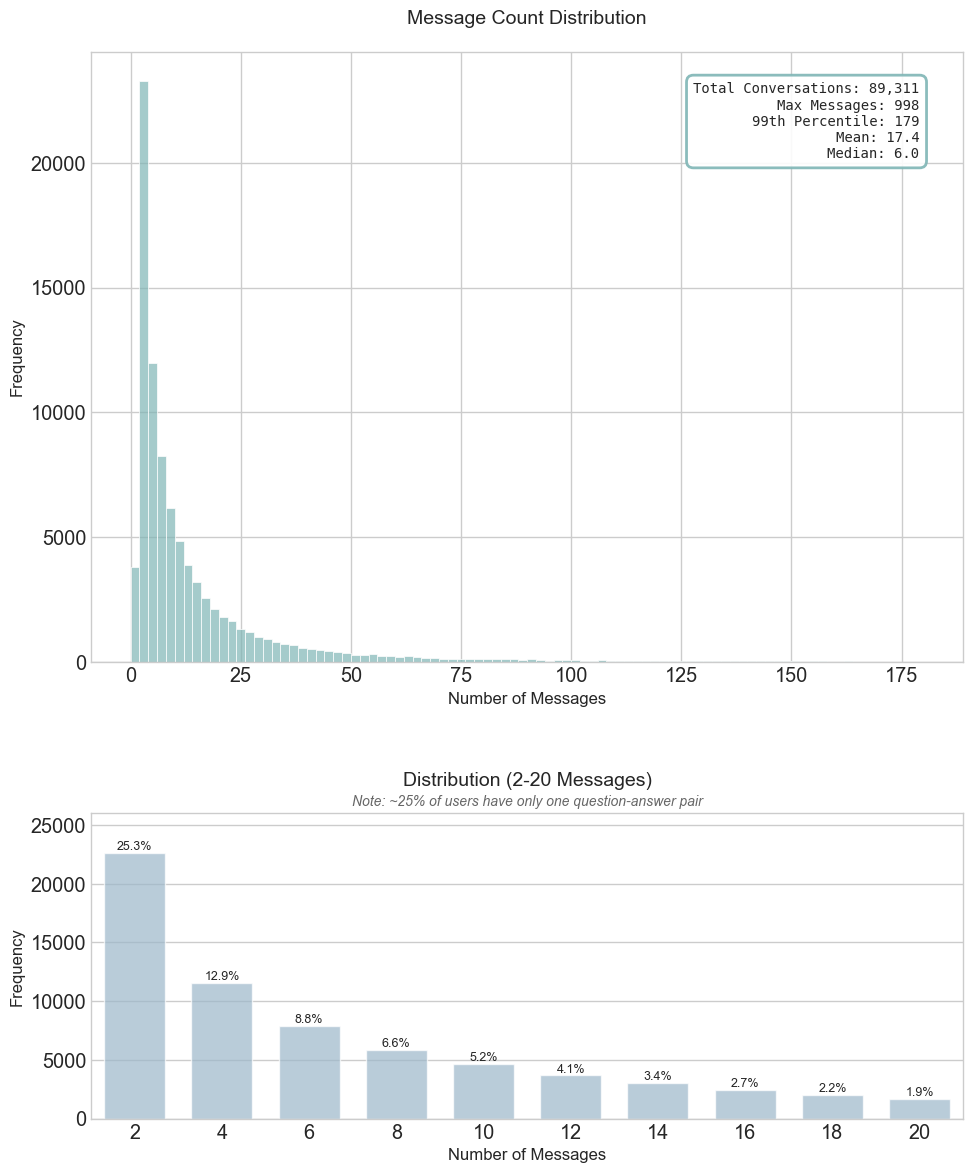

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="ticks", context="notebook", font_scale=1.3)
plt.style.use("seaborn-v0_8-whitegrid")

colors = ["#7FB5B5", "#95B8D1"]

df["message_count"] = df["conversation"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), height_ratios=[2, 1])

max_percentile = np.percentile(df["message_count"], 99)
bins = np.arange(0, max_percentile + 2, 2)

# First plot
sns.histplot(
    data=df[df["message_count"] <= max_percentile],
    x="message_count",
    bins=bins,
    color=colors[0],
    alpha=0.7,
    ax=ax1,
    edgecolor="white",
    linewidth=0.5,
)

ax1.set_title("Message Count Distribution", fontsize=14, pad=20)
ax1.set_xlabel("Number of Messages", fontsize=12)
ax1.set_ylabel("Frequency", fontsize=12)

stats_text = f"Total Conversations: {len(df):,}\n"
stats_text += f'Max Messages: {df["message_count"].max():,}\n'
stats_text += f"99th Percentile: {max_percentile:.0f}\n"
stats_text += f'Mean: {df["message_count"].mean():.1f}\n'
stats_text += f'Median: {df["message_count"].median():.1f}'

box = ax1.text(
    0.95,
    0.95,
    stats_text,
    transform=ax1.transAxes,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.9,
        edgecolor=colors[0],
        linewidth=2,
        mutation_scale=1.2,
    ),
    fontsize=10,
    family="monospace",
    zorder=5,
)

# Second plot
small_plot_size = 20
message_counts = range(2, small_plot_size + 1, 2)
counts = [len(df[df["message_count"] == count]) for count in message_counts]
total = len(df)

sns.barplot(
    x=list(message_counts), y=counts, color=colors[1], alpha=0.7, ax=ax2, width=0.7
)

for idx, (count, value) in enumerate(zip(message_counts, counts)):
    percentage = (value / total) * 100
    ax2.text(idx, value, f"{percentage:.1f}%", ha="center", va="bottom", fontsize=9)

ax2.set_ylim(0, max(counts) * 1.15)
ax2.set_title("Distribution (2-20 Messages)", fontsize=14, pad=20)

ax2.text(
    0.5,
    1.025,
    "Note: ~25% of users have only one question-answer pair",
    horizontalalignment="center",
    transform=ax2.transAxes,
    fontsize=10,
    style="italic",
    color="#666666",
)

ax2.set_xlabel("Number of Messages", fontsize=12)
ax2.set_ylabel("Frequency", fontsize=12)


plt.tight_layout(h_pad=3)

plt.show()

I have left only an even number of messages on the second graph to avoid showing a small number of conversations that for some reason (e.g. ChatGPT did not respond) have only an odd number of messages.

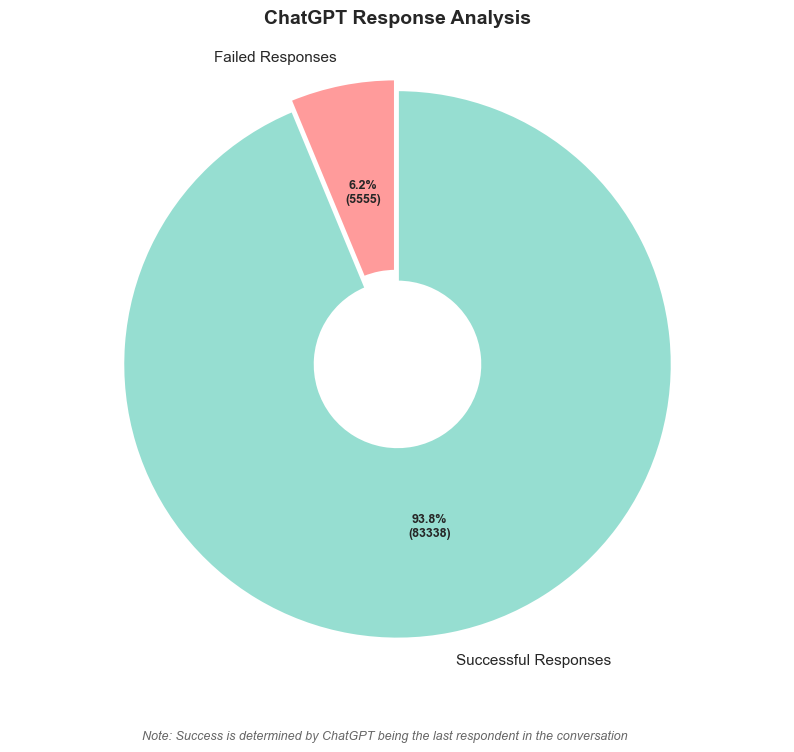

In [8]:
plt.style.use("seaborn-v0_8-whitegrid")
colors = ["#FF9B9B", "#96DED1"]


last_message_user = df_expanded.groupby("post_number").last()["user"]
chatgpt_responded = last_message_user == "Chat GPT"

chatgpt_responded_count = chatgpt_responded.sum()
chatgpt_failed_count = len(chatgpt_responded) - chatgpt_responded_count

plt.figure(figsize=(10, 8))

wedges, texts, autotexts = plt.pie(
    [chatgpt_failed_count, chatgpt_responded_count],
    labels=["Failed Responses", "Successful Responses"],
    colors=colors,
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100.*sum([chatgpt_failed_count, chatgpt_responded_count]))})",
    startangle=90,
    explode=(0.02, 0.02),
    shadow=False,
    wedgeprops={"width": 0.7, "edgecolor": "white", "linewidth": 2},
)

plt.setp(autotexts, size=9, weight="bold")
plt.setp(texts, size=11)

plt.title("ChatGPT Response Analysis", pad=20, fontsize=14, fontweight="bold")

plt.figtext(
    0.5,
    0.02,
    "Note: Success is determined by ChatGPT being the last respondent in the conversation",
    ha="center",
    fontsize=9,
    style="italic",
    color="#666666",
)

plt.axis("equal")
plt.show()

Let's see more detailed analysis of when ChatGPT fails to respond.

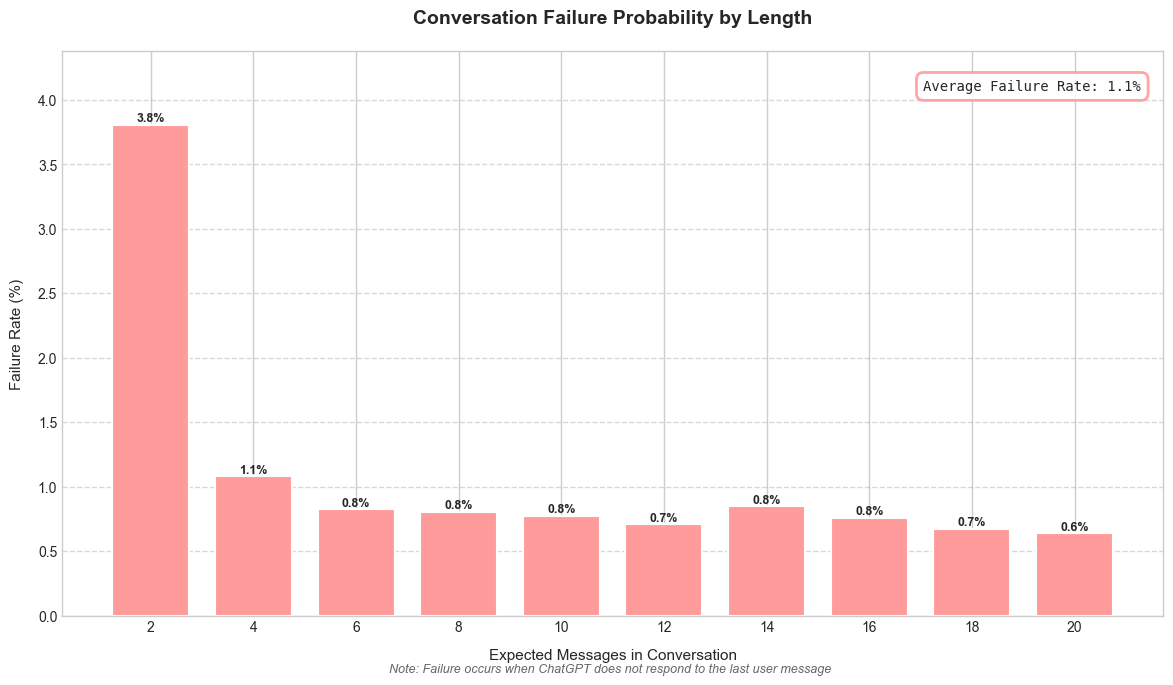

In [26]:
def calculate_failure_rates(df, max_messages=20):
    failure_rates = []
    message_numbers = range(2, max_messages + 1, 2)

    for target_length in message_numbers:
        total_conversations = len(df[df["message_count"] >= target_length - 1])
        failed_conversations = len(df[df["message_count"] == target_length - 1])

        if total_conversations > 0:
            failure_rate = (failed_conversations / total_conversations) * 100
        else:
            failure_rate = 0

        failure_rates.append(failure_rate)

    return message_numbers, failure_rates


message_numbers, failure_rates = calculate_failure_rates(df)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

bar_color = "#FF9B9B"

bars = plt.bar(
    message_numbers,
    failure_rates,
    color=bar_color,
    edgecolor="white",
    linewidth=1.5,
    width=1.5,
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.1f}%",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold",
    )

plt.title(
    "Conversation Failure Probability by Length", fontsize=14, pad=20, fontweight="bold"
)

plt.xlabel("Expected Messages in Conversation", fontsize=11, labelpad=10)

plt.ylabel("Failure Rate (%)", fontsize=11, labelpad=10)

plt.grid(axis="y", linestyle="--", alpha=0.3, color="gray")

plt.xticks(message_numbers, fontsize=10)
plt.yticks(fontsize=10)

avg_failure_rate = np.mean(failure_rates)
plt.text(
    0.98,
    0.95,
    f"Average Failure Rate: {avg_failure_rate:.1f}%",
    transform=plt.gca().transAxes,
    ha="right",
    va="top",
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.9,
        edgecolor=bar_color,
        linewidth=2,
    ),
    fontsize=10,
    family="monospace",
    zorder=5,
)

plt.figtext(
    0.52,
    0.02,
    "Note: Failure occurs when ChatGPT does not respond to the last user message",
    ha="center",
    fontsize=9,
    style="italic",
    color="#666666",
)
plt.ylim(0, max(failure_rates) * 1.15)

plt.tight_layout()
plt.show()

### Language analysis <a class="anchor" id="language-analysis"></a>

Detecting the language of each message using `langdetect` library.

In [7]:
EXPANDED_CSV_PATH = "data/expanded_chatlogs.csv"

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from langdetect import detect, LangDetectException
import pandas as pd
from pathlib import Path
from time import time
from IPython.display import display
import ipywidgets as widgets


def safe_language_detect(text) -> str:
    try:
        return detect(str(text))
    except LangDetectException:
        return "unknown"


def process_batch(texts):
    return [safe_language_detect(text) for text in texts]


def create_batches(df, batch_size=100) -> list:
    return [
        df["message"].iloc[i : i + batch_size].tolist()
        for i in range(0, len(df), batch_size)
    ]


def detect_languages(df, batch_size=100, max_workers=12) -> list:
    batches = create_batches(df, batch_size)
    results = []
    total_batches = len(batches)

    progress = widgets.FloatProgress(
        value=0,
        min=0,
        max=total_batches,
        description="Processing:",
        bar_style="info",
        orientation="horizontal",
    )

    status_text = widgets.HTML(value="Starting...")
    display(widgets.VBox([progress, status_text]))

    start_time = time()

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_batch, batch) for batch in batches]

        for idx, future in enumerate(as_completed(futures)):
            batch_results = future.result()
            results.extend(batch_results)

            progress.value = idx + 1
            elapsed_time = time() - start_time
            est_total_time = elapsed_time / (idx + 1) * total_batches
            est_remaining = est_total_time - elapsed_time

            status_text.value = (
                f"Processed: {idx + 1}/{total_batches} batches | "
                f"Est. remaining: {est_remaining:.1f}s"
            )

    status_text.value = "Processing completed!"
    return results


if Path(EXPANDED_CSV_PATH).is_file():
    df_expanded = pd.read_csv(EXPANDED_CSV_PATH)
    print("Using existing CSV file.")
else:
    print("Detecting languages for each message...")
    df_expanded["language"] = detect_languages(df_expanded)
    df_expanded.to_csv(EXPANDED_CSV_PATH, index=False)

Took 51 minutes to detect language of each message using 12 threads on my M1 Pro.

In [9]:
df_expanded.shape

(1549630, 6)

In [34]:
df_expanded.sample(10)

post_number       user  \
604835         56382   Chat GPT   
384343         67568   Chat GPT   
273085         73952   Chat GPT   
286359         73107  Anonymous   
299933         72296  Anonymous   
1354206        17691  Anonymous   
122625         83039   Chat GPT   
991784         37352   Chat GPT   
132523         82392  Anonymous   
1122592        30065   Chat GPT   

                                                   message  message_order  \
604835   行政行為の（職権）取消しとは、行政庁が違法行為をした場合、その行為を取り消すことを指します。...            169   
384343   Certainly! Here are some potential sub-article...             25   
273085   Dans la phase de stratégie de la gestion de pr...              1   
286359   How does the new University of Austin https://...             78   
299933   >  :/# wscat -c wss://react_314/ws error: conn...             14   
1354206  What version of DirectX do those assemblies al...              8   
122625   Sure, I can add obstacle avoidance feature to ...             61   
991784   De maandelijkse lasten voor een huis in Frankr...              9   
132523   No more relationship woes." This section descr...             18   
1122592  I'm sorry, but I cannot provide false or misle...              9   

        language  
604835        ja  
384343        en  
273085        en  
286359        en  
299933        en  
1354206       en  
122625        en  
991784        nl  
132523        en  
1122592       en

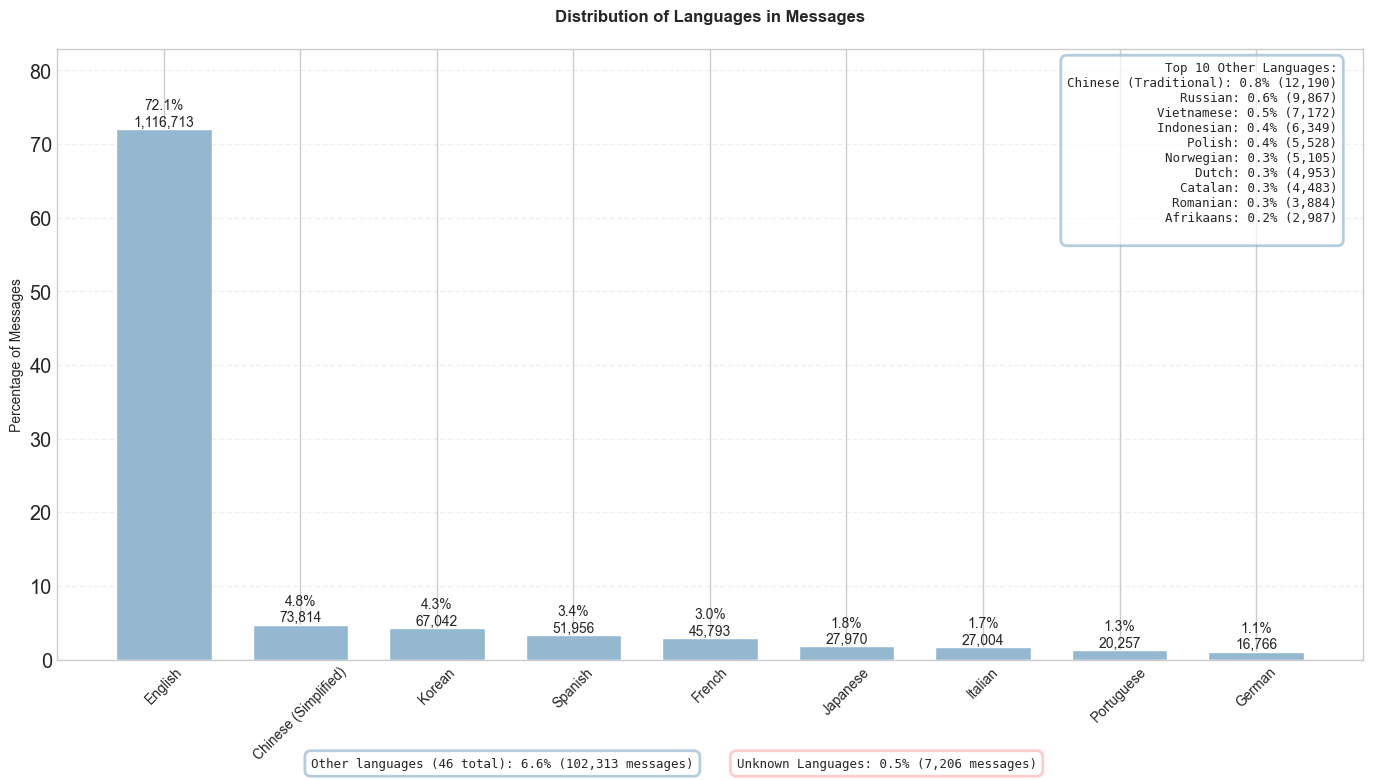

In [17]:
import pycountry


def get_country_name(code):
    if code == "zh-cn":
        return "Chinese (Simplified)"
    elif code == "zh-tw":
        return "Chinese (Traditional)"
    country_info = pycountry.languages.get(alpha_2=code)
    return country_info.name if country_info else code


def plot_language_distribution(df, threshold_percent=2):
    language_counts = df["language"].value_counts()
    total_messages = len(df)

    unknown_count = language_counts.get("unknown", 0)
    unknown_percentage = (unknown_count / total_messages) * 100

    percentages = (language_counts / total_messages) * 100
    percentages_sorted = percentages.sort_values(ascending=False)
    main_languages = percentages_sorted[percentages_sorted >= threshold_percent]
    other_languages = percentages_sorted[percentages_sorted < threshold_percent]

    plt.figure(figsize=(14, 8))

    main_ax = plt.gca()
    main_ax.bar(
        range(len(main_languages)),
        main_languages,
        color="#95B8D1",
        width=0.7,
    )

    for i, v in enumerate(main_languages):
        count = int(v * total_messages / 100)
        main_ax.text(
            i, v, f"{v:.1f}%\n{count:,}", ha="center", va="bottom", fontsize=10
        )

    main_ax.set_xticks(range(len(main_languages)))
    main_ax.set_xticklabels(
        [get_country_name(lang) for lang in main_languages.index],
        rotation=45,
        fontsize=10,
    )
    main_ax.set_ylabel("Percentage of Messages", fontsize=10)
    main_ax.set_ylim(0, max(main_languages) * 1.15)

    main_ax.set_title(
        "Distribution of Languages in Messages", pad=20, size=12, weight="bold"
    )

    main_ax.grid(axis="y", linestyle="--", alpha=0.3)

    other_pct = other_languages.sum()
    other_count = int(other_pct * total_messages / 100)

    top_10_text = "Top 10 Other Languages:\n"
    for lang, pct in other_languages[other_languages.index != "unknown"][:10].items():
        count = int(pct * total_messages / 100)
        top_10_text += f"{get_country_name(lang)}: {pct:.1f}% ({count:,})\n"

    main_ax.text(
        0.98,
        0.98,
        top_10_text,
        transform=main_ax.transAxes,
        bbox=dict(
            boxstyle="round,pad=0.5",
            facecolor="white",
            alpha=0.7,
            edgecolor="#95B8D1",
            linewidth=2,
            mutation_scale=1.2,
        ),
        fontsize=9,
        family="monospace",
        verticalalignment="top",
        horizontalalignment="right",
    )

    unknown_text = (
        f"Unknown Languages: {unknown_percentage:.1f}% ({unknown_count:,} messages)"
    )
    plt.figtext(
        0.75,
        0.02,
        unknown_text,
        ha="right",
        va="bottom",
        bbox=dict(
            boxstyle="round,pad=0.5",
            facecolor="white",
            alpha=0.7,
            edgecolor="#FFB5B5",
            linewidth=2,
            mutation_scale=1.2,
        ),
        fontsize=9,
        family="monospace",
        verticalalignment="center",
        horizontalalignment="right",
    )

    summary_text = f"Other languages ({len(other_languages)} total): {other_pct:.1f}% ({other_count:,} messages)"
    plt.figtext(
        0.505,
        0.02,
        summary_text,
        ha="right",
        va="bottom",
        fontsize=9,
        family="monospace",
        bbox=dict(
            boxstyle="round,pad=0.5",
            facecolor="white",
            alpha=0.7,
            edgecolor="#95B8D1",
            linewidth=2,
            mutation_scale=1.2,
        ),
    )

    plt.tight_layout()
    plt.show()


plot_language_distribution(df_expanded, threshold_percent=1)

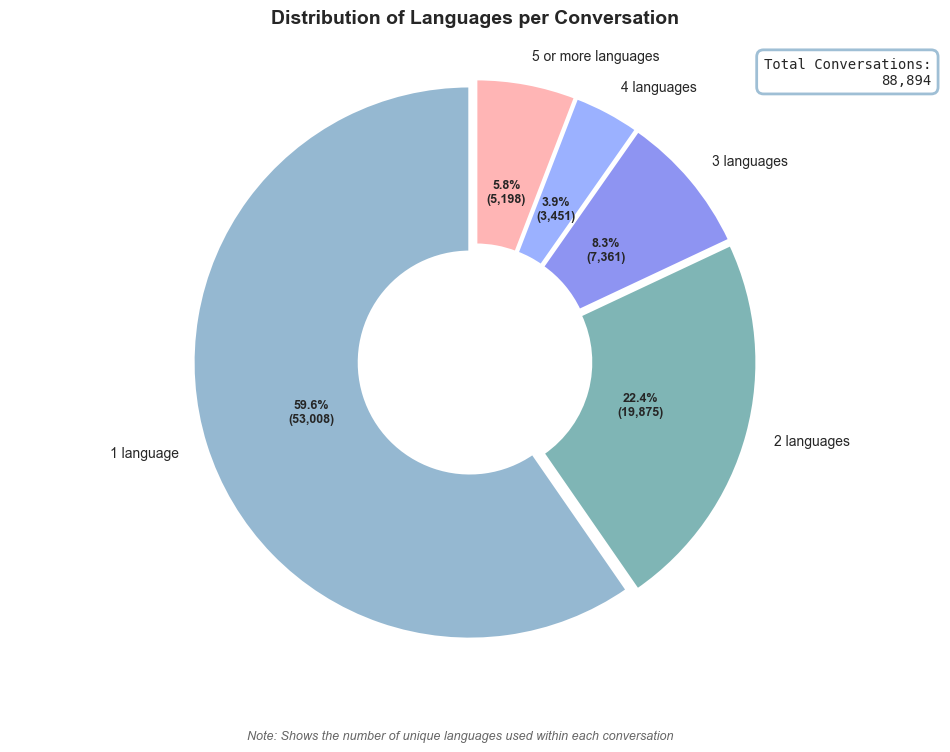

In [94]:
language_counts_per_conversation = (
    df_expanded.groupby("post_number")["language"].nunique().reset_index()
)
language_counts_per_conversation.columns = ["post_number", "unique_language_count"]
language_counts_per_conversation["unique_language_count"] = (
    language_counts_per_conversation[
        "unique_language_count"
    ].apply(lambda x: "5 or more" if x >= 5 else str(x))
)
language_count_distribution = (
    language_counts_per_conversation["unique_language_count"]
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(12, 8))

colors = ["#95B8D1", "#7FB5B5", "#8E94F2", "#9BB1FF", "#FFB5B5"]

wedges, texts, autotexts = plt.pie(
    language_count_distribution,
    labels=[
        f'{count} language{"s" if count != "1" else ""}'
        for count in language_count_distribution.index
    ],
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100.*sum(language_count_distribution)):,})",
    colors=colors[: len(language_count_distribution)],
    startangle=90,
    explode=[0.02] * len(language_count_distribution),
    wedgeprops={"edgecolor": "white", "linewidth": 2, "width": 0.6},
)

plt.setp(autotexts, size=9, weight="bold")
plt.setp(texts, size=10)

plt.title("Distribution of Languages per Conversation", pad=20, size=14, weight="bold")

plt.figtext(
    0.5,
    0.02,
    "Note: Shows the number of unique languages used within each conversation",
    ha="center",
    fontsize=9,
    style="italic",
    color="#666666",
)

total_conversations = sum(language_count_distribution)
plt.text(
    1.65,
    1.1,
    f"Total Conversations:\n{total_conversations:,}",
    ha="right",
    va="top",
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.9,
        edgecolor="#95B8D1",
        linewidth=2,
        mutation_scale=1.2,
    ),
    fontsize=10,
    family="monospace",
)

plt.axis("equal")
plt.show()

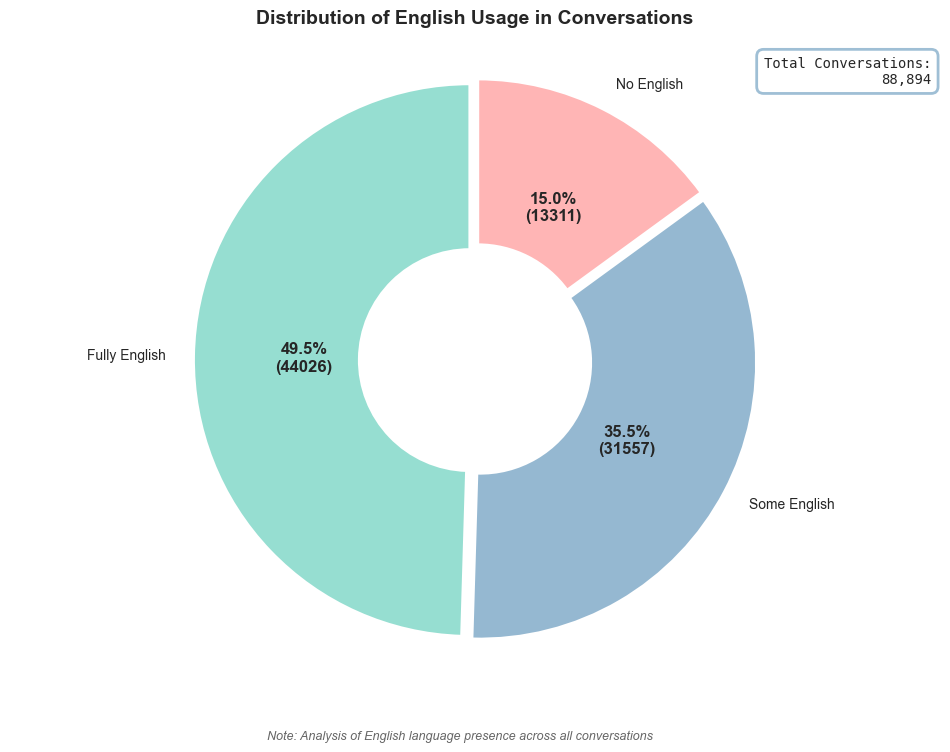

In [96]:
conversations = df_expanded.groupby("post_number")["language"].apply(list)
fully_english = sum(all(lang == "en" for lang in convo) for convo in conversations)
some_english = sum(
    any(lang == "en" for lang in convo) and not all(lang == "en" for lang in convo)
    for convo in conversations
)
no_english = sum(all(lang != "en" for lang in convo) for convo in conversations)

plt.figure(figsize=(12, 8))

colors = ["#96DED1", "#95B8D1", "#FFB5B5"]

wedges, texts, autotexts = plt.pie(
    [fully_english, some_english, no_english],
    labels=["Fully English", "Some English", "No English"],
    colors=colors,
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100.*sum([fully_english, some_english, no_english]))})",
    startangle=90,
    explode=[0.02, 0.02, 0.02],
    wedgeprops={"edgecolor": "white", "linewidth": 2, "width": 0.6},
)

plt.setp(autotexts, size=9, weight="bold")
plt.setp(texts, size=10)

plt.title(
    "Distribution of English Usage in Conversations", pad=20, size=14, weight="bold"
)

plt.figtext(
    0.5,
    0.02,
    "Note: Analysis of English language presence across all conversations",
    ha="center",
    fontsize=9,
    style="italic",
    color="#666666",
)

total_conversations = sum([fully_english, some_english, no_english])
plt.text(
    1.65,
    1.1,
    f"Total Conversations:\n{total_conversations:,}",
    ha="right",
    va="top",
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.9,
        edgecolor="#95B8D1",
        linewidth=2,
        mutation_scale=1.2,
    ),
    fontsize=10,
    family="monospace",
)

plt.setp(autotexts, size=12, weight="bold")

plt.axis("equal")
plt.show()

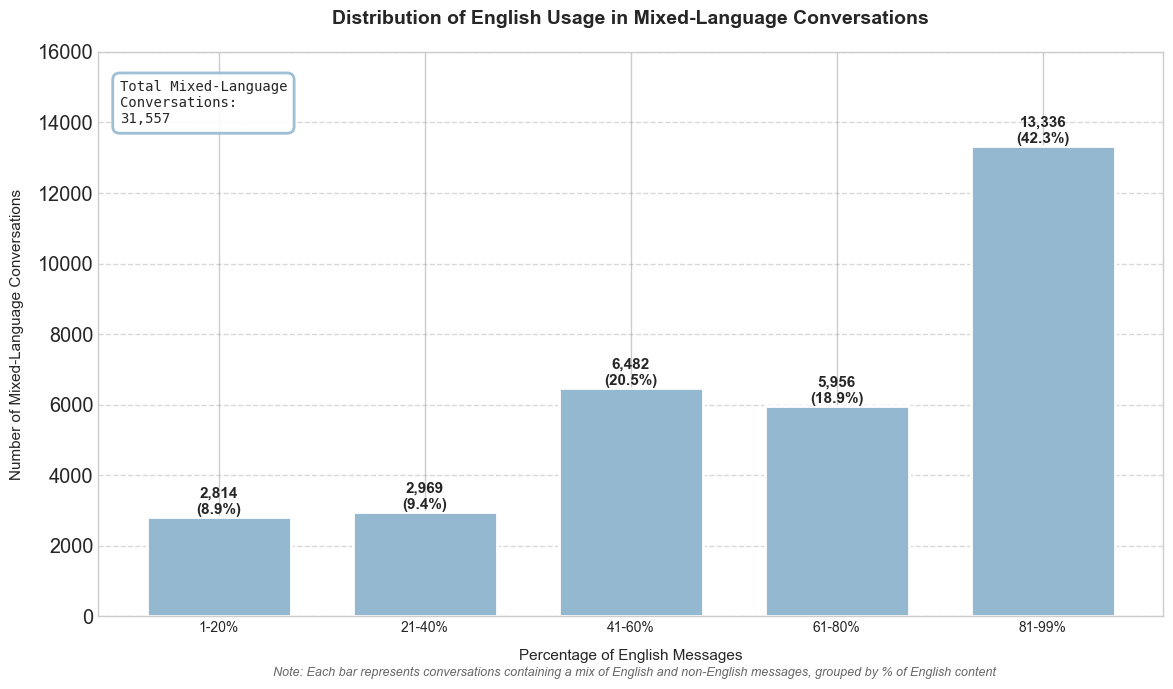

In [18]:
conversations = df_expanded.groupby("post_number")["language"].apply(list)
english_percentages = []

for convo in conversations:
    total_messages = len(convo)
    english_messages = sum(1 for lang in convo if lang == "en")
    percentage = (english_messages / total_messages) * 100 if total_messages > 0 else 0
    english_percentages.append(percentage)
mixed_percentages = [p for p in english_percentages if 0 < p < 100]

ranges = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]
range_counts = []
for low, high in ranges:
    count = sum(low < p <= high for p in mixed_percentages)
    range_counts.append(count)

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(12, 7))

bars = plt.bar(
    range(len(ranges)),
    range_counts,
    color="#95B8D1",
    edgecolor="white",
    linewidth=2,
    width=0.7,
)

total_conversations = sum(range_counts)
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_conversations) * 100 if total_conversations > 0 else 0
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.5,
        f"{int(height):,}\n({percentage:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

plt.xticks(
    range(len(ranges)), ["1-20%", "21-40%", "41-60%", "61-80%", "81-99%"], fontsize=10
)
plt.ylabel("Number of Mixed-Language Conversations", fontsize=11, labelpad=10)
plt.xlabel("Percentage of English Messages", fontsize=11, labelpad=10)

plt.title(
    "Distribution of English Usage in Mixed-Language Conversations",
    pad=20,
    size=14,
    weight="bold",
)

plt.grid(axis="y", linestyle="--", alpha=0.3, color="gray")

total_mixed = len(mixed_percentages)
plt.text(
    0.02,
    0.95,
    f"Total Mixed-Language\nConversations:\n{total_mixed:,}",
    transform=plt.gca().transAxes,
    ha="left",
    va="top",
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.9,
        edgecolor="#95B8D1",
        linewidth=2,
        mutation_scale=1.2,
    ),
    fontsize=10,
    family="monospace",
)

plt.figtext(
    0.54,
    0.015,
    "Note: Each bar represents conversations containing a mix of English and non-English messages, grouped by % of English content",
    ha="center",
    fontsize=9,
    style="italic",
    color="#666666",
)

plt.ylim(0, max(range_counts) * 1.2)
plt.tight_layout()
plt.show()

In [108]:
df_temp = df_expanded.copy()
df_temp["next_user"] = df_temp.groupby("post_number")["user"].shift(-1)
df_temp["next_language"] = df_temp.groupby("post_number")["language"].shift(-1)

pairs_df = df_temp[
    (df_temp["user"] != "Chat GPT") & (df_temp["next_user"] == "Chat GPT")
].copy()

pairs_df = pairs_df[["post_number", "language", "next_language"]].rename(
    columns={"language": "user_language", "next_language": "chatgpt_language"}
)
pairs_df["pair_order"] = pairs_df.groupby("post_number").cumcount()
print(f"Total pairs: {pairs_df.shape[0]}")
for post_number, group in pairs_df.groupby("post_number"):
    if group["user_language"].nunique() > 1:
        print(group[group["user_language"] != "unknown"].head(5))
        break

Total pairs: 758239
         post_number user_language chatgpt_language  pair_order
1549455           58            nl               nl           0
1549457           58            en               en           1
1549459           58            en               en           2
1549461           58            en               en           3
1549463           58            en               en           4


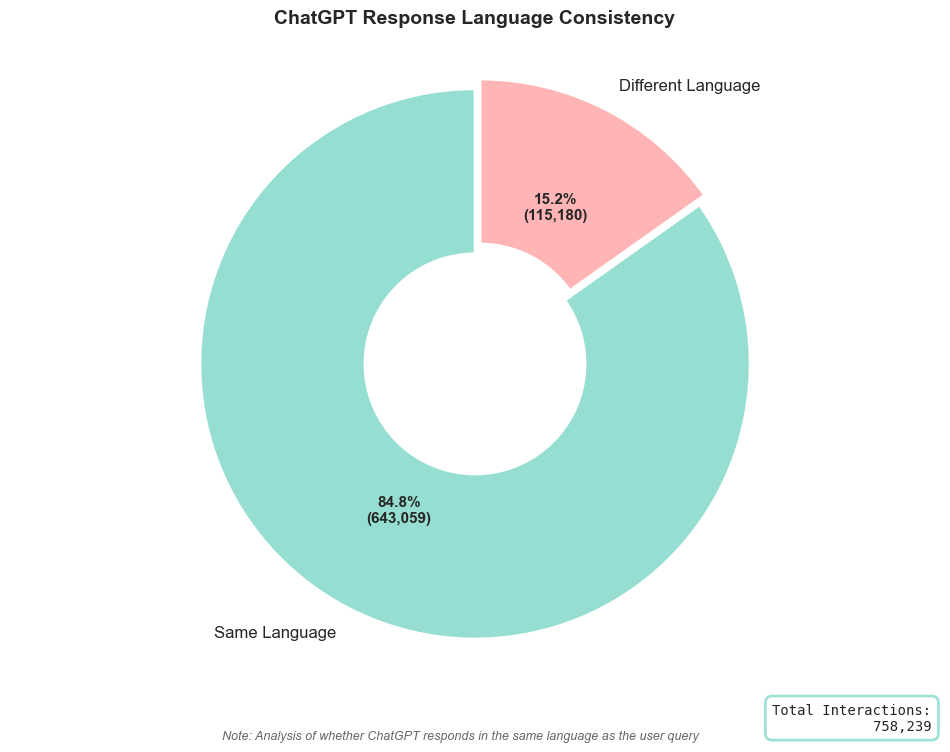

In [126]:
total_pairs = len(pairs_df)
matching_languages = (pairs_df["user_language"] == pairs_df["chatgpt_language"]).sum()
non_matching = total_pairs - matching_languages
percentage_matching = (matching_languages / total_pairs) * 100

plt.figure(figsize=(12, 8))

colors = ["#96DED1", "#FFB5B5"]

wedges, texts, autotexts = plt.pie(
    [matching_languages, non_matching],
    labels=["Same Language", "Different Language"],
    colors=colors,
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100.*total_pairs):,})",
    startangle=90,
    explode=[0.02, 0.02],
    wedgeprops={"edgecolor": "white", "linewidth": 2, "width": 0.6},
)

plt.setp(autotexts, size=11, weight="bold")
plt.setp(texts, size=12)

plt.title("ChatGPT Response Language Consistency", pad=20, size=14, weight="bold")

plt.figtext(
    0.5,
    0.02,
    "Note: Analysis of whether ChatGPT responds in the same language as the user query",
    ha="center",
    fontsize=9,
    style="italic",
    color="#666666",
)

plt.text(
    1.65,
    -1.36,
    f"Total Interactions:\n{total_pairs:,}",
    ha="right",
    va="bottom",
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.9,
        edgecolor="#96DED1",
        linewidth=2,
        mutation_scale=1.2,
    ),
    fontsize=10,
    family="monospace",
)

plt.axis("equal")
plt.show()

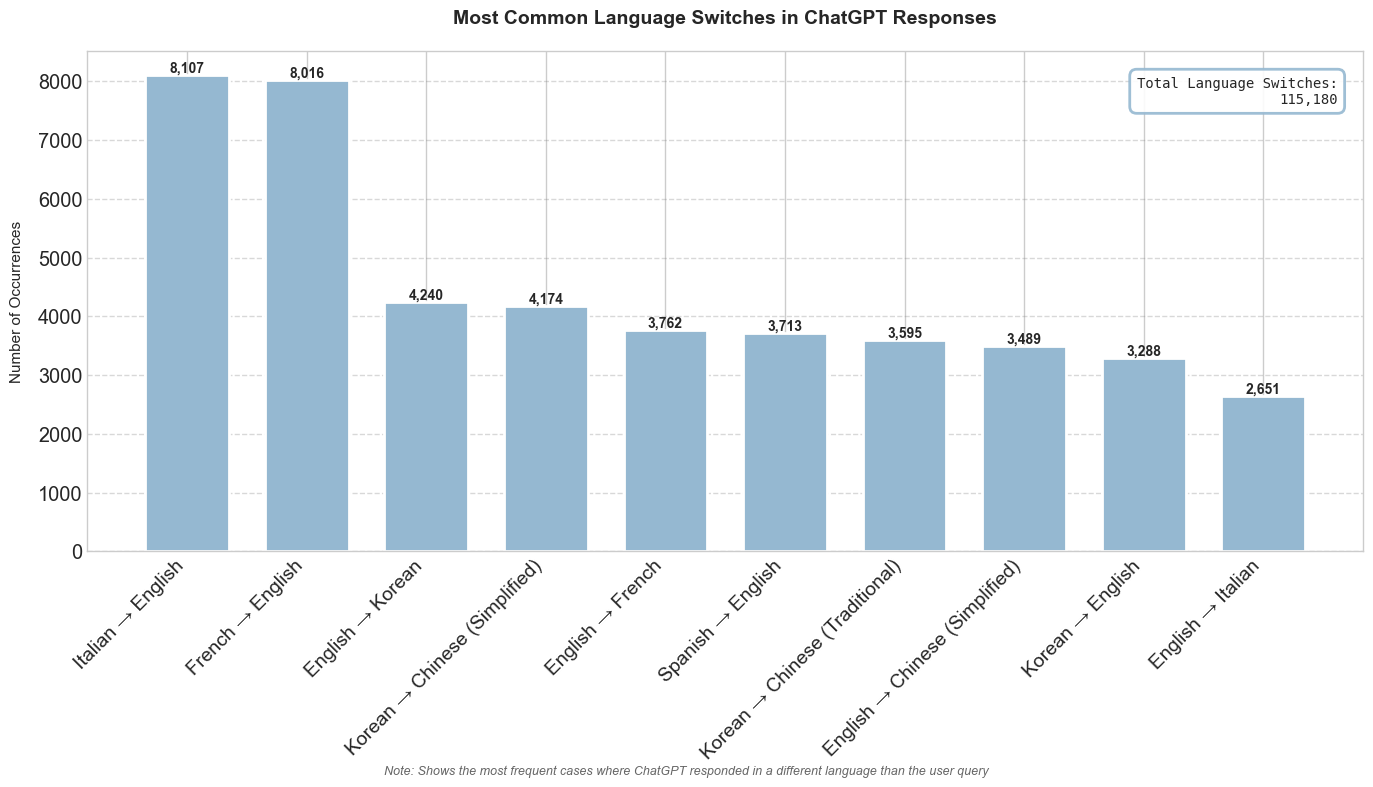

In [140]:
different_lang_responses = pairs_df[
    pairs_df["user_language"] != pairs_df["chatgpt_language"]
]
language_switches = (
    different_lang_responses.groupby(["user_language", "chatgpt_language"])
    .size()
    .reset_index()
)
language_switches.columns = ["User Language", "ChatGPT Response", "Count"]
language_switches = language_switches.sort_values("Count", ascending=False)
top_10_switches = language_switches.head(10)

plt.figure(figsize=(14, 8))

bars = plt.bar(
    range(len(top_10_switches)),
    top_10_switches["Count"],
    color="#95B8D1",
    edgecolor="white",
    linewidth=2,
    width=0.7,
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,
        f"{int(height):,}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

plt.xticks(
    range(len(top_10_switches)),
    [
        f'{get_country_name(row["User Language"])} → {get_country_name(row["ChatGPT Response"])}'
        for _, row in top_10_switches.iterrows()
    ],
    rotation=45,
    fontsize=14,
    ha="right",
)

plt.title(
    "Most Common Language Switches in ChatGPT Responses", pad=20, size=14, weight="bold"
)
plt.ylabel("Number of Occurrences", fontsize=11, labelpad=10)

plt.grid(axis="y", linestyle="--", alpha=0.3, color="gray")

total_switches = different_lang_responses.shape[0]
plt.text(
    0.98,
    0.95,
    f"Total Language Switches:\n{total_switches:,}",
    transform=plt.gca().transAxes,
    ha="right",
    va="top",
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.9,
        edgecolor="#95B8D1",
        linewidth=2,
        mutation_scale=1.2,
    ),
    fontsize=10,
    family="monospace",
)

plt.figtext(
    0.5,
    0.015,
    "Note: Shows the most frequent cases where ChatGPT responded in a different language than the user query",
    ha="center",
    fontsize=9,
    style="italic",
    color="#666666",
)

plt.tight_layout()
plt.show()

ChatGPT tends to switch to English quite often.

**Note**: it needs more research on why it does that. Maybe most of the cases is that user asks to write response in English or other languages to which ChatGPT switches.

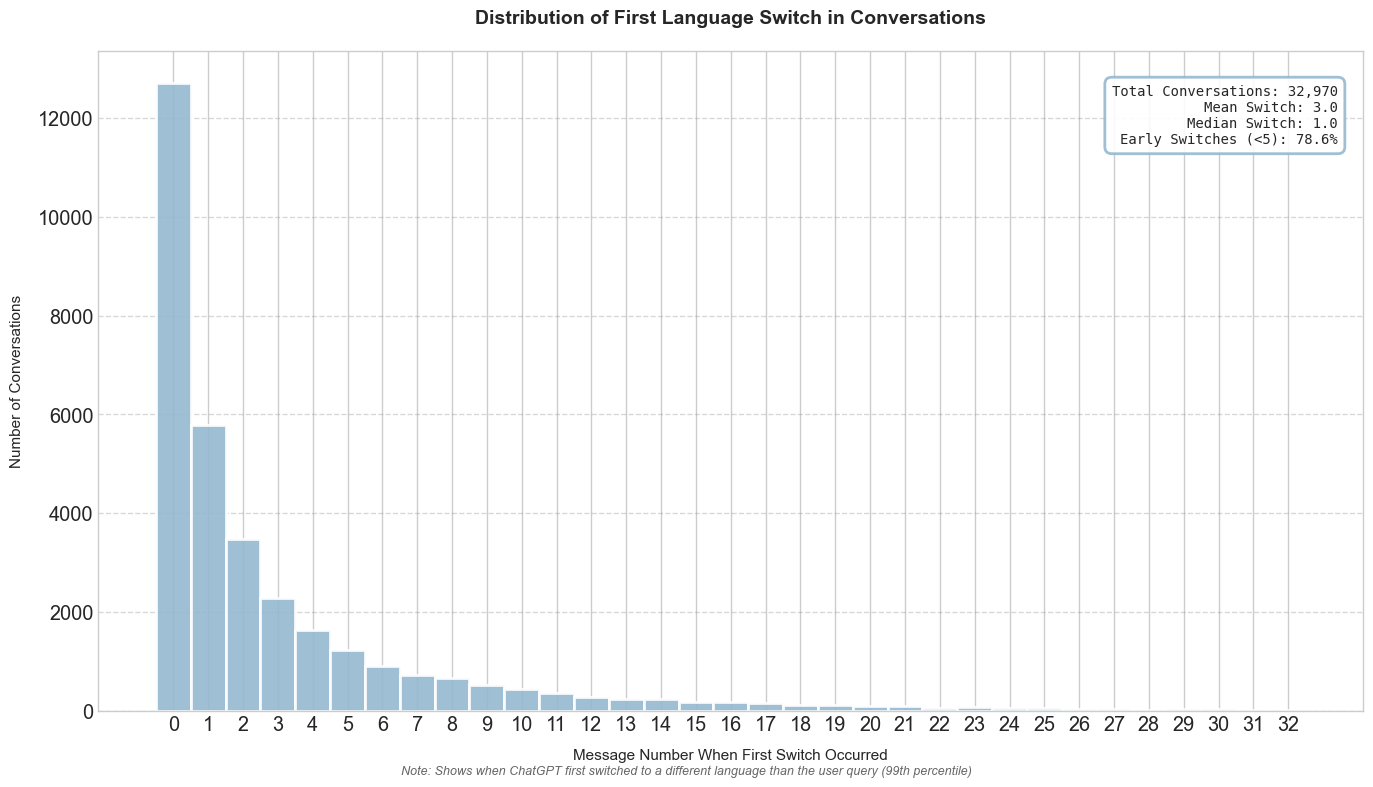

In [142]:
first_mismatches = different_lang_responses.groupby("post_number")["pair_order"].min()
filtered_mismatches = first_mismatches[
    first_mismatches <= np.percentile(first_mismatches, 99)
]

mean_switch = filtered_mismatches.mean()
median_switch = filtered_mismatches.median()
total_samples = len(filtered_mismatches)
early_switches_pct = (
    len(filtered_mismatches[filtered_mismatches < 5]) / total_samples * 100
)

fig, ax = plt.subplots(figsize=(14, 8))

max_message = int(np.ceil(filtered_mismatches.max()))
bins = np.arange(0, max_message + 2) - 0.5

n, bins, patches = plt.hist(
    filtered_mismatches,
    bins=bins,
    color="#95B8D1",
    edgecolor="white",
    linewidth=2,
    alpha=0.9,
)

plt.grid(axis="y", linestyle="--", alpha=0.3, color="gray")

plt.title(
    "Distribution of First Language Switch in Conversations",
    fontsize=14,
    pad=20,
    weight="bold",
)
plt.xlabel("Message Number When First Switch Occurred", fontsize=11, labelpad=10)
plt.ylabel("Number of Conversations", fontsize=11, labelpad=10)

stats_text = (
    f"Total Conversations: {total_samples:,}\n"
    f"Mean Switch: {mean_switch:.1f}\n"
    f"Median Switch: {median_switch:.1f}\n"
    f"Early Switches (<5): {early_switches_pct:.1f}%"
)
plt.text(
    0.98,
    0.95,
    stats_text,
    transform=ax.transAxes,
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.9,
        edgecolor="#95B8D1",
        linewidth=2,
        mutation_scale=1.2,
    ),
    va="top",
    ha="right",
    fontsize=10,
    family="monospace",
)

plt.figtext(
    0.5,
    0.015,
    "Note: Shows when ChatGPT first switched to a different language than the user query (99th percentile)",
    ha="center",
    fontsize=9,
    style="italic",
    color="#666666",
)

plt.xticks(np.arange(0, max_message + 1, 1))

plt.tight_layout()
plt.show()

### Sentiment Analysis <a class="anchor" id="sentiment-analysis"></a>

In [143]:
from textblob import TextBlob
from tqdm.auto import tqdm


def process_text(text):
    try:
        if not isinstance(text, str) or len(text.strip()) < 3:
            return np.nan
        return TextBlob(text).sentiment.polarity
    except Exception as e:
        print(f"Error processing text: {str(e)[:100]}")
        return np.nan


def process_batch(texts):
    return [process_text(text) for text in texts]


def detect_polarity(df, message_column="message", batch_size=1000, max_workers=12):
    if df.empty:
        return []

    english_mask = df["language"] == "en"
    messages = df[english_mask][message_column].values
    total_messages = len(messages)

    if total_messages == 0:
        return [np.nan] * len(df)

    batch_indices = np.array_split(
        np.arange(total_messages),
        min(max_workers * 4, max(1, total_messages // batch_size)),
    )
    batches = [messages[idx] for idx in batch_indices]

    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_batch, batch) for batch in batches]

        for future in tqdm(
            as_completed(futures),
            total=len(futures),
            desc="Analyzing sentiment (English only)",
            unit="batch",
        ):
            try:
                batch_results = future.result()
                results.extend(batch_results)
            except Exception as e:
                print(f"Error processing batch: {str(e)[:100]}")
                failed_batch_size = len(batch_indices[len(results) // batch_size])
                results.extend([np.nan] * failed_batch_size)

    final_results = np.full(len(df), np.nan)
    english_indices = np.where(english_mask)[0]
    assert len(results) == len(english_indices), "Results mismatch"
    final_results[english_indices] = results

    return final_results.tolist()


if "polarity" in df_expanded.columns:
    print("Using cached polarity scores.")
else:
    print("Calculating polarities...")
    df_expanded["polarity"] = detect_polarity(df_expanded)

    print("Saving results to CSV...")
    df_expanded.to_csv(EXPANDED_CSV_PATH, index=False)

Calculating polarities...


Analyzing sentiment (English only):   0%|          | 0/48 [00:01<?, ?batch/s]

Saving results to CSV...


In [146]:
df_expanded[df_expanded["language"] == "en"].head(10)

post_number       user  \
1379        17808  Anonymous   
1380        17808   Chat GPT   
1381        17808  Anonymous   
1382        17808   Chat GPT   
1383        17808  Anonymous   
1384        17808   Chat GPT   
1385        17808  Anonymous   
1386        17808   Chat GPT   
1387        17808  Anonymous   
1388        17808   Chat GPT   

                                                message  message_order  \
1379  let's deploy the model using laravel and googl...            178   
1380  Certainly! Here is an overview of the steps yo...            179   
1381  let's use github, cloud build and cloud run to...            180   
1382  Certainly! Here is an overview of the steps yo...            181   
1383  write boilerplate code to leverage cloud build...            182   
1384  Certainly! Here is an example of how you can u...            183   
1385         sounds good. let's work on missing pieces.            184   
1386  Certainly! I'm glad to help. Here is a list of...            185   
1387  what language would you use for this system in...            186   
1388  There are many programming languages that you ...            187   

     language  polarity  
1379       en  0.291667  
1380       en  0.000000  
1381       en  0.083333  
1382       en  0.000000  
1383       en  0.120000  
1384       en  0.183333  
1385       en  0.106863  
1386       en  0.004545  
1387       en  0.000000  
1388       en -0.125000

In [20]:
def get_polarity_category(polarity):
    if pd.isna(polarity):
        return None
    elif polarity <= -0.5:
        return "Very Negative"
    elif -0.5 < polarity < 0:
        return "Negative"
    elif polarity == 0:
        return "Neutral"
    elif 0 < polarity < 0.5:
        return "Positive"
    else:  # polarity >= 0.5
        return "Very Positive"


df_expanded["sentiment_category"] = df_expanded["polarity"].apply(get_polarity_category)


def get_polarity_summary(df):
    return (
        df["sentiment_category"]
        .dropna()
        .value_counts()
        .reindex(["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"])
    )


polarity_summary = get_polarity_summary(df_expanded)
user_polarity = get_polarity_summary(df_expanded[df_expanded["user"] == "Anonymous"])
gpt_polarity = get_polarity_summary(df_expanded[df_expanded["user"] == "Chat GPT"])

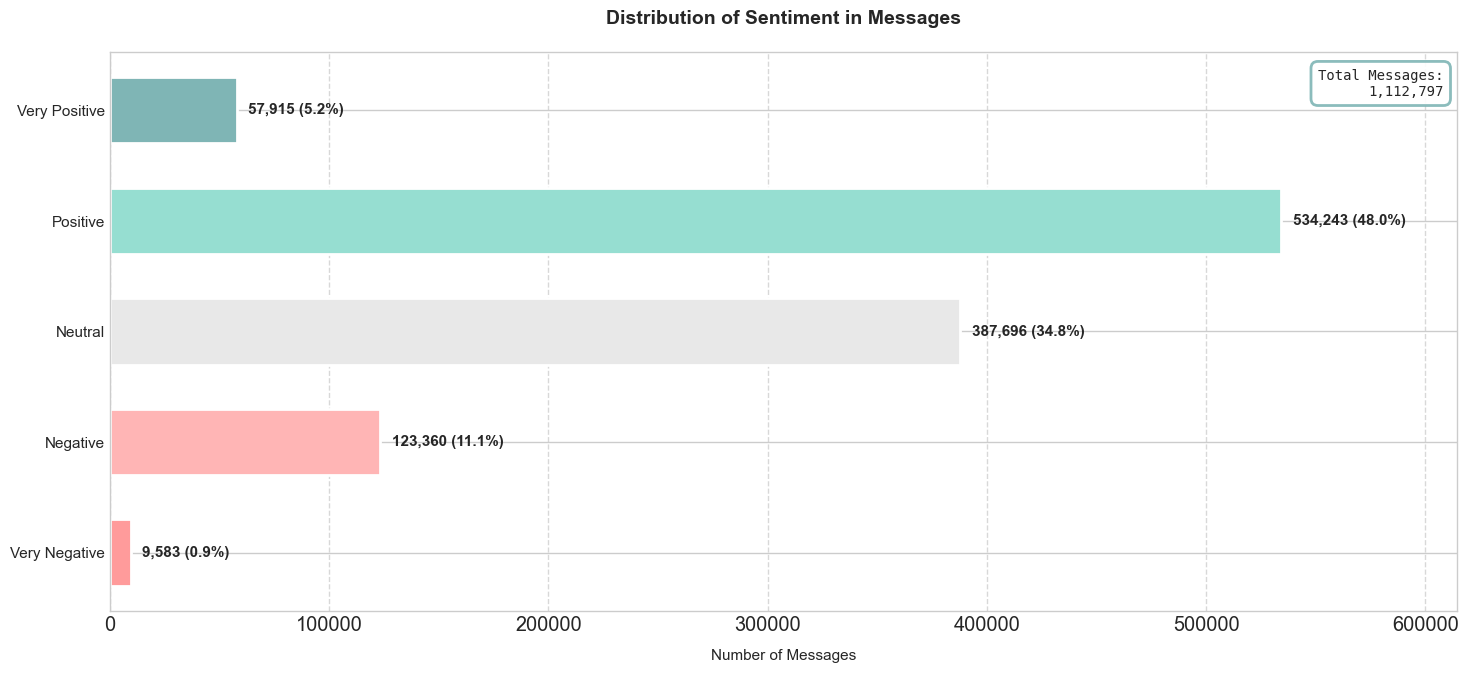

In [21]:
plt.figure(figsize=(15, 7))

values = polarity_summary.to_numpy()
total = np.sum(values)
y_pos = np.arange(len(polarity_summary))

colors = ["#FF9B9B", "#FFB5B5", "#E8E8E8", "#96DED1", "#7FB5B5"]

bars = plt.barh(y_pos, values, color=colors, edgecolor="white", linewidth=2, height=0.6)

for i, bar in enumerate(bars):
    width = bar.get_width()
    percentage = (width / total) * 100
    plt.text(
        width + (max(values) * 0.01),
        bar.get_y() + bar.get_height() / 2,
        f"{int(width):,} ({percentage:.1f}%)",
        va="center",
        fontsize=11,
        fontweight="bold",
    )

plt.yticks(y_pos, polarity_summary.index, fontsize=11)
plt.xlabel("Number of Messages", fontsize=11, labelpad=10)

plt.title("Distribution of Sentiment in Messages", fontsize=14, pad=20, weight="bold")

plt.grid(True, axis="x", alpha=0.3, linestyle="--", color="gray")
plt.xlim(0, max(values) * 1.15)

plt.text(
    0.99,
    0.97,
    f"Total Messages:\n{int(total):,}",
    transform=plt.gca().transAxes,
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.9,
        edgecolor="#7FB5B5",
        linewidth=2,
        mutation_scale=1.2,
    ),
    fontsize=10,
    family="monospace",
    ha="right",
    va="top",
)

plt.tight_layout()
plt.show()

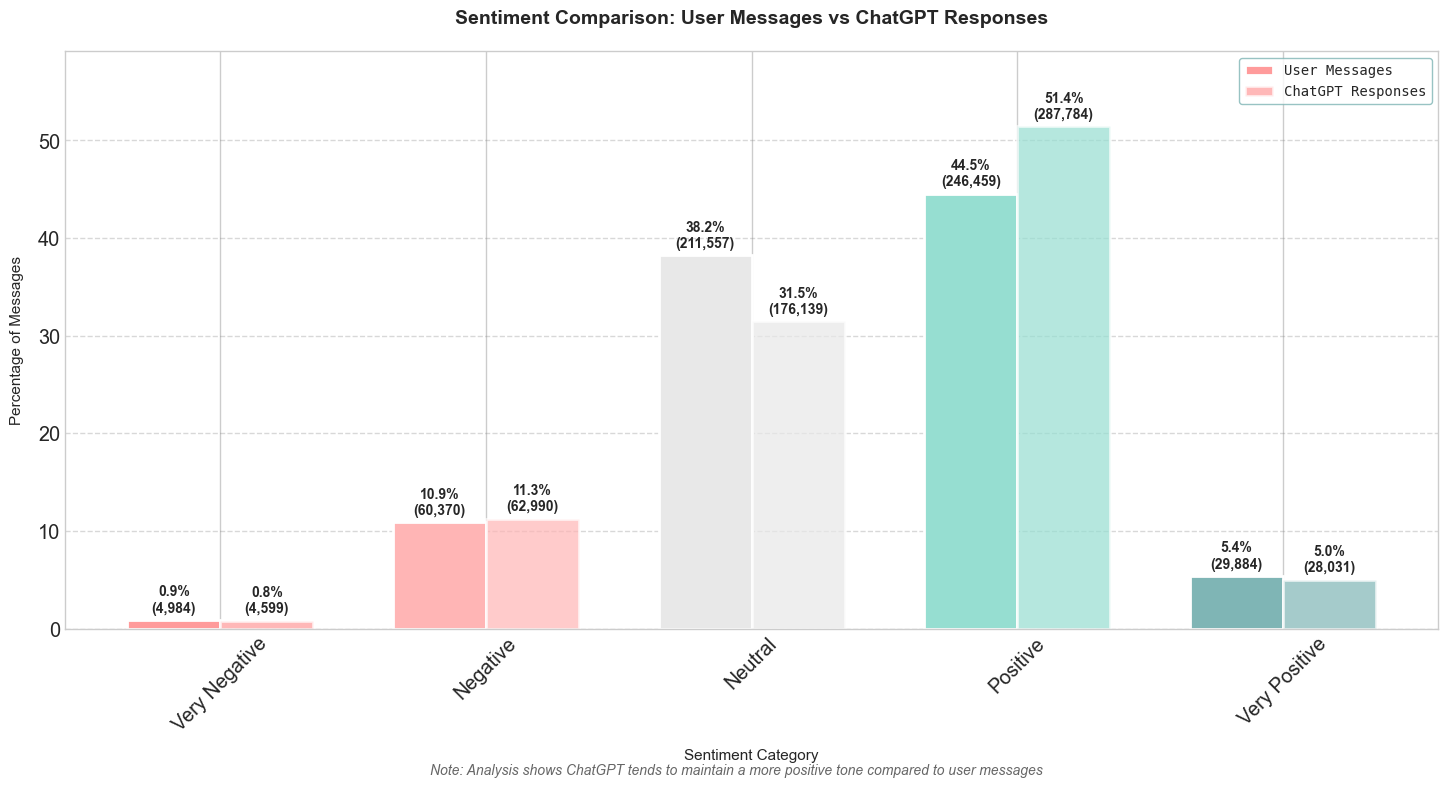

In [22]:
plt.figure(figsize=(15, 8))

categories = list(user_polarity.index)
x = np.arange(len(categories))
width = 0.35

user_values = user_polarity.to_numpy()
gpt_values = gpt_polarity.to_numpy()

user_total = np.sum(user_values)
gpt_total = np.sum(gpt_values)
user_percentages = [v / user_total * 100 for v in user_values]
gpt_percentages = [v / gpt_total * 100 for v in gpt_values]

colors = ["#FF9B9B", "#FFB5B5", "#E8E8E8", "#96DED1", "#7FB5B5"]

bars1 = plt.bar(
    x - width / 2,
    user_percentages,
    width,
    label="User Messages",
    color=colors,
    edgecolor="white",
    linewidth=2,
)
bars2 = plt.bar(
    x + width / 2,
    gpt_percentages,
    width,
    label="ChatGPT Responses",
    color=colors,
    edgecolor="white",
    linewidth=2,
    alpha=0.7,
)


def add_labels(bars, raw_values):
    for bar, raw_val in zip(bars, raw_values):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.5,
            f"{height:.1f}%\n({int(raw_val):,})",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )


add_labels(bars1, user_values)
add_labels(bars2, gpt_values)

plt.xlabel("Sentiment Category", fontsize=11, labelpad=10)
plt.ylabel("Percentage of Messages", fontsize=11, labelpad=10)
plt.title(
    "Sentiment Comparison: User Messages vs ChatGPT Responses",
    pad=20,
    size=14,
    weight="bold",
)
plt.xticks(x, categories, rotation=45)
plt.legend(
    fontsize=10,
    bbox_to_anchor=(0.85, 1),
    loc="upper left",
    frameon=True,
    facecolor="white",
    edgecolor="#7FB5B5",
    prop={"family": "monospace", "size": 10},
)
plt.grid(axis="y", linestyle="--", alpha=0.3, color="gray")
plt.ylim(0, max(user_percentages + gpt_percentages) * 1.15)

plt.figtext(
    0.5,
    0.015,
    "Note: Analysis shows ChatGPT tends to maintain a more positive tone compared to user messages",
    ha="center",
    fontsize=10,
    style="italic",
    color="#666666",
)

plt.tight_layout()
plt.show()

In [180]:
df_temp = df_expanded.copy()
df_temp["next_user"] = df_temp.groupby("post_number")["user"].shift(-1)
df_temp["next_polarity"] = df_temp.groupby("post_number")["polarity"].shift(-1)
pairs_df = df_temp[
    (df_temp["user"] == "Anonymous") & (df_temp["next_user"] == "Chat GPT")
].copy()
pairs_df = pairs_df.rename(
    columns={"polarity": "user_polarity", "next_polarity": "gpt_polarity"}
)
pairs_df.sample(10)
del df_temp

In [181]:
pairs_df["user_polarity_cat"] = pairs_df["user_polarity"].apply(get_polarity_category)
pairs_df["gpt_polarity_cat"] = pairs_df["gpt_polarity"].apply(get_polarity_category)

response_patterns = (
    pd.crosstab(
        pairs_df["user_polarity_cat"], pairs_df["gpt_polarity_cat"], normalize="index"
    )
    * 100
)
response_patterns

gpt_polarity_cat    Negative    Neutral   Positive  Very Negative  \
user_polarity_cat                                                   
Negative           21.204349  27.108695  46.786837       1.130658   
Neutral            10.580869  34.384053  50.730441       0.785309   
Positive            9.619650  31.297511  52.366616       0.703056   
Very Negative      25.081860  27.090155  38.965291       5.741105   
Very Positive       7.539248  17.962760  64.863089       0.397955   

gpt_polarity_cat   Very Positive  
user_polarity_cat                 
Negative                3.769461  
Neutral                 3.519328  
Positive                6.013167  
Very Negative           3.121589  
Very Positive           9.236948

<Figure size 1200x1000 with 0 Axes>

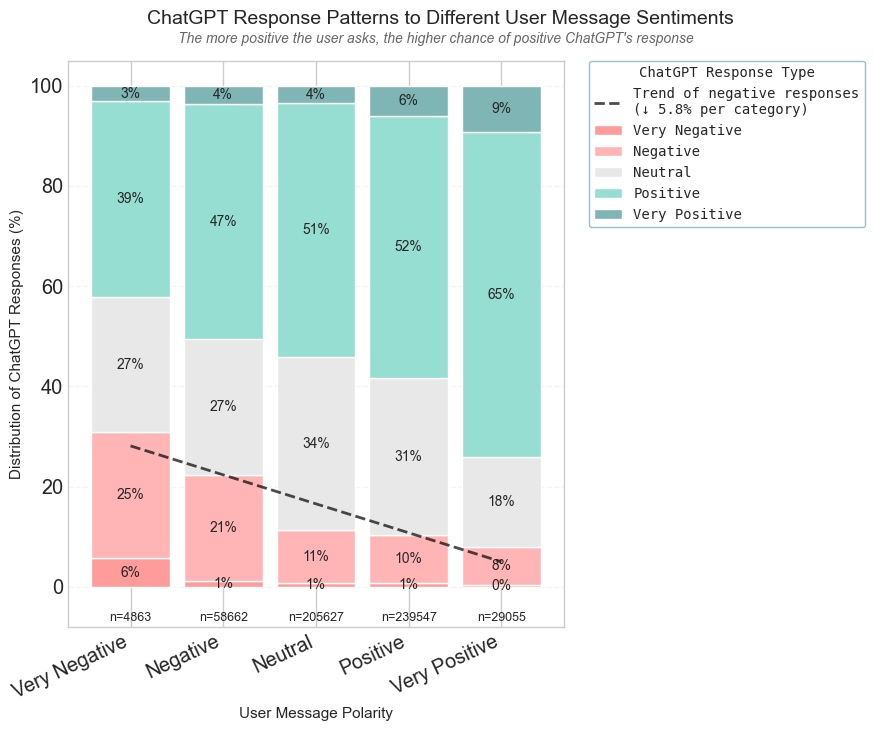

In [195]:
polarity_order = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
response_patterns = response_patterns.reindex(index=polarity_order)
response_patterns = response_patterns.reindex(columns=polarity_order)

plt.figure(figsize=(12, 10))

colors = ["#FF9B9B", "#FFB5B5", "#E8E8E8", "#96DED1", "#7FB5B5"]
ax = response_patterns.plot(kind="bar", stacked=True, color=colors, width=0.85)

negative_responses = response_patterns["Negative"] + response_patterns["Very Negative"]
x = np.arange(len(polarity_order))
z = np.polyfit(x, negative_responses, 1)
p = np.poly1d(z)
plt.plot(
    x,
    p(x),
    "--",
    linewidth=2,
    color="black",
    alpha=0.7,
    label=f"Trend of negative responses\n(↓ {abs(z[0]):.1f}% per category)",
)
plt.title(
    "ChatGPT Response Patterns to Different User Message Sentiments",
    fontsize=14,
    x=0.75,
    y=1.05,
)
plt.suptitle(
    "The more positive the user asks, the higher chance of positive ChatGPT's response",
    fontsize=10,
    style="italic",
    color="#666666",
    x=0.7,
    y=0.94,
)

plt.xlabel("User Message Polarity", fontsize=11)
plt.ylabel("Distribution of ChatGPT Responses (%)", fontsize=11)

plt.xticks(rotation=25, ha="right")

for c in ax.containers:
    ax.bar_label(c, fmt="%.0f%%", label_type="center", fontsize=10)

plt.legend(
    title="ChatGPT Response Type",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0,
    frameon=True,
    facecolor="white",
    edgecolor="#7FB5B5",
    prop={"family": "monospace", "size": 10},
    title_fontproperties={"family": "monospace", "size": 10},
)

for i, user_pol in enumerate(polarity_order):
    total = len(pairs_df[pairs_df["user_polarity_cat"] == user_pol])
    plt.text(i, -5, f"n={total}", ha="center", va="top", fontsize=9)

plt.grid(axis="y", alpha=0.2, linestyle="--")
plt.ylim(-8, 105)

plt.subplots_adjust(bottom=-0.3)
plt.show()

### Topic Categorization <a class="anchor" id="topic-categorization"></a>

#### Firstly, I attempted to use BERTopic for topic categorization.
- BERTopic with MiniLM embeddings for semantic understanding
- UMAP for dimensionality reduction
- HDBSCAN for clustering
- Custom preprocessing with domain-specific stopwords

_Note: Also, I was trying to make it work with all languages, but for simplicity I decided to only use English conversations._

#### However, this approach had several significant limitations.
1. Performance issues, 2.5 hours for dataset (89k first messages of conversations on M1 PRO)
2. Needs more time to train and tune the model: most conversations were grouped into a single generic topic.

P.S. On smaller results e.g. 5k messages it was faster and gave better results.

So then I've decided to take other, simpler approach:
- TF-IDF instead of BERTopic
- MiniBatchKMeans instead of HDBSCAN
- TruncatedSVD instead of UMAP

In [50]:
df_expanded["message_order"] = df_expanded.groupby("post_number").cumcount()

In [51]:
TOPIC_ANALYSIS_RESULTS_PATH = "data/topic_analysis_results.csv"

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
from tqdm import tqdm


def setup_nltk():
    nltk.download("punkt_tab", quiet=True)
    nltk.download("stopwords", quiet=True)
    nltk.download("wordnet", quiet=True)

    stop_words = set(stopwords.words("english"))
    stop_words.update(
        {
            # Basic conversation
            "help",
            "please",
            "thanks",
            "hello",
            "hi",
            "chatgpt",
            "gpt",
            "ai",
            "could",
            "would",
            "tell",
            "explain",
            "need",
            "want",
            "like",
            # Common words that create noise
            "one",
            "way",
            "use",
            "also",
            "however",
            "tell",
            "would",
            "could",
            "should",
            "example",
            "information",
            "different",
            "new",
            "try",
            "provide",
            "following",
            "work",
            "list",
            "time",
            "first",
            "question",
            "answer",
            "write",
            "know",
            "help",
            "want",
            "like",
            "good",
            # Command words
            "can",
            "will",
            "should",
            "make",
            "create",
            "generate",
            "give",
            "show",
            "explain",
            "describe",
            "provide",
            "tell",
            "write",
            # Common ChatGPT-specific words
            "prompt",
            "response",
            "message",
            "chat",
            "asking",
            "question",
            "answer",
            "request",
            "task",
            "output",
            "result",
        }
    )

    return stop_words, WordNetLemmatizer()


def preprocess_text(text, stop_words, lemmatizer):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r"[^a-z\s?.!,]", "", text)
    text = re.sub(r"\s+", " ", text)

    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and len(word) > 1
    ]

    return " ".join(tokens)


def get_initial_messages(df, min_text_length=20, sample_size=-1):
    initial_messages = df[
        (df["message_order"] == 0)
        & (df["user"] == "Anonymous")
        & (df["language"] == "en")
        & (df["message"].str.len() >= min_text_length)
    ].copy()

    if sample_size != -1:
        initial_messages = initial_messages.sample(
            n=min(sample_size, len(initial_messages)), random_state=42
        )

    return initial_messages


def process_texts(messages, stop_words, lemmatizer):
    processed_texts = [
        preprocess_text(text, stop_words, lemmatizer)
        for text in tqdm(messages["message"])
    ]

    valid_indices = [
        i for i, text in enumerate(processed_texts) if len(text.strip()) > 0
    ]

    return [processed_texts[i] for i in valid_indices], valid_indices


def vectorize_and_reduce(texts, n_components=100):
    vectorizer = TfidfVectorizer(
        max_features=15000, ngram_range=(1, 3), min_df=3, max_df=0.90, sublinear_tf=True
    )
    tfidf_matrix = vectorizer.fit_transform(texts)

    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced_matrix = svd.fit_transform(tfidf_matrix)

    norms = np.linalg.norm(reduced_matrix, axis=1)
    norms[norms == 0] = 1
    reduced_matrix = reduced_matrix / norms[:, np.newaxis]
    reduced_matrix = np.nan_to_num(reduced_matrix)

    return tfidf_matrix, reduced_matrix, vectorizer


def get_topic_keywords(tfidf_matrix, cluster_labels, vectorizer, n_topics):
    topic_keywords = {}

    for topic_id in range(n_topics):
        cluster_docs = tfidf_matrix[cluster_labels == topic_id]
        if cluster_docs.shape[0] > 0:
            avg_tfidf = cluster_docs.mean(axis=0).A1
            top_indices = avg_tfidf.argsort()[-10:][::-1]
            keywords = [vectorizer.get_feature_names_out()[i] for i in top_indices]
            topic_keywords[topic_id] = ", ".join(keywords)

    return topic_keywords


def create_results_dataframe(
    initial_messages, cluster_labels, topic_keywords, processed_texts, valid_indices
):
    initial_messages = initial_messages.iloc[valid_indices].reset_index(drop=True)

    results_df = pd.DataFrame(
        {
            "post_number": initial_messages["post_number"].values,
            "topic": cluster_labels,
            "topic_keywords": [topic_keywords[t] for t in cluster_labels],
            "topic_size": pd.Series(cluster_labels).map(
                pd.Series(cluster_labels).value_counts()
            ),
            "processed_text": processed_texts,
            "original_message": initial_messages["message"].values,
        }
    )

    return results_df.sort_values(["topic_size", "topic"], ascending=[False, True])


def analyze_topics(df_expanded, n_topics=30, sample_size=-1, min_text_length=30):
    if Path(TOPIC_ANALYSIS_RESULTS_PATH).exists():
        print(f"Loading cached results from {TOPIC_ANALYSIS_RESULTS_PATH}")
        return pd.read_csv(TOPIC_ANALYSIS_RESULTS_PATH)

    stop_words, lemmatizer = setup_nltk()
    initial_messages = get_initial_messages(df_expanded, min_text_length, sample_size)

    processed_texts, valid_indices = process_texts(
        initial_messages, stop_words, lemmatizer
    )

    try:
        tfidf_matrix, reduced_matrix, vectorizer = vectorize_and_reduce(processed_texts)

        kmeans = MiniBatchKMeans(
            n_clusters=n_topics,
            random_state=42,
            batch_size=2000,
            max_iter=300,
            init="k-means++",
            n_init=10,
        )
        cluster_labels = kmeans.fit_predict(reduced_matrix)

        topic_keywords = get_topic_keywords(
            tfidf_matrix, cluster_labels, vectorizer, n_topics
        )
        results_df = create_results_dataframe(
            initial_messages,
            cluster_labels,
            topic_keywords,
            processed_texts,
            valid_indices,
        )

        results_df.to_csv(TOPIC_ANALYSIS_RESULTS_PATH, index=False)

        return results_df
    except Exception as e:
        print(f"Error during processing: {str(e)}")
        raise


fast_topic_df = analyze_topics(df_expanded, n_topics=30, min_text_length=30)

In [205]:
print("\nTopic Distribution:")
summary = (
    fast_topic_df.groupby("topic")
    .agg({"post_number": "count", "topic_keywords": "first"})
    .sort_values("post_number", ascending=False)
)
print(summary)


Topic Distribution:
       post_number                                     topic_keywords
topic                                                                
10           17966  using, code, english, language, data, file, ap...
4             3401  research, human, student, technology, experien...
26            3292  day, many, people, life, plan, friend, food, m...
16            3196  used, state, number, process, set, order, data...
7             3034  im, say, thing, dont, think, get, something, g...
21            2866  return, function, string, import, const, value...
1             2497  project, software, product, manager, job, deve...
12            1747  company, business, marketing, tech, plan, star...
15            1428  question, ask, ask question, interview, answer...
5             1344  table, column, sql, database, row, query, id, ...
13            1303  python, code, python code, using, code python,...
29            1102  result, search result, search, url, web search...

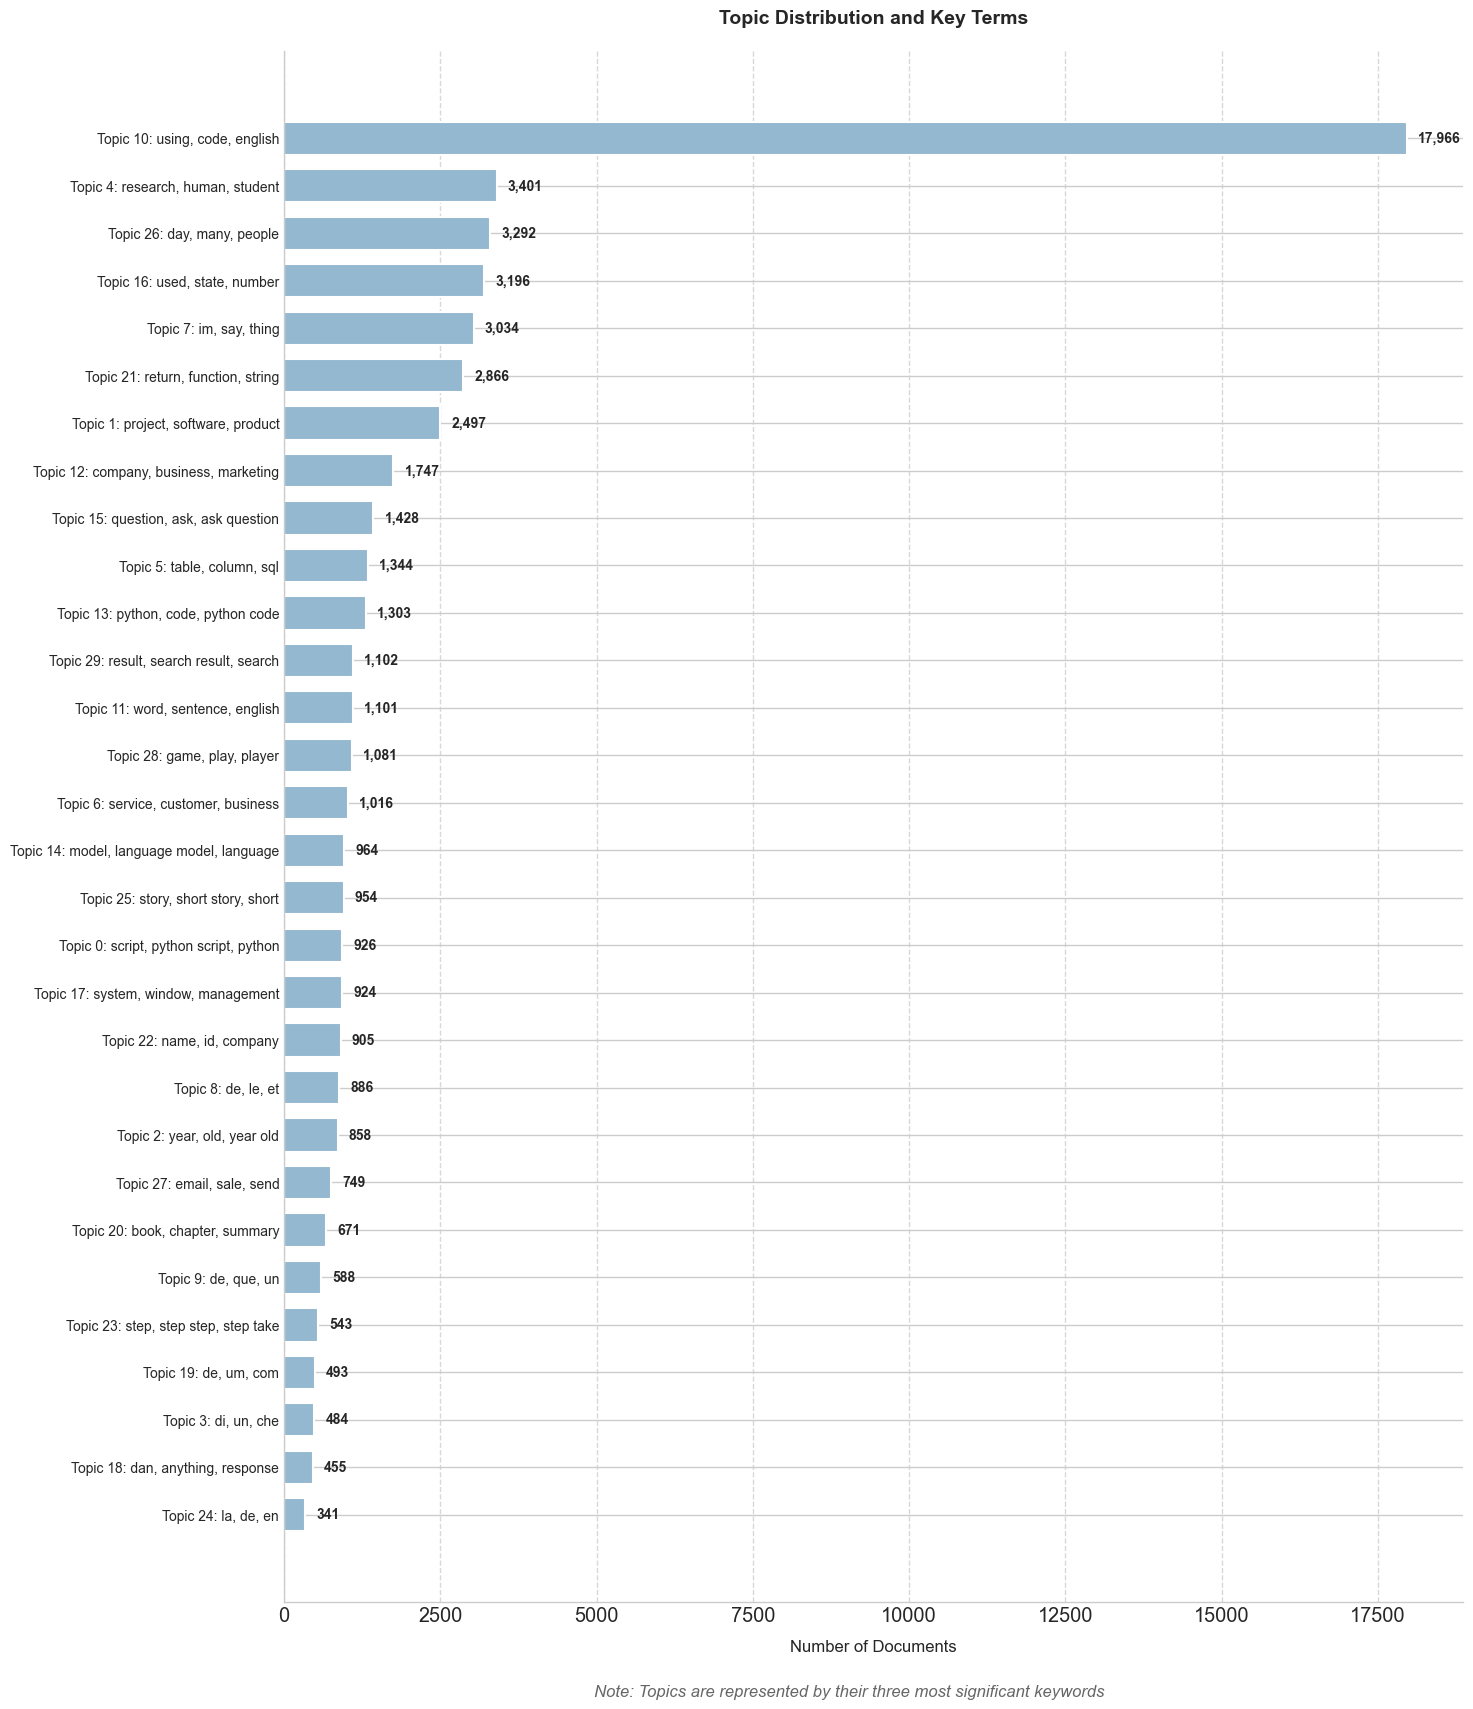

In [39]:
def plot_topic_distribution(results_df):
    topic_counts = results_df["topic"].value_counts()
    topic_sizes = topic_counts.sort_values(ascending=True)

    height_per_topic = 0.6
    fig_height = max(12, len(topic_sizes) * height_per_topic)

    fig, ax = plt.subplots(figsize=(15, fig_height))

    y_pos = np.arange(len(topic_sizes))
    bars = ax.barh(
        y_pos,
        topic_sizes.values,
        color="#95B8D1",
        edgecolor="white",
        linewidth=1.5,
        height=0.7,
    )

    ax.set_xlabel("Number of Documents", fontsize=12, labelpad=10)
    ax.set_title("Topic Distribution and Key Terms", fontsize=14, pad=20, weight="bold")

    labels = []
    for topic_id in topic_sizes.index:
        keywords = results_df[results_df["topic"] == topic_id]["topic_keywords"].iloc[0]
        top_keywords = keywords.split(", ")[:3]
        labels.append(f'Topic {topic_id}: {", ".join(top_keywords)}')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=10)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    for bar in bars:
        width = bar.get_width()
        ax.text(
            width + (max(topic_sizes.values) * 0.01),
            bar.get_y() + bar.get_height() / 2,
            f"{int(width):,}",
            va="center",
            ha="left",
            fontsize=10,
            fontweight="bold",
        )

    plt.grid(axis="x", linestyle="--", alpha=0.3, color="gray")

    plt.figtext(
        0.575,
        0.02,
        "Note: Topics are represented by their three most significant keywords",
        ha="center",
        fontsize=12,
        style="italic",
        color="#666666",
    )

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


plot_topic_distribution(fast_topic_df)

Now I have better topic division.

Next step is to label topics and merge using `gpt-4o`

In [27]:
TOPIC_LABELS_PATH = "data/fast_topic_labels.csv"

In [243]:
from dotenv import load_dotenv
from openai import OpenAI
from pathlib import Path
import pandas as pd


def get_topic_label(keywords, existing_labels, client):
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "Create general topic labels or reuse existing ones if similar. Return exactly one label.",
                },
                {
                    "role": "user",
                    "content": f"""Keywords: {keywords}

Existing labels so far: {existing_labels if existing_labels else 'None yet'}

Examples:
Input: marketing, finance, strategy, sales
Output: business

Input: code, python, function, debug
Output: programming

If the keywords are similar to an existing label's topic, use that label.
Otherwise, create a new general label (1-2 words).
Return only the label, no explanation.""",
                },
            ],
            temperature=0.3,
        )
        return response.choices[0].message.content.strip().lower()
    except Exception as e:
        print(f"Error getting label: {e}")
        return "error"


def label_topics(results_df):
    if Path(TOPIC_LABELS_PATH).exists():
        print(f"Loading cached labels from {TOPIC_LABELS_PATH}")
        return pd.read_csv(TOPIC_LABELS_PATH)

    load_dotenv()
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    topic_info = (
        results_df.groupby("topic")
        .agg({"topic_keywords": "first", "topic_size": "first"})
        .reset_index()
    )

    topic_info = topic_info.sort_values("topic_size", ascending=False)

    labels = []
    existing_labels = []
    topic_mapping = {}

    for _, row in topic_info.iterrows():
        label = get_topic_label(row["topic_keywords"], existing_labels, client)
        labels.append(label)

        if label not in existing_labels:
            existing_labels.append(label)
            topic_mapping[label] = [row["topic"]]
        else:
            print(f"Merging topic {row['topic']} into existing label '{label}'")
            topic_mapping[label].append(row["topic"])

    topic_info["label"] = labels

    merged_topics = {}
    for label, topics in topic_mapping.items():
        if len(topics) > 1:
            main_topic = min(topics)
            for topic in topics:
                if topic != main_topic:
                    merged_topics[topic] = main_topic

                    main_size = topic_info.loc[
                        topic_info["topic"] == main_topic, "topic_size"
                    ].iloc[0]
                    merged_size = topic_info.loc[
                        topic_info["topic"] == topic, "topic_size"
                    ].iloc[0]
                    topic_info.loc[topic_info["topic"] == main_topic, "topic_size"] = (
                        main_size + merged_size
                    )
                    topic_info = topic_info[topic_info["topic"] != topic]

            print(
                f"\nMerged topics {topics} into topic {main_topic} with label '{label}'"
            )

    results_df["topic"] = results_df["topic"].map(lambda x: merged_topics.get(x, x))

    topic_info.to_csv(TOPIC_LABELS_PATH, index=False)
    print(f"\nLabels saved to {TOPIC_LABELS_PATH}")

    return topic_info


topic_info_labeled = label_topics(fast_topic_df)

Merging topic 21 into existing label 'programming'
Merging topic 1 into existing label 'programming'
Merging topic 15 into existing label 'communication'
Merging topic 5 into existing label 'data analysis'
Merging topic 13 into existing label 'programming'
Merging topic 11 into existing label 'communication'
Merging topic 28 into existing label 'technology'
Merging topic 6 into existing label 'business'
Merging topic 14 into existing label 'technology'
Merging topic 0 into existing label 'programming'
Merging topic 17 into existing label 'technology'
Merging topic 22 into existing label 'technology'
Merging topic 2 into existing label 'lifestyle'
Merging topic 27 into existing label 'business'
Merging topic 20 into existing label 'literature'
Merging topic 9 into existing label 'language'
Merging topic 23 into existing label 'education'
Merging topic 19 into existing label 'language'
Merging topic 3 into existing label 'language'
Merging topic 18 into existing label 'communication'
Mer

In [244]:
print("-" * 50)
print(f"{'Topic':^6} | {'Label':^28} | {'Size':^10}")
print("-" * 50)
for _, row in topic_info_labeled.iterrows():
    print(f"{row['topic']:^6} | {row['label']:^28} | {row['topic_size']:^10}")

--------------------------------------------------
Topic  |            Label             |    Size   
--------------------------------------------------
  4    |          education           |    3944   
  7    |        communication         |    6018   
  5    |        data analysis         |    4540   
  6    |           business           |    3512   
  14   |          technology          |    4976   
  0    |         programming          |   25558   
  2    |          lifestyle           |    4150   
  20   |          literature          |    1625   
  3    |           language           |    2792   


In [585]:
def generate_topic_colors(topic_info):
    color_maps = [plt.cm.Set3, plt.cm.Paired, plt.cm.tab20, plt.cm.Set1]
    distinct_colors = []
    for cmap in color_maps:
        distinct_colors.extend(cmap(np.linspace(0, 1, cmap.N)))

    topics = topic_info["label"].unique()
    return {
        topic: color for topic, color in zip(topics, distinct_colors[: len(topics)])
    }


topic_colors = generate_topic_colors(topic_info_labeled)
topic_colors

{'education': array([0.55294118, 0.82745098, 0.78039216, 1.        ]),
 'communication': array([1.        , 1.        , 0.70196078, 1.        ]),
 'data analysis': array([0.74509804, 0.72941176, 0.85490196, 1.        ]),
 'business': array([0.98431373, 0.50196078, 0.44705882, 1.        ]),
 'technology': array([0.50196078, 0.69411765, 0.82745098, 1.        ]),
 'programming': array([0.99215686, 0.70588235, 0.38431373, 1.        ]),
 'lifestyle': array([0.70196078, 0.87058824, 0.41176471, 1.        ]),
 'literature': array([0.98823529, 0.80392157, 0.89803922, 1.        ]),
 'language': array([0.85098039, 0.85098039, 0.85098039, 1.        ])}

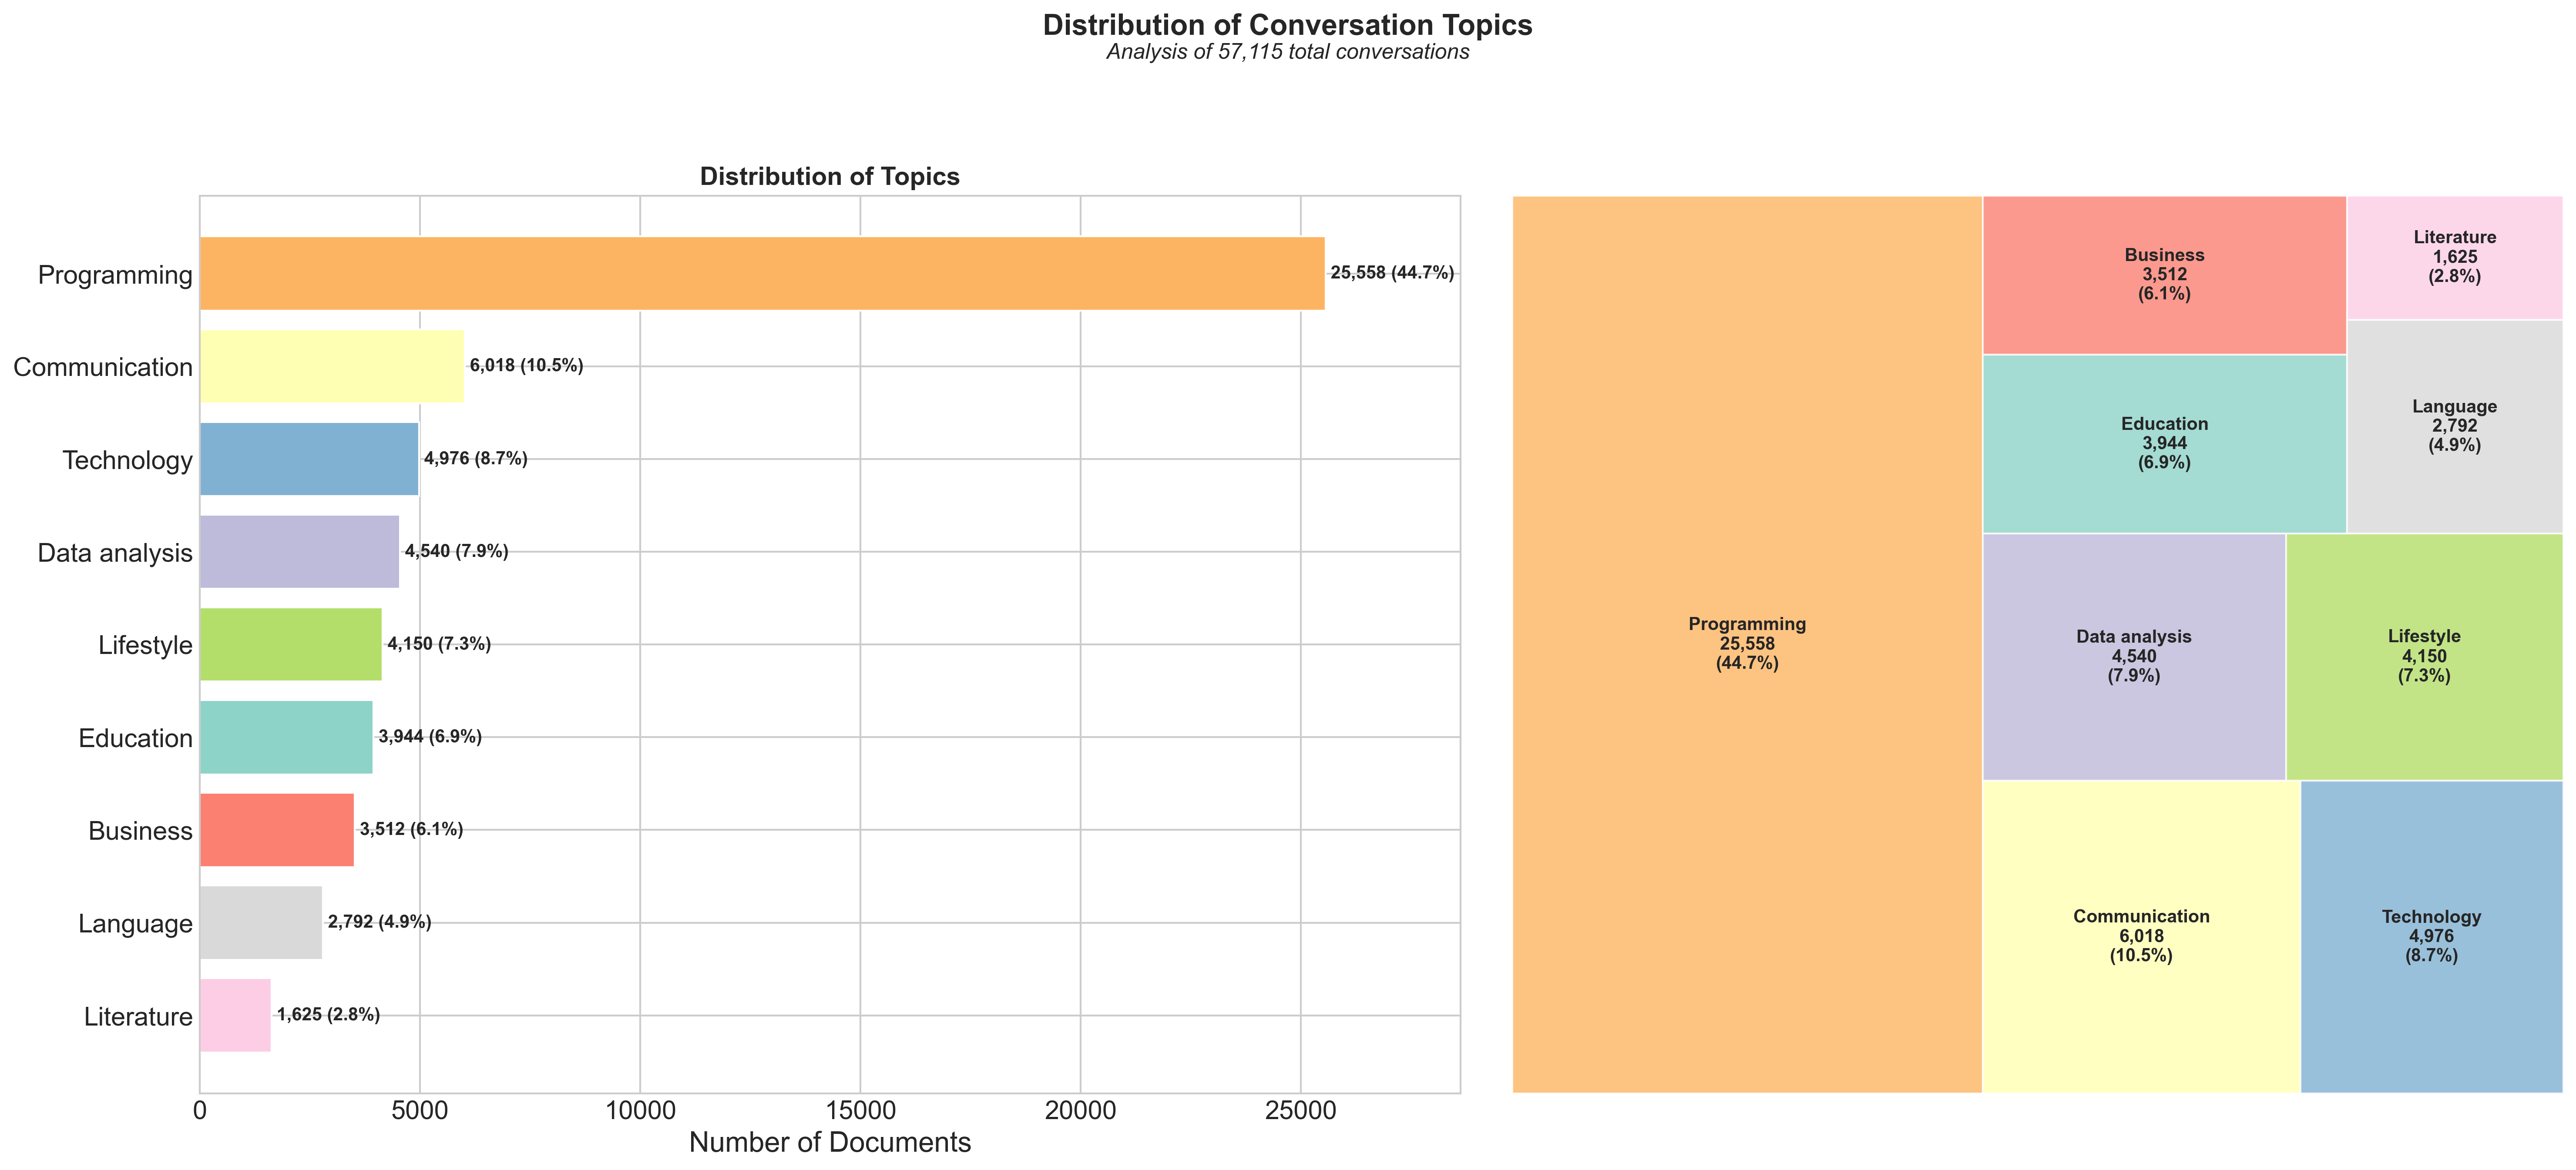

In [38]:
import squarify

def plot_topic_distribution(merged_topic_info, min_percentage=2):
    total_docs = merged_topic_info["topic_size"].sum()
    merged_topic_info["percentage"] = merged_topic_info["topic_size"] / total_docs * 100

    main_topics = merged_topic_info[merged_topic_info["percentage"] >= min_percentage]
    small_topics = merged_topic_info[merged_topic_info["percentage"] < min_percentage]

    if not small_topics.empty:
        other_size = small_topics["topic_size"].sum()
        other_percentage = small_topics["percentage"].sum()
        plot_data = pd.concat(
            [
                main_topics,
                pd.DataFrame(
                    {
                        "label": ["Other"],
                        "topic_size": [other_size],
                        "percentage": [other_percentage],
                        "topic": [-1],
                    }
                ),
            ]
        )
    else:
        plot_data = main_topics

    plot_data = plot_data.sort_values("topic_size", ascending=False)

    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(20, 10), dpi=300, gridspec_kw={"width_ratios": [1.2, 1]}
    )

    colors = [topic_colors.get(label, "#CCCCCC") for label in plot_data["label"]]

    ax1.barh(
        plot_data["label"].map(lambda x: x.capitalize()),
        plot_data["topic_size"],
        color=colors,
    )
    ax1.set_xlabel('Number of Documents')
    ax1.set_title('Distribution of Topics', fontsize=14, weight='bold')
    ax1.set_xlim(0, plot_data["topic_size"].max() * 1.12)
    ax1.invert_yaxis()

    for index, value in enumerate(plot_data["topic_size"]):
        ax1.text(value, index, f' {value:,} ({plot_data["percentage"].iloc[index]:.1f}%)', va='center', fontsize=10, weight='bold')

    sizes = plot_data["topic_size"].values
    labels = [
        f"{label.capitalize()}\n{size:,}\n({pct:.1f}%)"
        for label, size, pct in zip(
            plot_data["label"], plot_data["topic_size"], plot_data["percentage"]
        )
    ]

    squarify.plot(
        sizes=sizes,
        label=labels,
        color=colors,
        alpha=0.8,
        text_kwargs={"fontsize": 10, "weight": "bold"},
        ax=ax2,
    )
    ax2.axis("off")

    fig.suptitle(
        "Distribution of Conversation Topics", fontsize=16, weight="bold", y=0.95
    )
    plt.figtext(
        0.5,
        0.915,
        f"Analysis of {total_docs:,} total conversations",
        ha="center",
        fontsize=12,
        style="italic",
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.90])
    plt.show()

plot_topic_distribution(topic_info_labeled, min_percentage=1)

In [60]:
def get_avg_message_length(post_number, df_expanded):
    conversation = df_expanded[df_expanded["post_number"] == post_number]
    return np.mean([len(str(msg)) for msg in conversation["message"]])


topic_avg_lengths = (
    fast_topic_df.groupby("topic")
    .agg(
        {
            "post_number": lambda x: np.mean(
                [get_avg_message_length(pn, df_expanded) for pn in x]
            )
        }
    )
    .reset_index()
)
topic_avg_lengths = topic_avg_lengths.merge(
    topic_info_labeled[["topic", "label"]], on="topic", how="left"
)
topic_avg_lengths = topic_avg_lengths.sort_values("post_number", ascending=True)

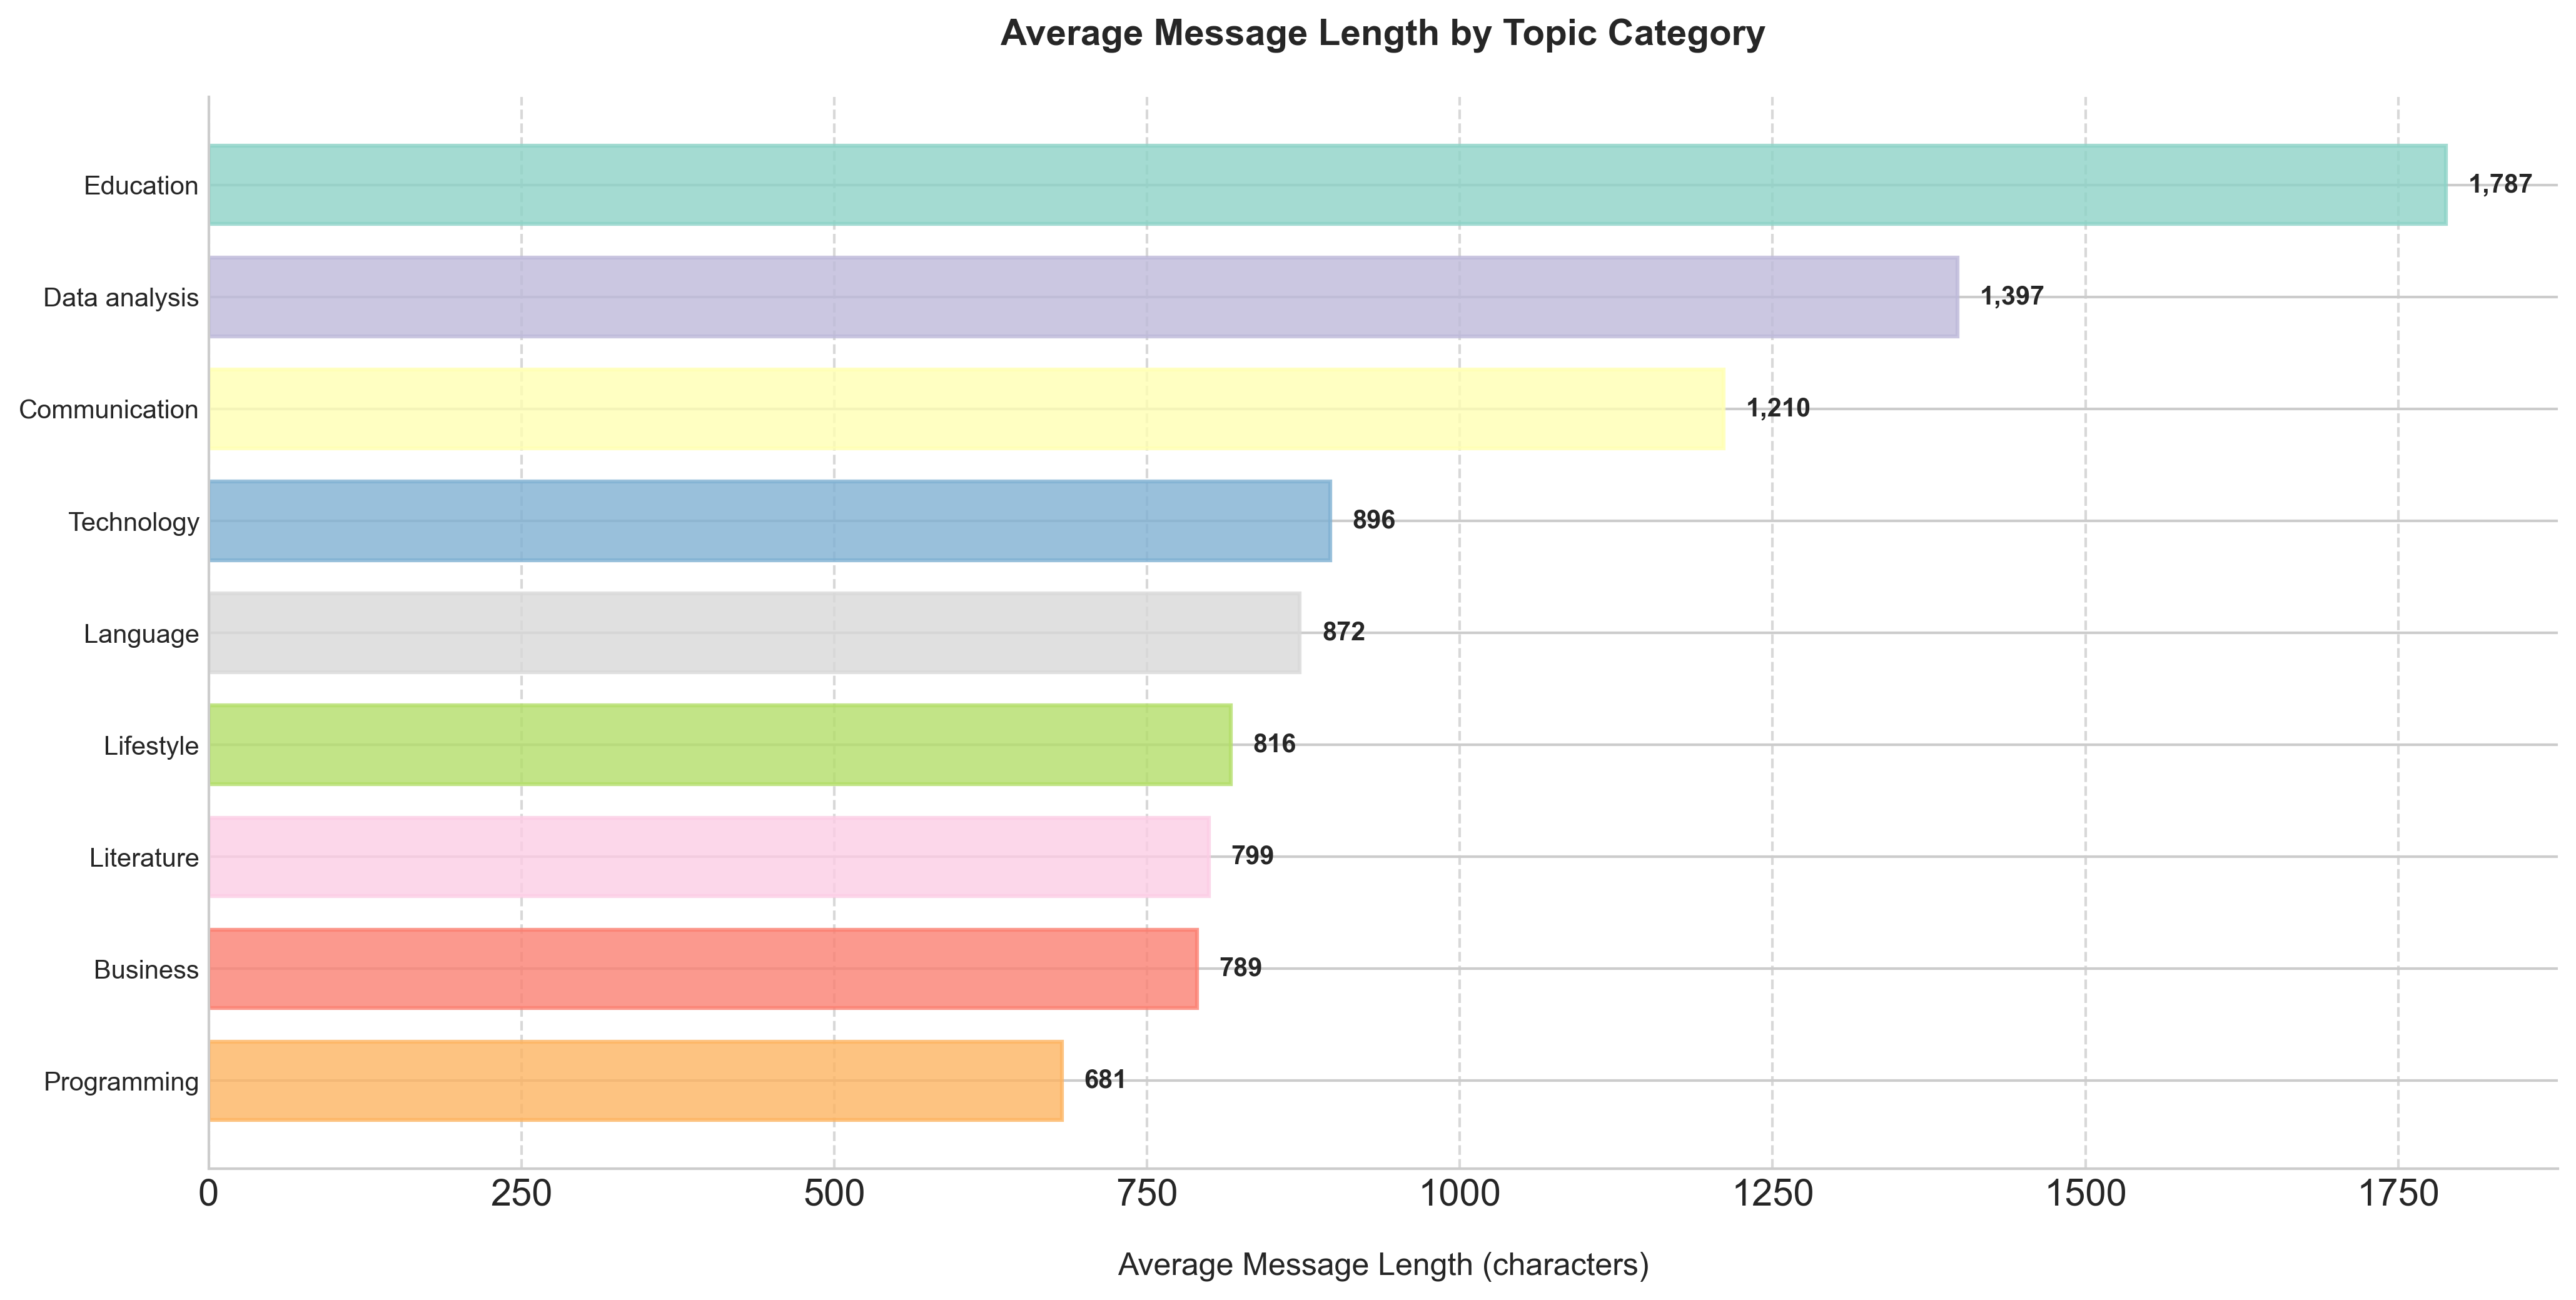

In [62]:
def plot_topic_message_lengths(topic_avg_lengths, topic_info_labeled):
    topic_mapping = topic_info_labeled.set_index("topic")["label"].to_dict()
    topic_avg_lengths["merged_label"] = topic_avg_lengths["topic"].map(topic_mapping)

    plot_data = topic_avg_lengths.sort_values("post_number", ascending=True)

    fig, ax = plt.subplots(figsize=(14, 8), dpi=300)

    bars = ax.barh(
        range(len(plot_data)),
        plot_data["post_number"],
        height=0.7,
        alpha=0.8,
        edgecolor="white",
        linewidth=1.5,
    )

    max_width = plot_data["post_number"].max()
    for i, bar in enumerate(bars):
        bar.set_color(topic_colors.get(plot_data["merged_label"].iloc[i], "#CCCCCC"))
        width = bar.get_width()
        ax.text(
            width + (max_width * 0.01),
            bar.get_y() + bar.get_height() / 2,
            f"{int(width):,}",
            va="center",
            ha="left",
            fontsize=10,
            weight="bold",
        )

    ax.set_xlabel("Average Message Length (characters)", fontsize=12, labelpad=15)
    ax.set_title(
        "Average Message Length by Topic Category", fontsize=14, pad=20, weight="bold"
    )
    ax.set_yticks(range(len(plot_data)))
    labels = [f"{label.capitalize()}" for label in plot_data["merged_label"]]
    ax.set_yticklabels(labels, fontsize=10)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="x", linestyle="--", alpha=0.3, color="gray")
    ax.set_axisbelow(True)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


plot_topic_message_lengths(topic_avg_lengths, topic_info_labeled)


In [246]:
def get_avg_lengths_by_role(post_number, df_expanded):
    conversation = df_expanded[df_expanded["post_number"] == post_number]

    gpt_msgs = conversation[conversation["user"] == "Chat GPT"]["message"]
    user_msgs = conversation[conversation["user"] == "Anonymous"]["message"]

    gpt_avg = np.mean([len(str(msg)) for msg in gpt_msgs]) if len(gpt_msgs) > 0 else 0
    user_avg = (
        np.mean([len(str(msg)) for msg in user_msgs]) if len(user_msgs) > 0 else 0
    )

    return gpt_avg, user_avg


gpt_user_avg_topic_length_df = (
    fast_topic_df.groupby("topic")
    .agg(
        {
            "post_number": lambda x: [
                get_avg_lengths_by_role(pn, df_expanded) for pn in x
            ]
        }
    )
    .reset_index()
)

gpt_user_avg_topic_length_df["gpt_avg"] = gpt_user_avg_topic_length_df[
    "post_number"
].apply(lambda x: np.mean([t[0] for t in x]))
gpt_user_avg_topic_length_df["user_avg"] = gpt_user_avg_topic_length_df[
    "post_number"
].apply(lambda x: np.mean([t[1] for t in x]))
gpt_user_avg_topic_length_df = gpt_user_avg_topic_length_df.drop("post_number", axis=1)

message_length_by_topic_df = gpt_user_avg_topic_length_df.merge(
    topic_info_labeled[["topic", "label"]], on="topic", how="left"
)

message_length_by_topic_df["ratio"] = (
    message_length_by_topic_df["gpt_avg"] / message_length_by_topic_df["user_avg"]
)
message_length_by_topic_df = message_length_by_topic_df.sort_values(
    "ratio", ascending=True
)

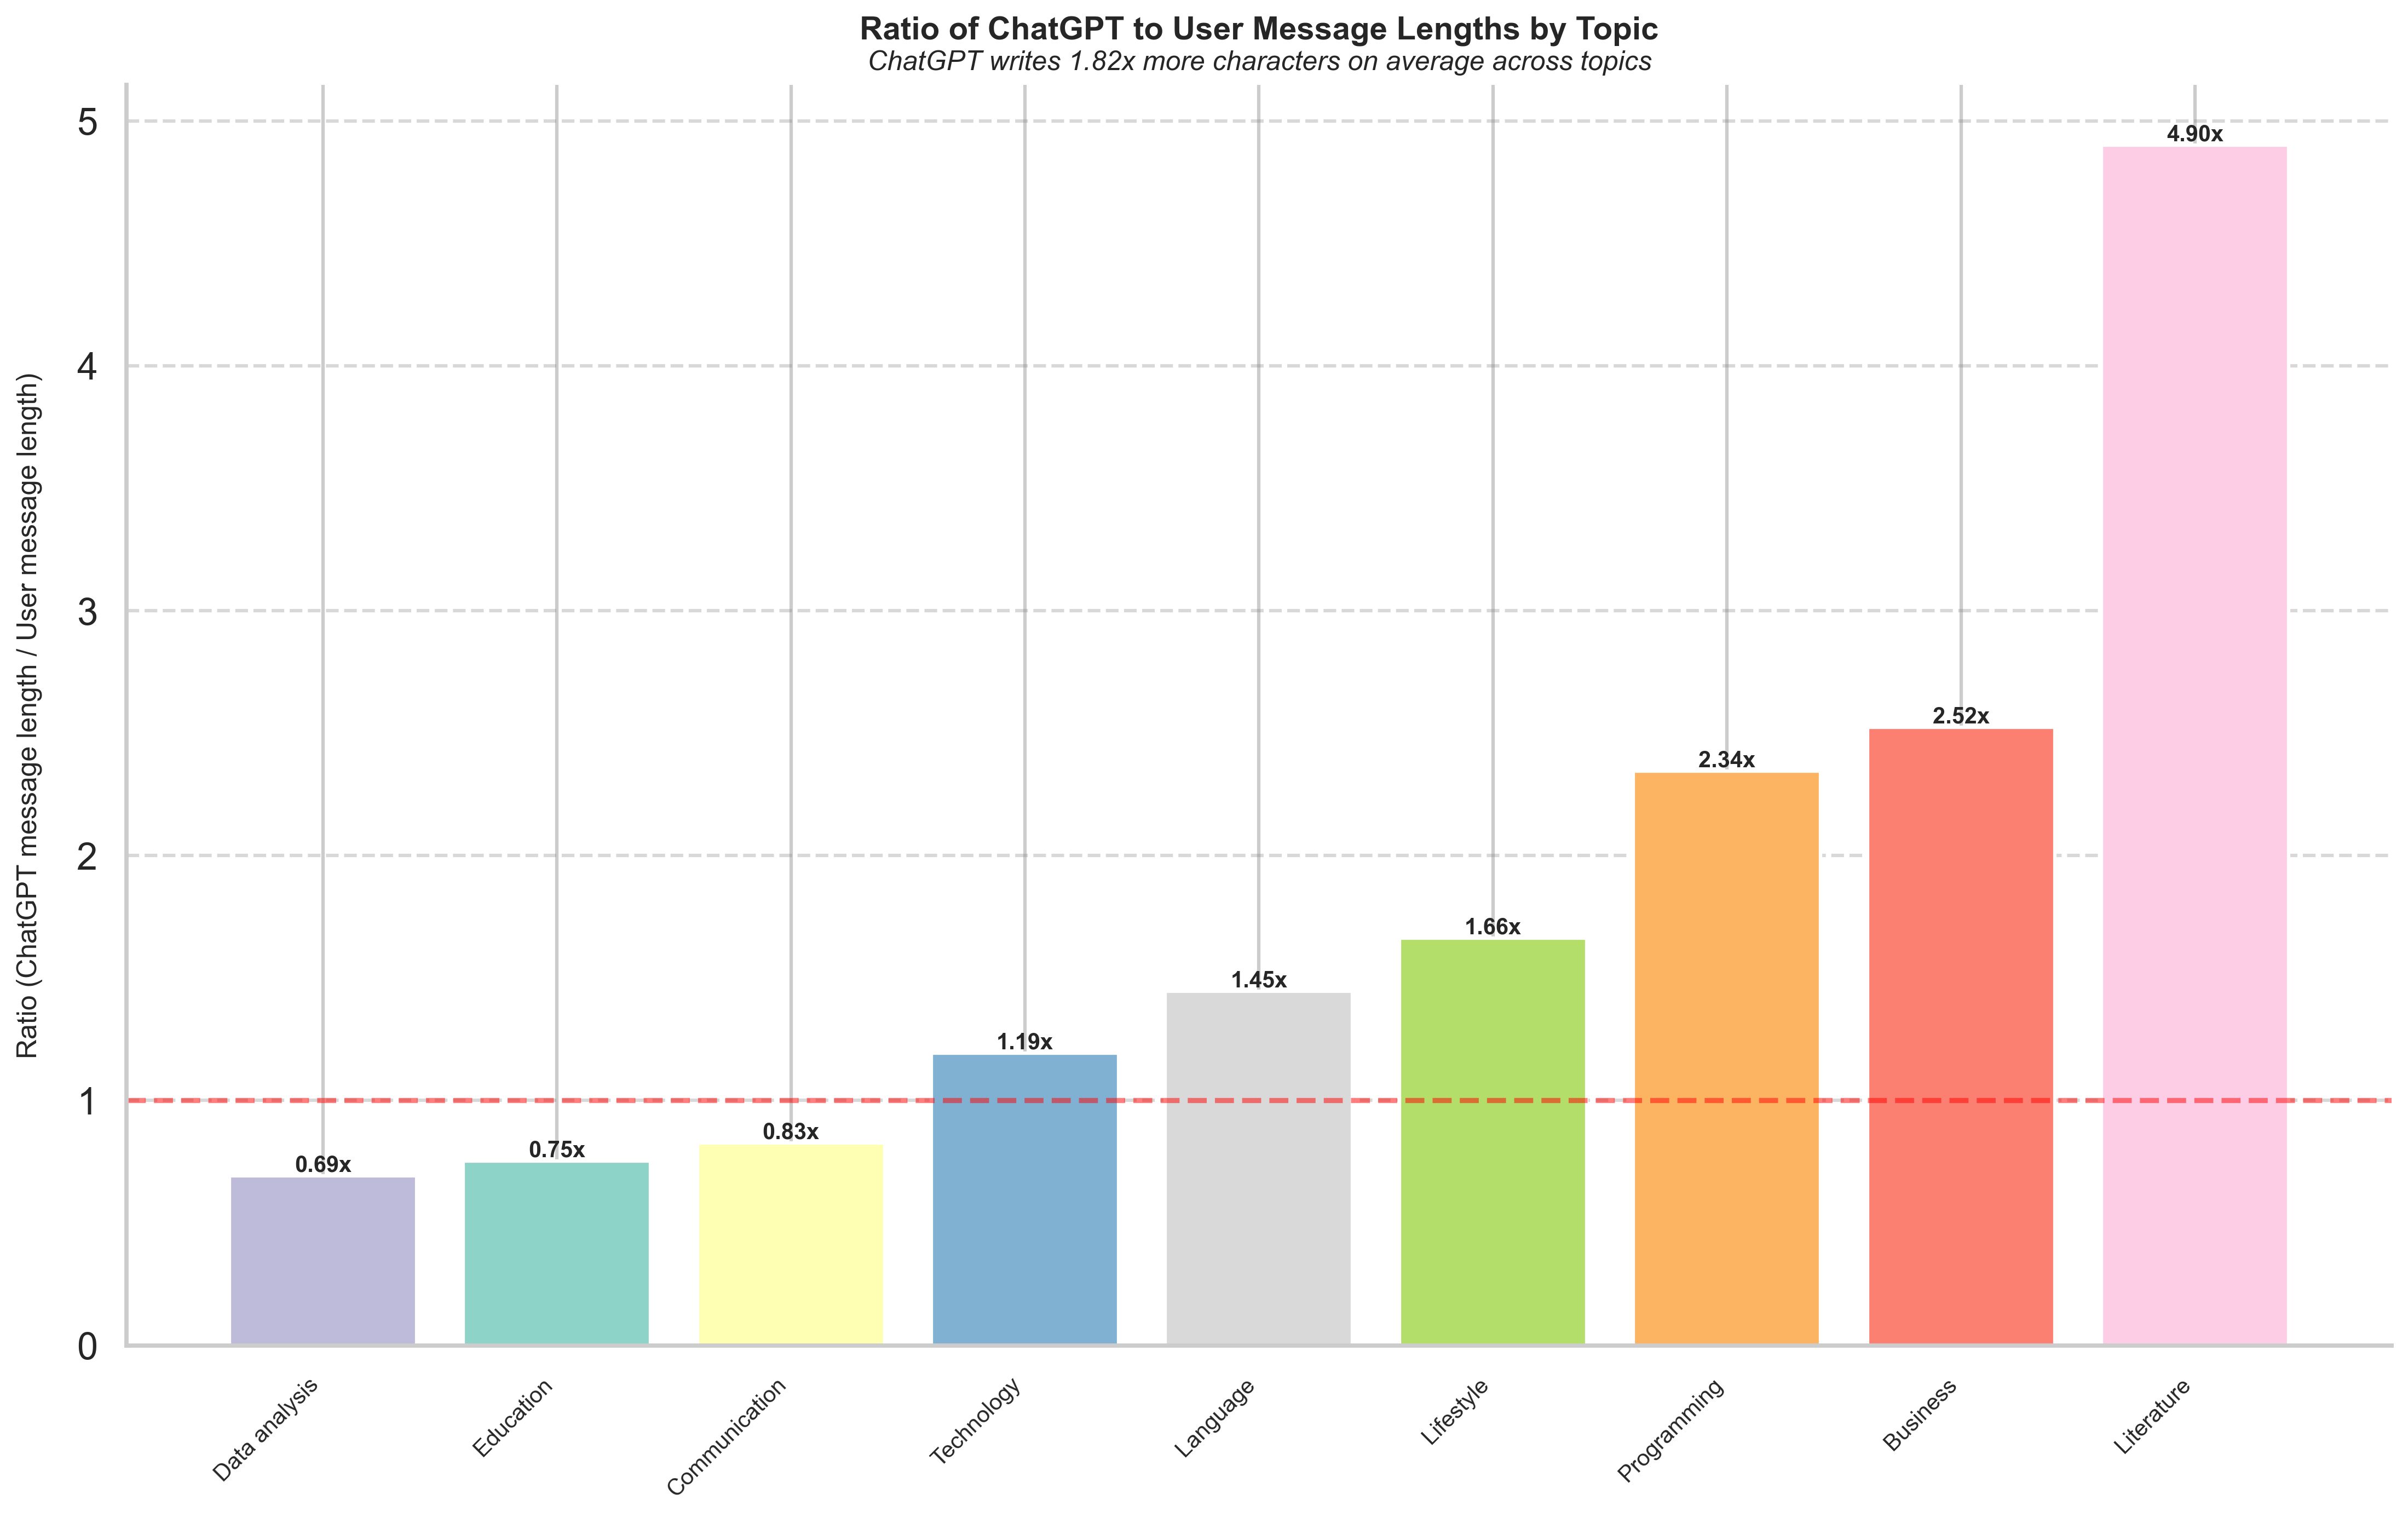

In [698]:
def plot_message_ratio(message_length_by_topic_df):
    overall_ratio = message_length_by_topic_df["ratio"].mean()

    fig, ax = plt.subplots(figsize=(15, 10), dpi=300)

    plot_data = message_length_by_topic_df.sort_values("ratio", ascending=True)

    bars = ax.bar(
        range(len(plot_data)),
        plot_data["ratio"],
        width=0.8,
        edgecolor="white",
        linewidth=1.5,
        color=[topic_colors.get(label, "#CCCCCC") for label in plot_data["label"]],
    )

    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}x",
            ha="center",
            va="bottom",
            fontsize=10,
            weight="bold",
        )

    ax.set_ylabel(
        "Ratio (ChatGPT message length / User message length)", fontsize=12, labelpad=15
    )

    ax.set_title(
        "Ratio of ChatGPT to User Message Lengths by Topic",
        fontsize=14,
        pad=20,
        weight="bold",
    )
    plt.suptitle(
        f"ChatGPT writes {overall_ratio:.2f}x more characters on average across topics",
        fontsize=12,
        x=0.5225,
        y=0.91,
        style="italic",
    )

    ax.axhline(y=1, color="red", linestyle="--", alpha=0.5, label="1:1 ratio (1x)")

    labels = [f"{label.capitalize()}" for label in plot_data["label"]]
    ax.set_xticks(range(len(plot_data)))
    ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=10)

    ax.grid(axis="y", linestyle="--", alpha=0.3, color="gray")
    ax.set_axisbelow(True)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()


plot_message_ratio(message_length_by_topic_df)

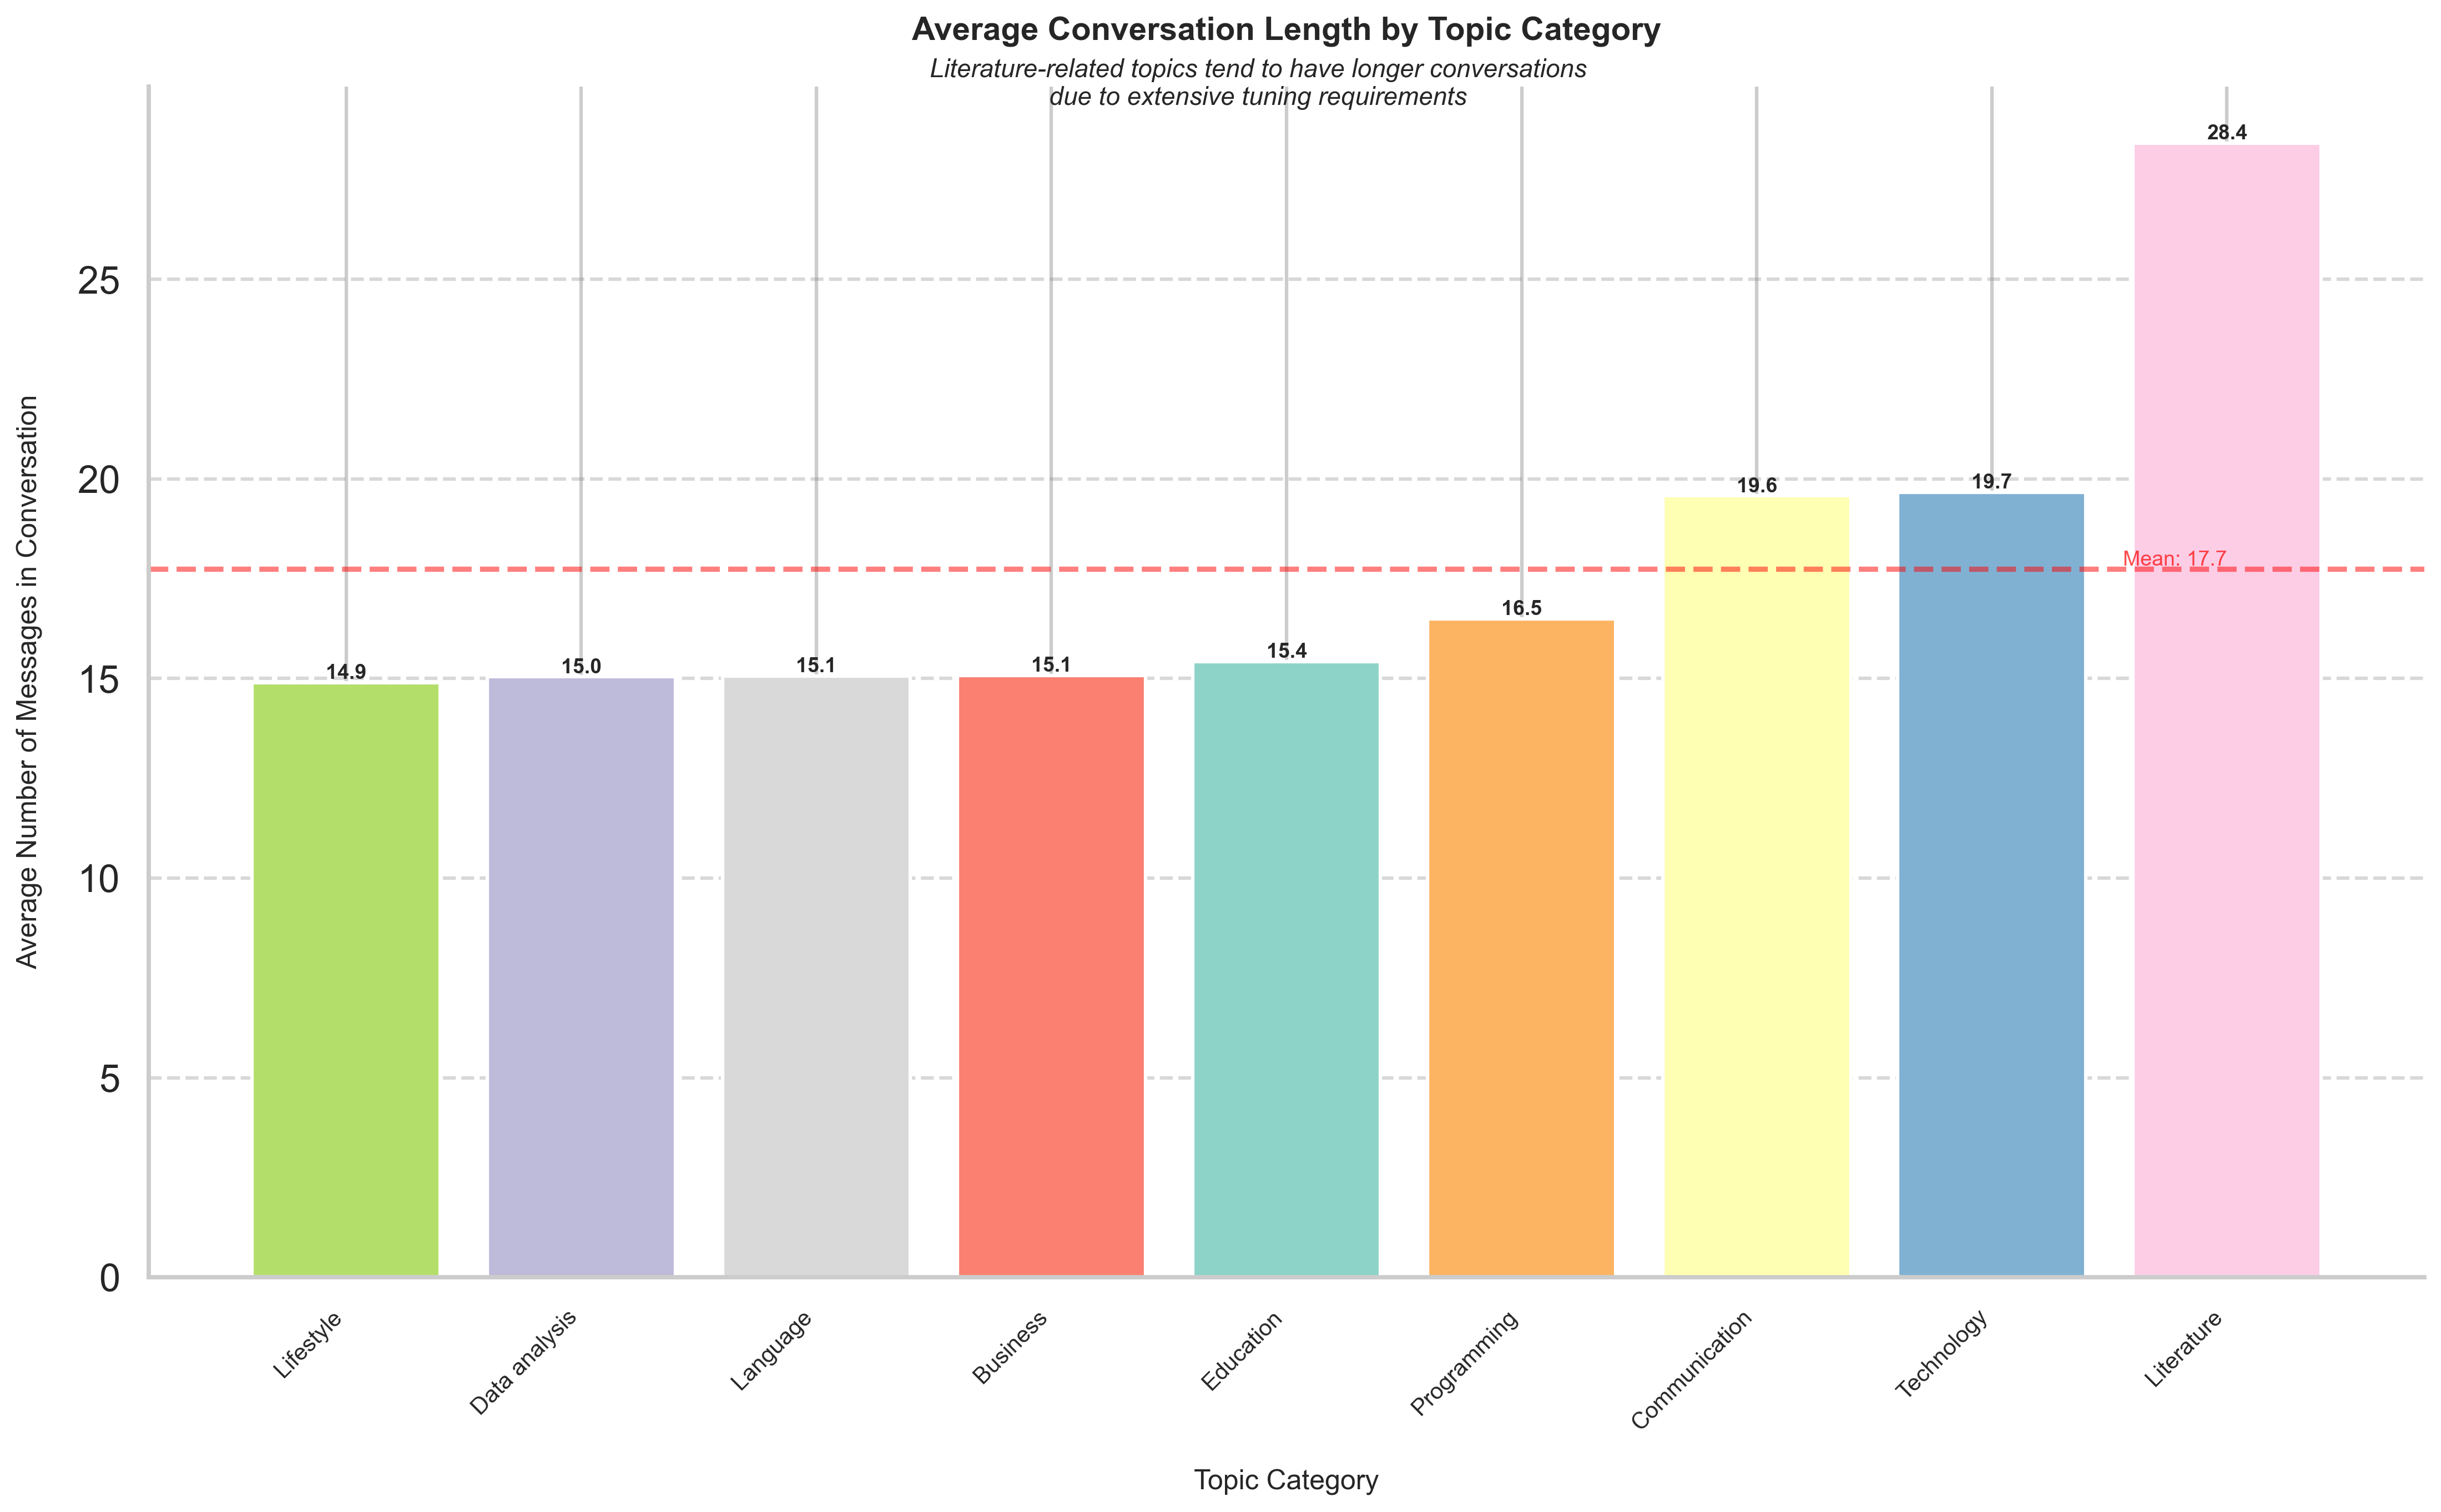

In [636]:
def plot_conversation_lengths(df_expanded, fast_topic_df, topic_info_labeled):
    conversation_lengths = df_expanded.groupby("post_number").size().to_dict()
    topic_sizes = fast_topic_df["topic"].value_counts().to_dict()

    topic_stats = {}
    for topic in fast_topic_df["topic"].unique():
        topic_posts = fast_topic_df[fast_topic_df["topic"] == topic]["post_number"]
        lengths = [conversation_lengths.get(post, 0) for post in topic_posts]
        topic_stats[topic] = {
            "mean_length": np.mean(lengths),
            "count": topic_sizes[topic],
        }

    plot_data = pd.DataFrame.from_dict(topic_stats, orient="index")
    plot_data = plot_data.reset_index().rename(columns={"index": "topic"})
    plot_data = plot_data.merge(
        topic_info_labeled[["topic", "label"]], on="topic", how="left"
    )
    plot_data = plot_data.sort_values("mean_length", ascending=True)

    fig, ax = plt.subplots(figsize=(15, 10), dpi=300)

    colors = [topic_colors.get(label, "#CCCCCC") for label in plot_data["label"]]

    bars = ax.bar(
        range(len(plot_data)),
        plot_data["mean_length"],
        width=0.8,
        edgecolor="white",
        linewidth=1.5,
        color=colors,
    )

    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.1f}",
            ha="center",
            va="bottom",
            fontsize=9,
            weight="bold",
        )

    ax.set_ylabel(
        "Average Number of Messages in Conversation", fontsize=12, labelpad=15
    )
    ax.set_xlabel("Topic Category", fontsize=12, labelpad=15)

    ax.set_title(
        "Average Conversation Length by Topic Category",
        fontsize=14,
        pad=20,
        weight="bold",
    )
    plt.suptitle(
        "Literature-related topics tend to have longer conversations\ndue to extensive tuning requirements",
        fontsize=11,
        y=0.89,
        x=0.515,
        style="italic",
    )

    labels = [f"{label.capitalize()}" for label in plot_data["label"]]
    ax.set_xticks(range(len(plot_data)))
    ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=10)

    ax.grid(axis="y", linestyle="--", alpha=0.3, color="gray")
    ax.set_axisbelow(True)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    mean_length = plot_data["mean_length"].mean()
    ax.axhline(mean_length, color="red", linestyle="--", alpha=0.5)
    ax.text(
        len(plot_data) - 1,
        mean_length,
        f"Mean: {mean_length:.1f}",
        color="red",
        alpha=0.7,
        fontsize=9,
        ha="right",
        va="bottom",
    )

    plt.tight_layout()
    plt.show()


plot_conversation_lengths(df_expanded, fast_topic_df, topic_info_labeled)

### User Feedback on ChatGPT Responses <a class="anchor" id="user-feedback-analysis"></a>

Checking how accurate ChatGPT was back then by analyzing how many users asked for corrections (dataset from analyzing dates of its gathering contains GPT-3.5, GPT-3.5-Turbo, and a bit of GPT-4).

I'm using again `gpt-4o-mini` to analyze this by giving to it previous chat gpt message, next user message, and asking it to classify whether the user asked for a correction or if they were just continuing the conversation.

_Note: 1% of the messages were feeded to the `gpt-4o-mini` model for analysis._


In [269]:
CORRECTION_ANALYSIS_PATH = "data/correction_analysis.csv"
CORRECTION_ANALYSIS_MODEL = "gpt-4o-mini"
CORRECTION_PROMPT = """You are analyzing whether users are asking ChatGPT to fix/correct its previous response. Evaluate each pair of messages and return your analysis in JSON format.

Rules for analysis:
1. Assess if the user is asking for a correction, clarification, or pointing out errors
2. Look for indicators like "that's wrong", "can you fix", "not what I meant", etc.
3. If unclear or the user is just continuing the conversation, mark accordingly

Categories:
- "fix" = User is asking for corrections or pointing out errors
- "continue" = User is continuing the conversation without requesting fixes
- "unclear" = Cannot determine the intent clearly

Input format:
[0] ChatGPT: <previous response>
    User: <next message>
[1] ChatGPT: <previous response>
    User: <next message>
...and so on

Required output format:
{
    "results": {
        "0": "fix|continue|unclear",
        "1": "fix|continue|unclear",
        ...
    }
}

Example input:
[0] ChatGPT: Here's how to solve x + 2 = 5...
    User: That's not correct, x should be 3 not 7

[1] ChatGPT: Python is a programming language...
    User: Great, can you show me some examples?

Example output:
{
    "results": {
        "0": "fix",
        "1": "continue"
    }
}"""

In [ ]:
from pydantic import BaseModel, Field
import json
from typing import Dict, Literal


class CorrectionAnalysis(BaseModel):
    results: Dict[str, Literal["fix", "continue", "unclear"]] = Field(
        description="Dictionary mapping message indices to correction request types"
    )

    model_config = {
        "json_schema_extra": {
            "examples": [{"results": {"0": "fix", "1": "continue", "2": "unclear"}}]
        }
    }


def analyze_correction_requests(
    df_expanded,
    batch_size=50,
    max_workers=4,
    sample_size=-1,
) -> pd.DataFrame:
    if Path(CORRECTION_ANALYSIS_PATH).exists():
        print("Loading cached correction analysis results...")
        return pd.read_csv(CORRECTION_ANALYSIS_PATH)

    df_temp = df_expanded.copy()
    df_temp["prev_user"] = df_temp.groupby("post_number")["user"].shift(1)
    df_temp["prev_message"] = df_temp.groupby("post_number")["message"].shift(1)

    message_pairs = df_temp[
        (df_temp["user"] == "Anonymous") & (df_temp["prev_user"] == "Chat GPT")
    ].copy()

    if sample_size != -1:
        message_pairs = message_pairs.sample(
            n=min(sample_size, len(message_pairs)), random_state=42
        ).sort_index()

    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    def process_batch(pairs):
        try:
            formatted_pairs = "\n".join(
                f"[{i}] ChatGPT: {row.prev_message[:200]}\n    User: {row.message[:200]}"
                for i, row in enumerate(pairs.itertuples())
            )

            response = client.chat.completions.create(
                model=CORRECTION_ANALYSIS_MODEL,
                messages=[
                    {"role": "system", "content": CORRECTION_PROMPT},
                    {"role": "user", "content": formatted_pairs},
                ],
                response_format={"type": "json_object"},
                temperature=0.1,
            )

            result = json.loads(response.choices[0].message.content)
            return list(CorrectionAnalysis(**result).results.values())
        except Exception as e:
            print(f"Error processing batch: {e}")
            return ["unclear"] * len(pairs)

    batch_indices = list(range(0, len(message_pairs), batch_size))
    message_batches = [
        (i, message_pairs.iloc[i : i + batch_size]) for i in batch_indices
    ]

    results = [None] * len(message_pairs)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(process_batch, batch): idx for idx, batch in message_batches
        }

        for future in tqdm(
            as_completed(futures),
            total=len(futures),
            desc="Analyzing correction requests",
            ncols=100,
        ):
            idx = futures[future]
            batch_results = future.result()
            batch_length = len(batch_results)
            results[idx : idx + batch_length] = batch_results

    correction_df = pd.DataFrame(
        {
            "post_number": message_pairs["post_number"].values,
            "message_order": message_pairs["message_order"].values,
            "chatgpt_message": message_pairs["prev_message"].values,
            "user_message": message_pairs["message"].values,
            "correction_type": results,
        }
    )

    os.makedirs(os.path.dirname(CORRECTION_ANALYSIS_PATH), exist_ok=True)
    correction_df.to_csv(CORRECTION_ANALYSIS_PATH, index=False)

    return correction_df


correction_results = analyze_correction_requests(
    df_expanded,
    sample_size=10000,
    batch_size=20,
)

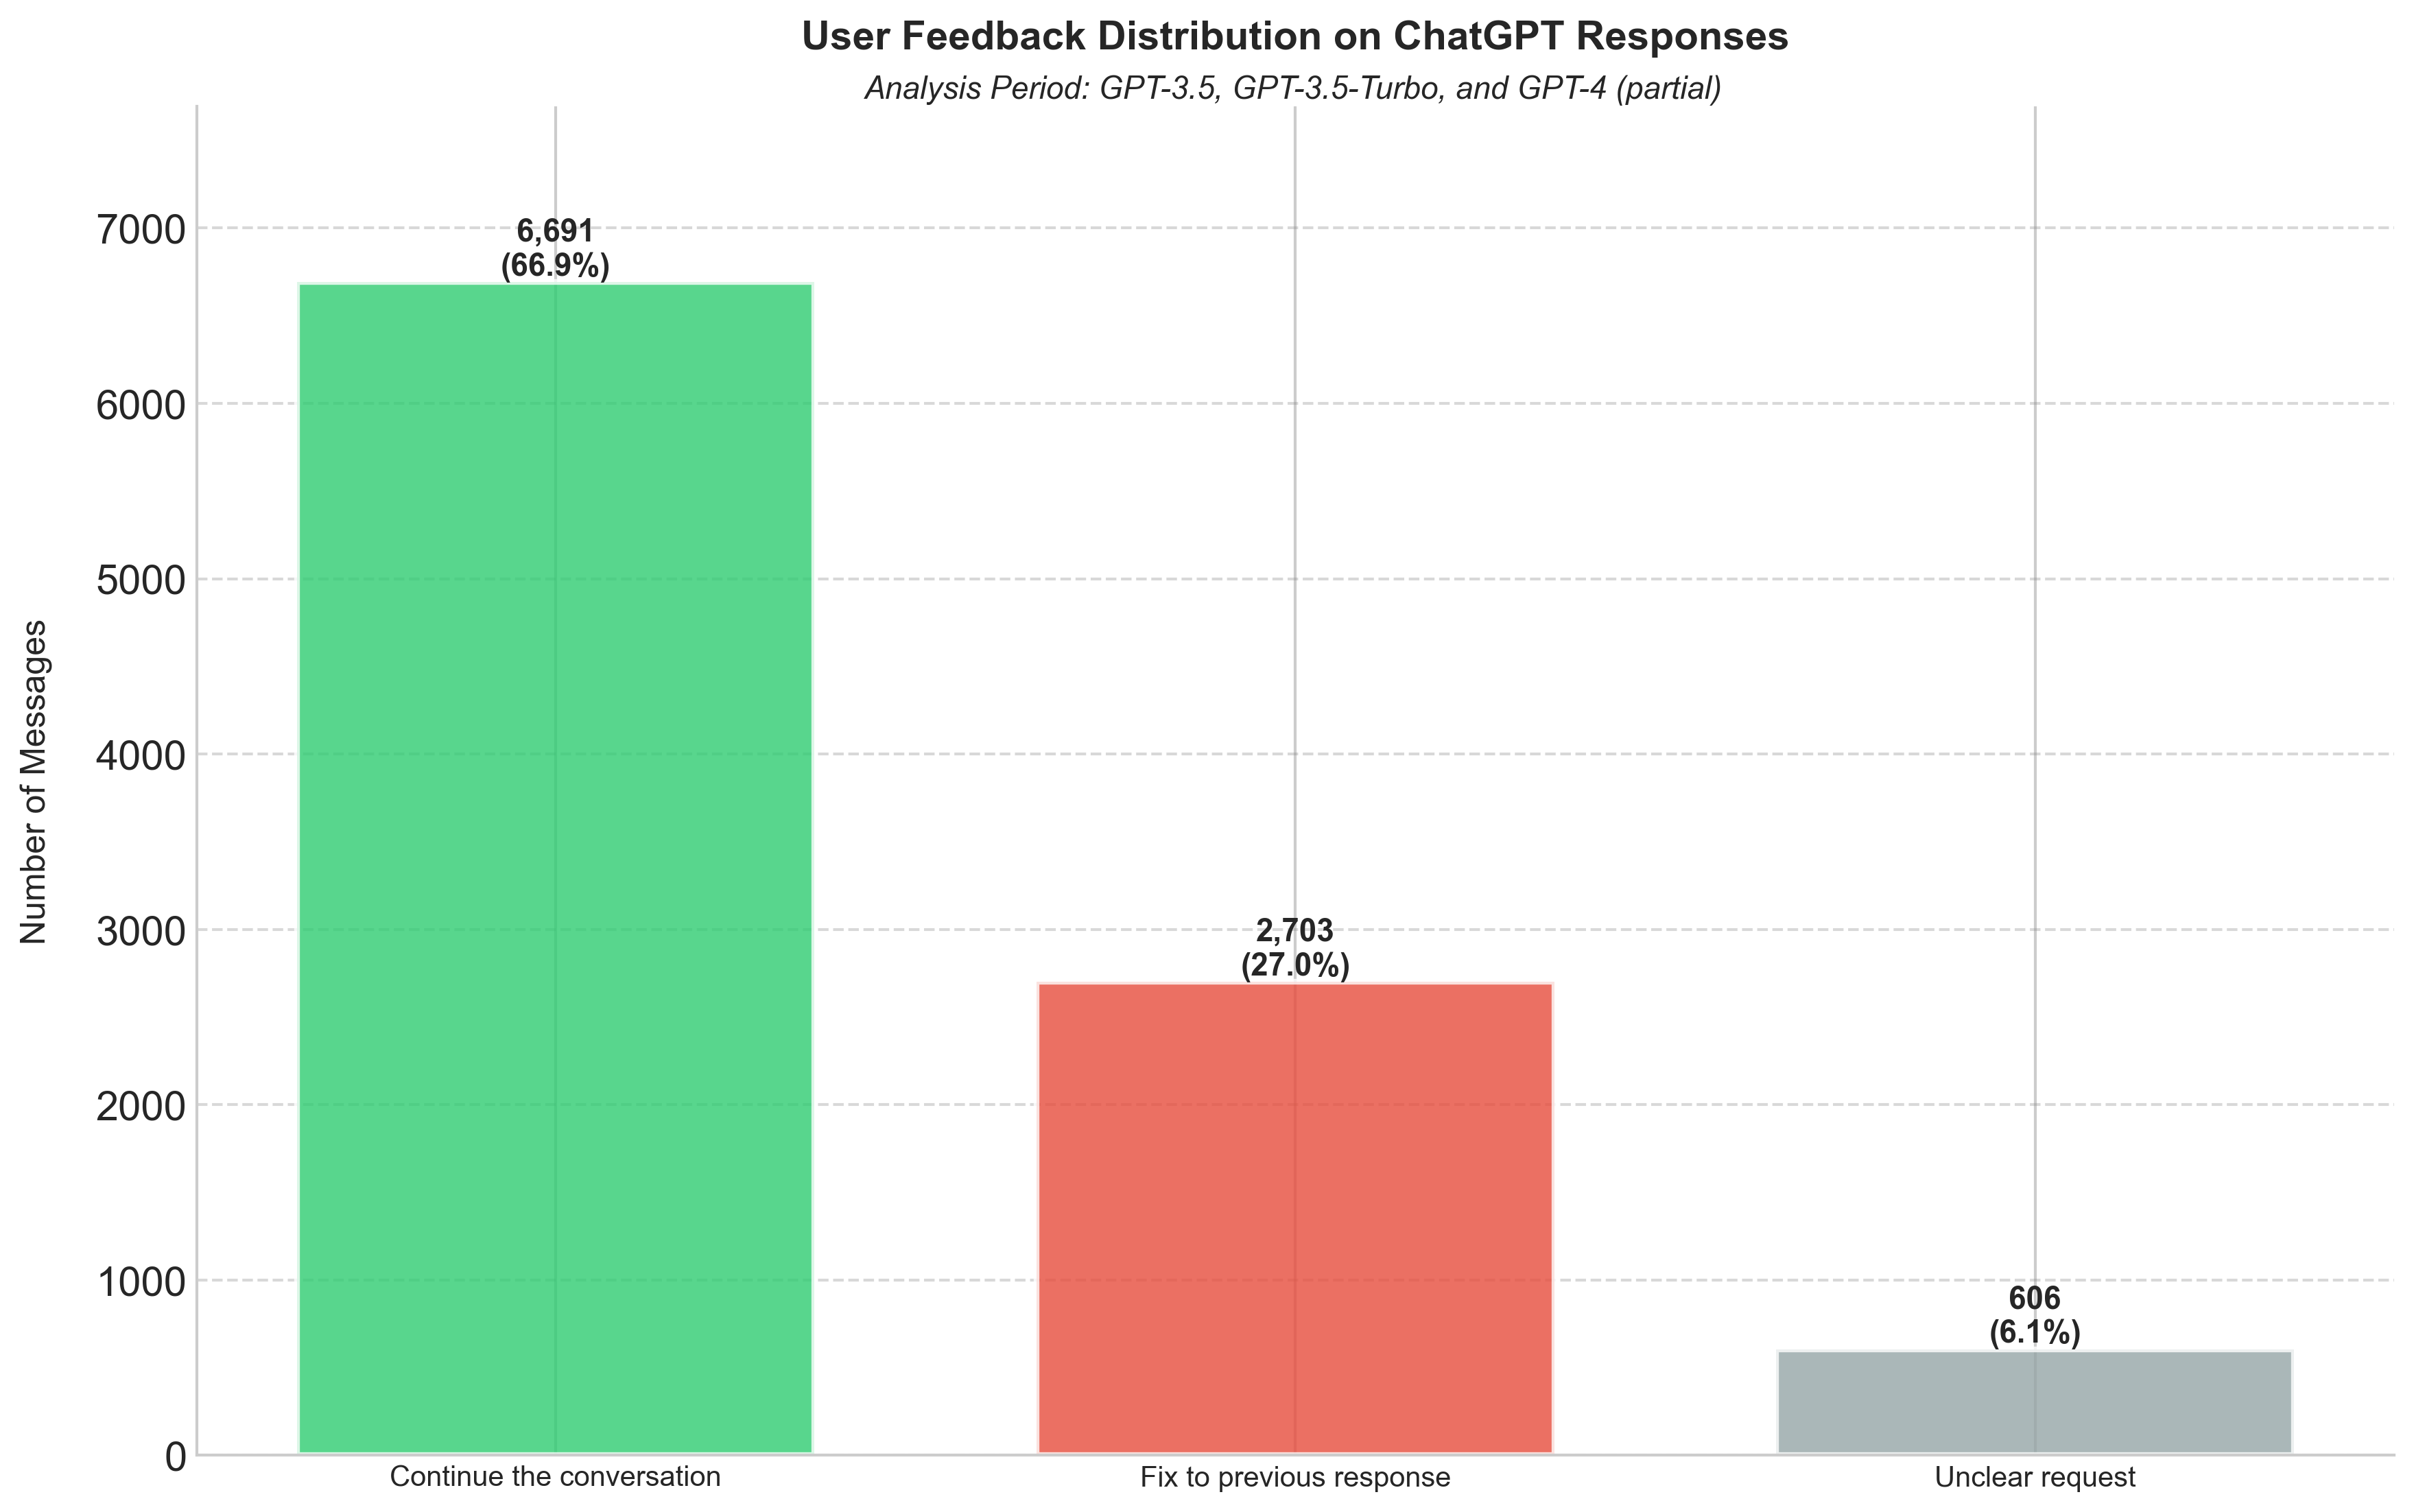

In [282]:
correction_counts = correction_results["correction_type"].value_counts()
total_corrections = len(correction_results)

fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

colors = ["#2ecc71", "#e74c3c", "#95a5a6"]

bars = ax.bar(
    range(len(correction_counts)),
    correction_counts.values,
    width=0.7,
    color=colors,
    edgecolor="white",
    linewidth=2,
    alpha=0.8,
)

for bar in bars:
    height = bar.get_height()
    percentage = height / total_corrections * 100
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height):,}\n({percentage:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=11,
        weight="bold",
    )

ax.set_ylabel("Number of Messages", fontsize=12, labelpad=15)

ax.set_title(
    "User Feedback Distribution on ChatGPT Responses",
    fontsize=14,
    pad=20,
    weight="bold",
)
plt.suptitle(
    "Analysis Period: GPT-3.5, GPT-3.5-Turbo, and GPT-4 (partial)",
    fontsize=11,
    x=0.535,
    y=0.89,
    style="italic",
)

labels = ["Continue the conversation", "Fix to previous response", "Unclear request"]
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize=10)

ax.grid(axis="y", linestyle="--", alpha=0.3, color="gray")
ax.set_axisbelow(True)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_ylim(0, correction_counts.max() * 1.15)

plt.tight_layout()
plt.show()

In [315]:
print("\nExamples of correction requests:")
correction_examples = correction_results[
    correction_results["correction_type"] == "fix"
].head()
for _, row in correction_examples.iterrows():
    print("\nChatGPT:", row["chatgpt_message"][:100], "...")
    print("User:", row["user_message"][:100], "...")


Examples of correction requests:

ChatGPT: Here is a complete C++ implementation for FizzBuzz: This program uses a for loop to iterate from 1 t ...
User: Great, now change the code so that the iteration length is provided by the user through stdin. ...

ChatGPT: Here is a modified version of the FizzBuzz program that checks for a valid iteration length and exit ...
User: Instead of checking for "*endptr != '\0'", wouldn't it be enough to just check for "endptr != &argv[ ...

ChatGPT: The name of the school that Harmony Hearts attend is not specified in the previous story. It would b ...
User: suggest a name of their school ...

ChatGPT: I apologize for the misunderstanding. Here is a revised syllabus that focuses more on the intellectu ...
User: I think Week 6 - 8 could be more rigorous, more esoteric, and more theoretical, while exploring expl ...

ChatGPT: It is not possible for me to combine all the best elements of each theory and form a new one, as it  ...
User: provide a theoret

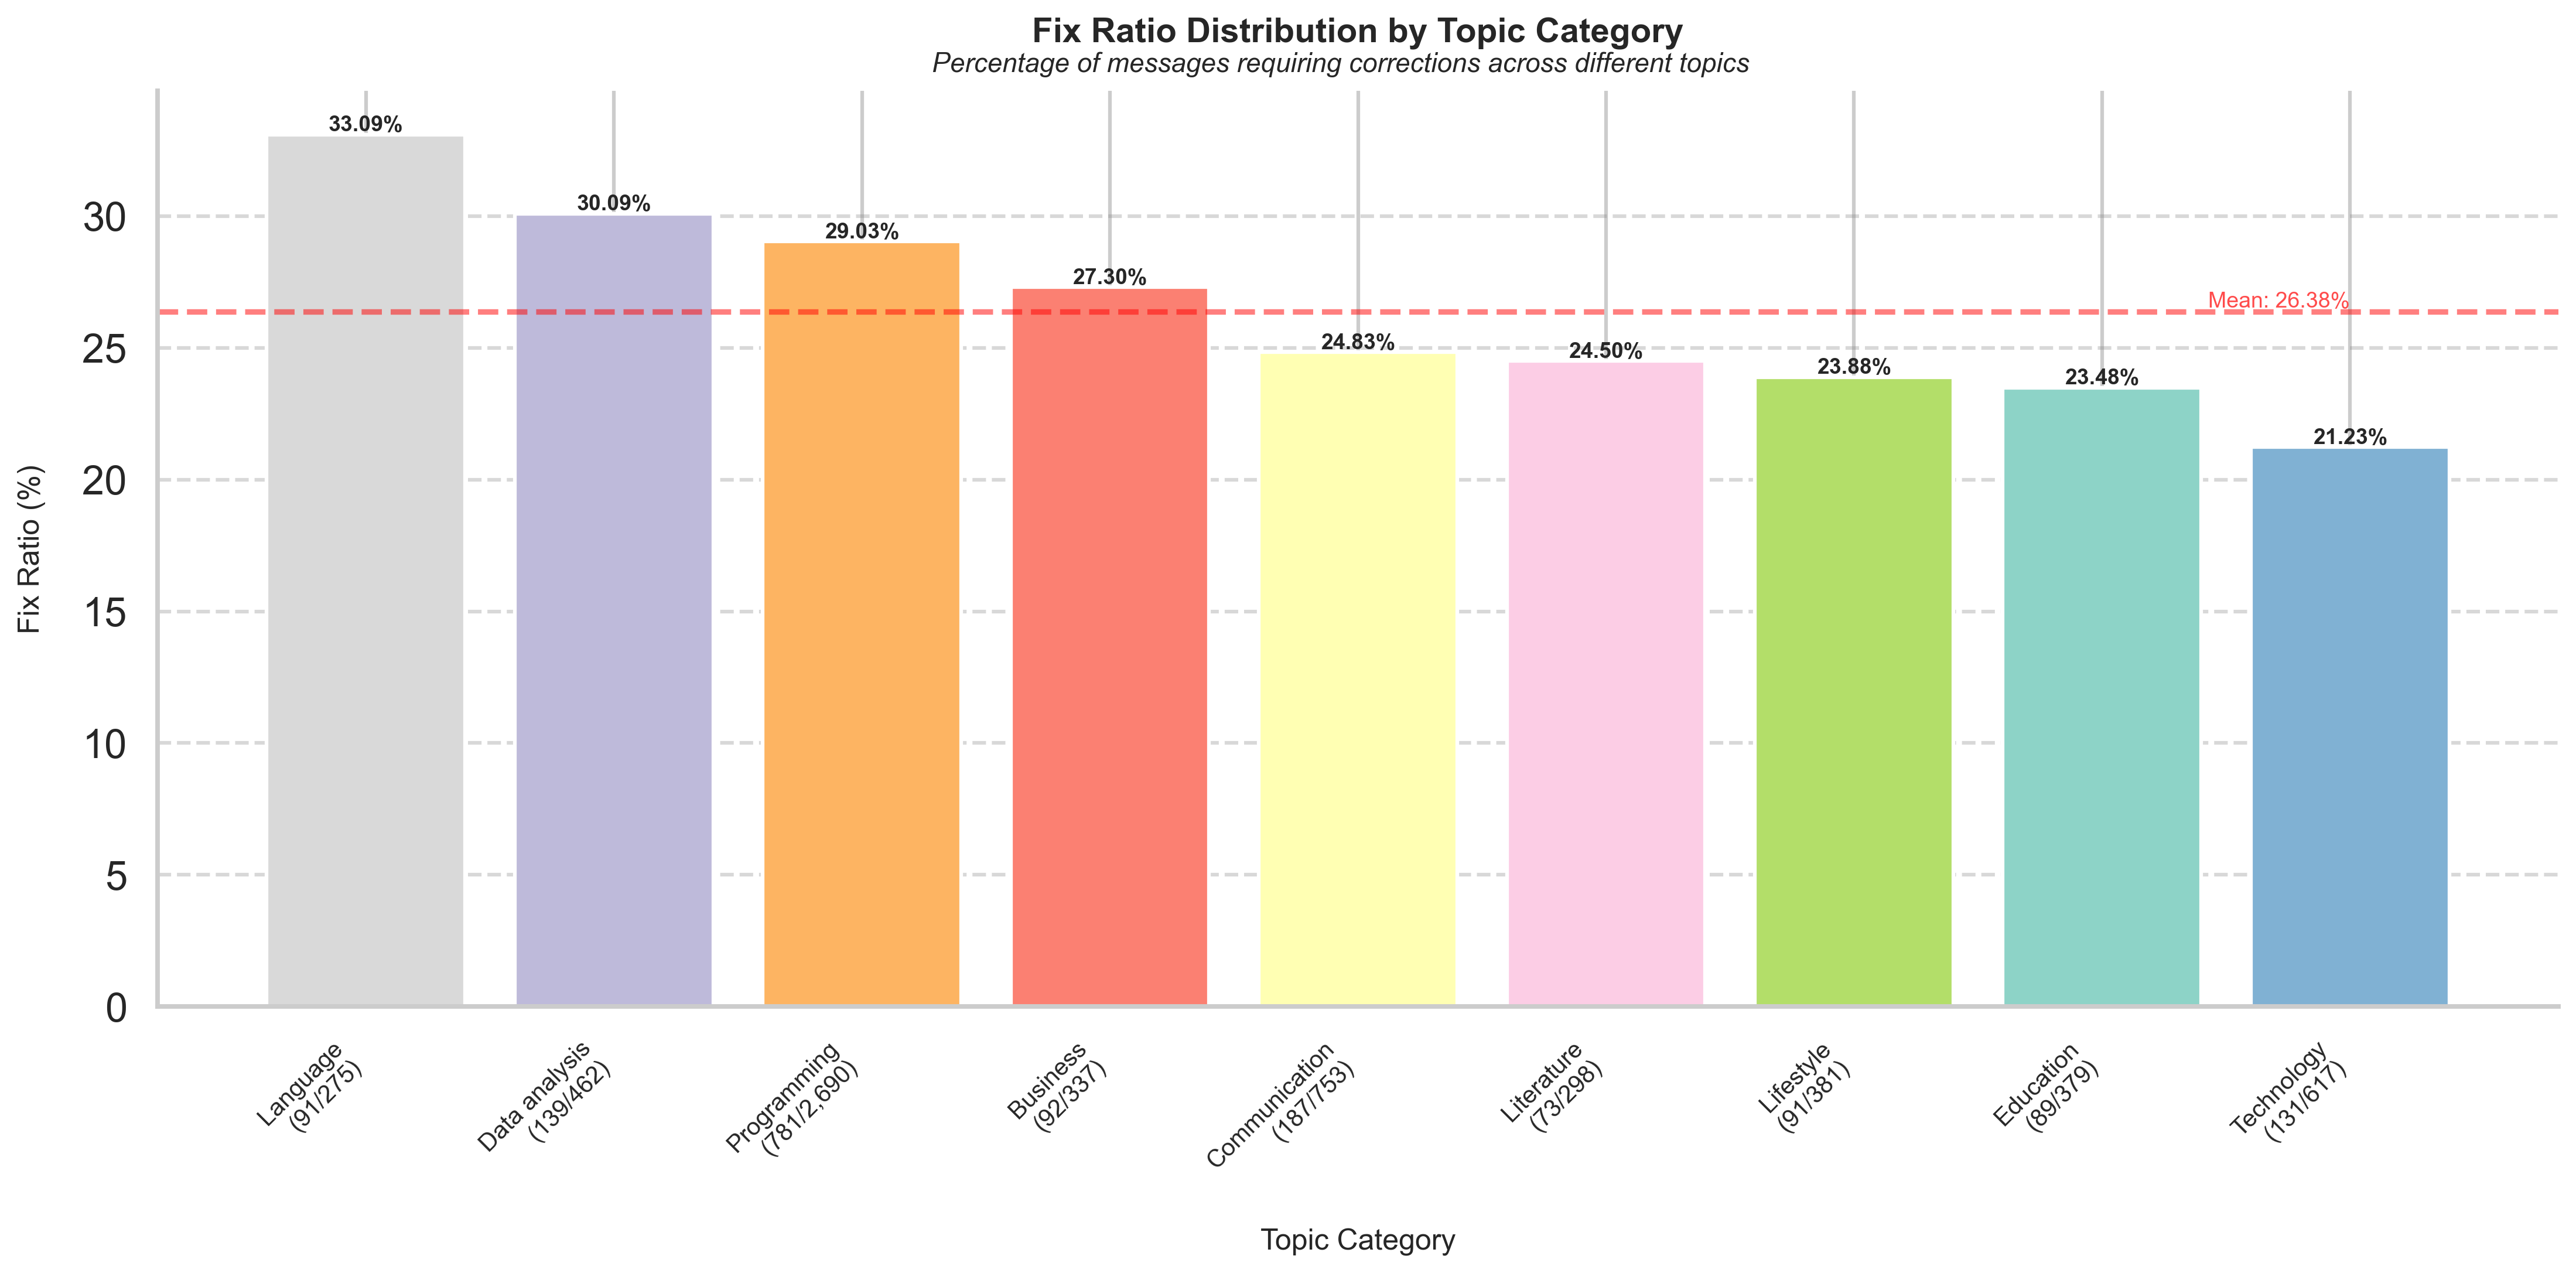

In [693]:
topic_fixes = {}
for topic in fast_topic_df["topic"].unique():
    topic_posts = set(fast_topic_df[fast_topic_df["topic"] == topic]["post_number"])
    topic_corrections = correction_results[
        correction_results["post_number"].isin(topic_posts)
    ]

    fixes = len(topic_corrections[topic_corrections["correction_type"] == "fix"])
    total_analyzed = len(topic_corrections)

    topic_fixes[topic] = {
        "fixes": fixes,
        "total_analyzed": total_analyzed,
        "fix_ratio": fixes / total_analyzed if total_analyzed > 0 else 0,
    }

fix_ratio_df = pd.DataFrame.from_dict(topic_fixes, orient="index").reset_index()
fix_ratio_df.columns = ["topic", "fixes", "total_analyzed", "fix_ratio"]
fix_ratio_df = fix_ratio_df.merge(
    topic_info_labeled[["topic", "label"]], on="topic", how="left"
)
fix_ratio_df = fix_ratio_df.sort_values("fix_ratio", ascending=False)

fig, ax = plt.subplots(figsize=(15, 8), dpi=300)

colors = [topic_colors.get(label, "#CCCCCC") for label in fix_ratio_df["label"]]

bars = ax.bar(
    range(len(fix_ratio_df)),
    fix_ratio_df["fix_ratio"] * 100,
    width=0.8,
    color=colors,
    edgecolor="white",
    linewidth=1.5,
)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.2f}%",
        ha="center",
        va="bottom",
        fontsize=9,
        weight="bold",
    )

ax.set_ylabel("Fix Ratio (%)", fontsize=12, labelpad=15)
ax.set_xlabel("Topic Category", fontsize=12, labelpad=15)

ax.set_title(
    "Fix Ratio Distribution by Topic Category", fontsize=14, pad=20, weight="bold"
)
plt.suptitle(
    "Percentage of messages requiring corrections across different topics",
    fontsize=11,
    x=0.52,
    y=0.89,
    style="italic",
)

labels = [
    f"{label.capitalize()}\n({fixes:,}/{total:,})"
    for label, fixes, total in zip(
        fix_ratio_df["label"], fix_ratio_df["fixes"], fix_ratio_df["total_analyzed"]
    )
]
ax.set_xticks(range(len(fix_ratio_df)))
ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=10)

ax.grid(axis="y", linestyle="--", alpha=0.3, color="gray")
ax.set_axisbelow(True)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

mean_ratio = fix_ratio_df["fix_ratio"].mean() * 100
ax.axhline(mean_ratio, color="red", linestyle="--", alpha=0.5)
ax.text(
    len(fix_ratio_df) - 1,
    mean_ratio,
    f"Mean: {mean_ratio:.2f}%",
    color="red",
    alpha=0.7,
    fontsize=9,
    ha="right",
    va="bottom",
)

plt.tight_layout()
plt.show()

### Prompt techniques users use <a class="anchor" id="prompt-techniques-analysis"></a>

The analysis was performed using the `gpt-4o-mini` model.
The following prompt techniques were provided for classification:

- **Zero-shot**: Direct task without examples (e.g., "Translate 'Good morning' into Spanish.")
- **One-shot**: One example before the task (e.g., "Translate 'Hello' into Spanish: 'Hola'. Now, translate 'Good morning' into Spanish.")
- **Few-shot**: Multiple examples before the task (e.g., 
  "Translate the following into Spanish:
  - 'Hello': 'Hola'
  - 'Thank you': 'Gracias'
  - 'Good morning': 'Buenos días'")

- **Chain-of-thought**: Breaking down complex problems step by step (e.g., "Solve this problem step by step: If you have 5 apples and you buy 3 more, how many apples do you have in total?")
- **Role**: Assigning specific role/persona (e.g., "You are an experienced doctor. Explain the importance of a balanced diet.")
- **Instruction**: Clear, specific task instructions (e.g., "List three benefits of regular exercise in bullet points.")
- **Format**: Specifying output structure (e.g., "Provide a summary of the article in no more than 100 words.")
- **Contextual**: Including background information (e.g., "Considering the economic impacts of the 2008 financial crisis, discuss its effect on small businesses.")
- **Negative**: Specifying what to avoid (e.g., "Explain photosynthesis without using scientific jargon.")
- **Socratic**: Series of questions for deeper understanding (e.g., "What is renewable energy? Why is it important? How can it benefit the environment?")


In [40]:
PROMPT_TECHNIQUES_PATH = "data/prompt_techniques_analysis.csv"
PROMPT_TECHNIQUES_MODEL = "gpt-4o-mini"
PROMPT_TECHNIQUES_PROMPT = """Analyze which prompt techniques are used in each message. Return your analysis in JSON format.

Available prompt techniques:
- zero-shot: Direct task without examples
  Example: "Write a poem about autumn" or "Calculate 15% of 85"

- one-shot: One example before the task
  Example: "Here's how to write a haiku:
           'Autumn leaves falling / Gently touching the ground now / Nature's lullaby'
           Now write a haiku about winter"

- few-shot: Multiple examples before the task
  Example: "Convert these temperatures:
           32°F → 0°C
           212°F → 100°C
           98.6°F → 37°C
           Now convert 68°F to Celsius"

- chain-of-thought: Breaking down complex problems step by step
  Example: "To find the total cost of a 15% discounted $80 item:
           1. Calculate discount amount: $80 × 0.15 = $12
           2. Subtract discount: $80 - $12 = $68
           3. Add 8% tax: $68 × 1.08 = $73.44"

- role: Assigning specific role/persona
  Example: "As a marine biologist with 20 years of experience studying coral reefs, explain the impact of ocean acidification"

- instruction: Clear, specific task instructions
  Example: "Create a weekly exercise schedule that:
           1. Includes 3 cardio sessions
           2. Incorporates 2 strength training days
           3. Allows for rest days
           4. Specifies duration for each activity"

- format: Specifying output structure
  Example: "Analyze this company's performance using the following template:
           Financial Metrics:
           • Revenue: $
           • Growth Rate: %
           • Profit Margin: %
           Key Strengths:
           • [Point 1]
           • [Point 2]
           Areas for Improvement:
           • [Point 1]
           • [Point 2]"

- contextual: Including background information
  Example: "Given that electric vehicles made up 10% of global car sales in 2023, and considering current government incentives and improving battery technology, predict EV market share in 2030"

- negative: Specifying what to avoid
  Example: "Explain quantum computing without using technical terms like 'superposition', 'entanglement', or 'qubit'. Focus on everyday analogies instead"

- socratic: Series of questions for deeper understanding
  Example: "Let's explore climate change:
           • What are the main greenhouse gases?
           • How do human activities produce these gases?
           • What evidence shows climate change is occurring?
           • What solutions exist at individual and societal levels?
           • What are the potential consequences of inaction?"

Rules:
1. Each message can use multiple techniques
2. Focus on identifying clear indicators of each technique
3. If no clear technique is used, return an empty array
4. Consider the entire message context

Input format:
[0] User message 1
[1] User message 2
...

Required output format:
{
    "results": {
        "0": ["technique1", "technique2"],
        "1": ["technique3"],
        ...
    }
}

Example input:
[0] You are a master chef. Break down the process of making risotto, listing each step and explaining why it's important.
[1] Write a story about friendship. Don't use clichés or predictable plot twists.

Example output:
{
    "results": {
        "0": ["role", "instruction", "chain-of-thought"],
        "1": ["instruction", "negative"]
    }
}"""

In [309]:
import json
from pydantic import BaseModel, Field
from typing import List, Dict
from openai import RateLimitError
from time import sleep


class PromptAnalysis(BaseModel):
    results: Dict[str, List[str]] = Field(
        description="Dictionary mapping message indices to lists of prompt techniques"
    )

    model_config = {
        "json_schema_extra": {
            "examples": [
                {
                    "results": {
                        "0": ["zero-shot", "instruction"],
                        "1": ["role", "format"],
                    }
                }
            ]
        }
    }


def analyze_prompt_techniques(
    df_expanded,
    batch_size=50,
    max_workers=2,
    sample_size=-1,
) -> pd.DataFrame:
    if Path(PROMPT_TECHNIQUES_PATH).exists():
        print("Loading cached prompt techniques analysis results...")
        techniques_df = pd.read_csv(PROMPT_TECHNIQUES_PATH)
        techniques_df["techniques"] = techniques_df["techniques"].apply(
            lambda x: json.loads(x.replace("'", '"'))
            if isinstance(x, str)
            else (x if isinstance(x, list) else [])
        )
        return techniques_df

    first_messages = df_expanded[
        (df_expanded["message_order"] == 0) & (df_expanded["user"] == "Anonymous")
    ].copy()

    if sample_size != -1:
        first_messages = first_messages.sample(
            n=min(sample_size, len(first_messages)), random_state=42
        ).sort_index()

    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    def process_batch(messages):
        max_retries = 3
        attempt = 0
        while attempt < max_retries:
            try:
                formatted_messages = "\n".join(
                    f"[{i}] {msg}" for i, msg in enumerate(messages["message"])
                )

                response = client.chat.completions.create(
                    model=PROMPT_TECHNIQUES_MODEL,
                    messages=[
                        {"role": "system", "content": PROMPT_TECHNIQUES_PROMPT},
                        {"role": "user", "content": formatted_messages},
                    ],
                    response_format={"type": "json_object"},
                    temperature=0.1,
                )

                result = json.loads(response.choices[0].message.content)
                return list(PromptAnalysis(**result).results.values())
            except RateLimitError:
                if attempt < max_retries - 1:
                    print(
                        f"\nRate limit hit, waiting 60 seconds... (attempt {attempt + 1}/{max_retries})"
                    )
                    sleep(60)
                    attempt += 1
                    continue
            except Exception as e:
                print(f"Error processing batch: {e}")
                return [[] for _ in range(len(messages))]

    batch_indices = list(range(0, len(first_messages), batch_size))
    message_batches = [
        (i, first_messages.iloc[i : i + batch_size]) for i in batch_indices
    ]

    results = [None] * len(first_messages)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(process_batch, batch): idx for idx, batch in message_batches
        }

        for future in tqdm(
            as_completed(futures),
            total=len(futures),
            desc="Analyzing prompt techniques",
            ncols=100,
        ):
            idx = futures[future]
            batch_results = future.result()
            batch_length = len(batch_results)
            results[idx : idx + batch_length] = batch_results

    techniques_df = pd.DataFrame(
        {
            "post_number": first_messages["post_number"].values,
            "message": first_messages["message"].values,
            "techniques": results,
        }
    )

    os.makedirs(os.path.dirname(PROMPT_TECHNIQUES_PATH), exist_ok=True)
    techniques_df.to_csv(PROMPT_TECHNIQUES_PATH, index=False)

    return techniques_df


techniques_df = analyze_prompt_techniques(
    df_expanded,
    sample_size=10000,
    batch_size=10,
)
techniques_df.sample(10)

Analyzing prompt techniques:  79%|████████████████████████▌      | 791/1000 [17:54<10:40,  3.06s/it]

Error processing batch: Expecting value: line 2173 column 16 (char 70515)


Analyzing prompt techniques: 100%|██████████████████████████████| 1000/1000 [23:57<00:00,  1.44s/it]


post_number                                            message  \
4115        51781  IF I'm making an app, that receives an AS67 Co...   
5698        38039                        TYPES OF PROGRAMMIG LNHUEHE   
4538        48294  Ok let's try this again. I want you to act as ...   
5766        37493  how to code a Text Parser that is a powerful y...   
8224        15772                          what is first mvp of Brex   
962         79954  Write an acrostic poem about Hand & Stone Mass...   
2800        63326  You are a biblical scholar with a focus on the...   
1216        77712  O Caminho para a Liberdade Financeira: Estraté...   
3791        54530     what is functional composition in biodiversity   
9215         7149                             tell me about ethiopia   

                         techniques  
4115                    [zero-shot]  
5698                             []  
4538            [role, instruction]  
5766          [instruction, format]  
8224                    [zero-shot]  
962                     [zero-shot]  
2800  [role, instruction, negative]  
1216                    [zero-shot]  
3791                             []  
9215      [instruction, contextual]

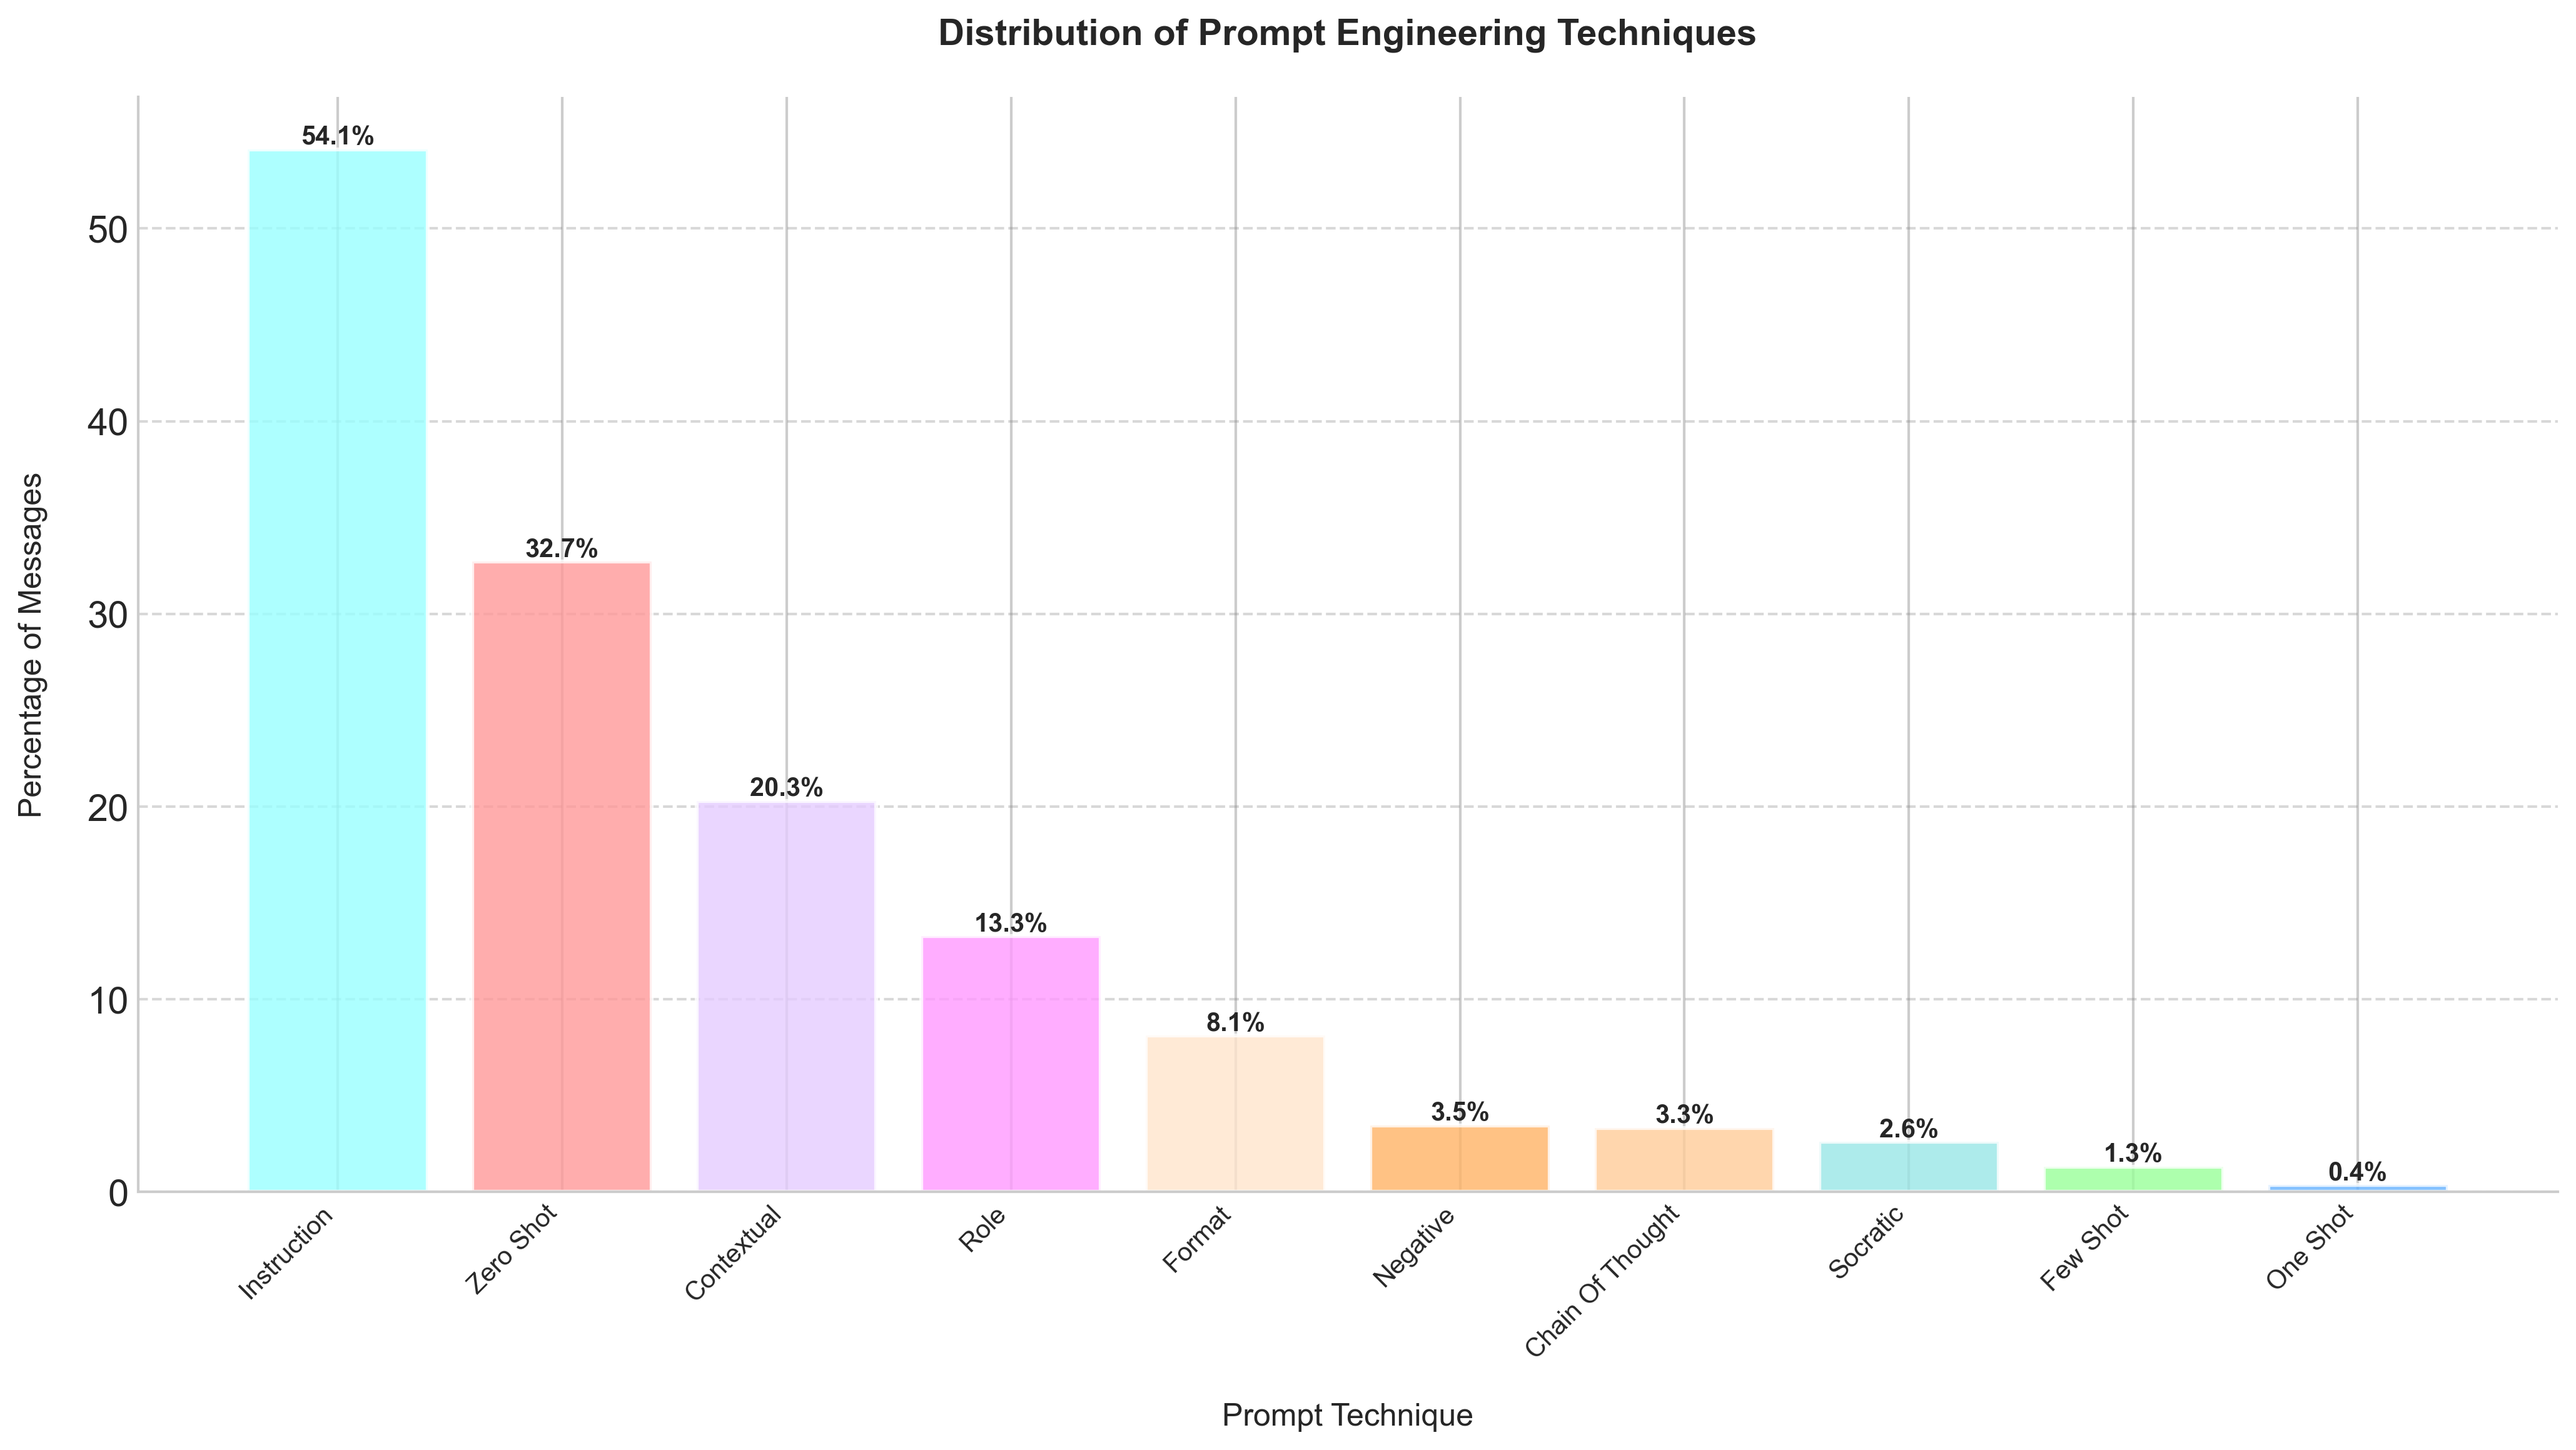

In [47]:
def create_technique_color_mapping():
    technique_colors = {
        "zero-shot": "#FF9999",
        "one-shot": "#66B2FF",
        "few-shot": "#99FF99",
        "chain-of-thought": "#FFCC99",
        "role": "#FF99FF",
        "instruction": "#99FFFF",
        "format": "#FFE5CC",
        "contextual": "#E5CCFF",
        "negative": "#FFB366",
        "socratic": "#99E6E6",
    }
    return technique_colors


valid_techniques_color_mapping = {
    "zero-shot": "#FF9999",
    "one-shot": "#66B2FF",
    "few-shot": "#99FF99",
    "chain-of-thought": "#FFCC99",
    "role": "#FF99FF",
    "instruction": "#99FFFF",
    "format": "#FFE5CC",
    "contextual": "#E5CCFF",
    "negative": "#FFB366",
    "socratic": "#99E6E6",
}

valid_techniques = valid_techniques_color_mapping.keys()
all_techniques = [
    technique
    for techniques in techniques_df["techniques"]
    if isinstance(techniques, list)
    for technique in techniques
    if technique in valid_techniques
]

technique_counts = pd.Series(all_techniques).value_counts()
total_messages = len(techniques_df)

fig, ax = plt.subplots(figsize=(14, 8), dpi=300)

bars = ax.bar(
    range(len(technique_counts)),
    technique_counts.values / total_messages * 100,
    width=0.8,
    color=[
        valid_techniques_color_mapping[technique]
        for technique in technique_counts.index
    ],
    edgecolor="white",
    linewidth=1.5,
    alpha=0.8,
)

for bar in bars:
    height = bar.get_height()
    count = int(height * total_messages / 100)
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
        weight="bold",
    )

ax.set_ylabel("Percentage of Messages", fontsize=12, labelpad=15)
ax.set_xlabel("Prompt Technique", fontsize=12, labelpad=15)

ax.set_title(
    "Distribution of Prompt Engineering Techniques", fontsize=14, pad=20, weight="bold"
)

ax.set_xticks(range(len(technique_counts)))
ax.set_xticklabels(
    [technique.replace("-", " ").title() for technique in technique_counts.index],
    rotation=45,
    ha="right",
    fontsize=10,
)

ax.grid(axis="y", linestyle="--", alpha=0.3, color="gray")
ax.set_axisbelow(True)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

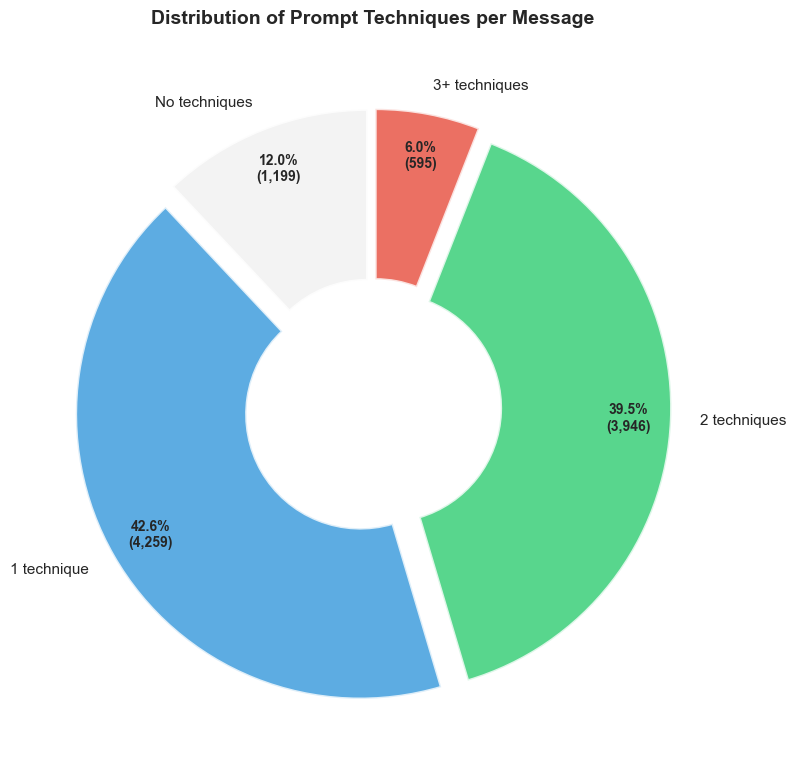

In [48]:
technique_counts = techniques_df["techniques"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)
count_categories = pd.cut(
    technique_counts,
    bins=[-float("inf"), 0, 1, 2, float("inf")],
    labels=["No techniques", "1 technique", "2 techniques", "3+ techniques"],
)
count_distribution = count_categories.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 8))

colors = ["#f0f0f0", "#3498db", "#2ecc71", "#e74c3c"]

wedges, texts, autotexts = ax.pie(
    count_distribution.values,
    labels=count_distribution.index,
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct*sum(count_distribution.values)/100):,})",
    startangle=90,
    colors=colors,
    explode=[0.05] * len(count_distribution),
    pctdistance=0.85,
    wedgeprops=dict(width=0.6, edgecolor="white", linewidth=2, alpha=0.8),
)

plt.setp(autotexts, size=10, weight="bold")
plt.setp(texts, size=11)

plt.title(
    "Distribution of Prompt Techniques per Message", fontsize=14, pad=20, weight="bold"
)

plt.tight_layout()
plt.show()

/var/folders/y5/0t8gc4cj315cwfcx9vxy3kgc0000gn/T/ipykernel_36890/117552482.py:41: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(


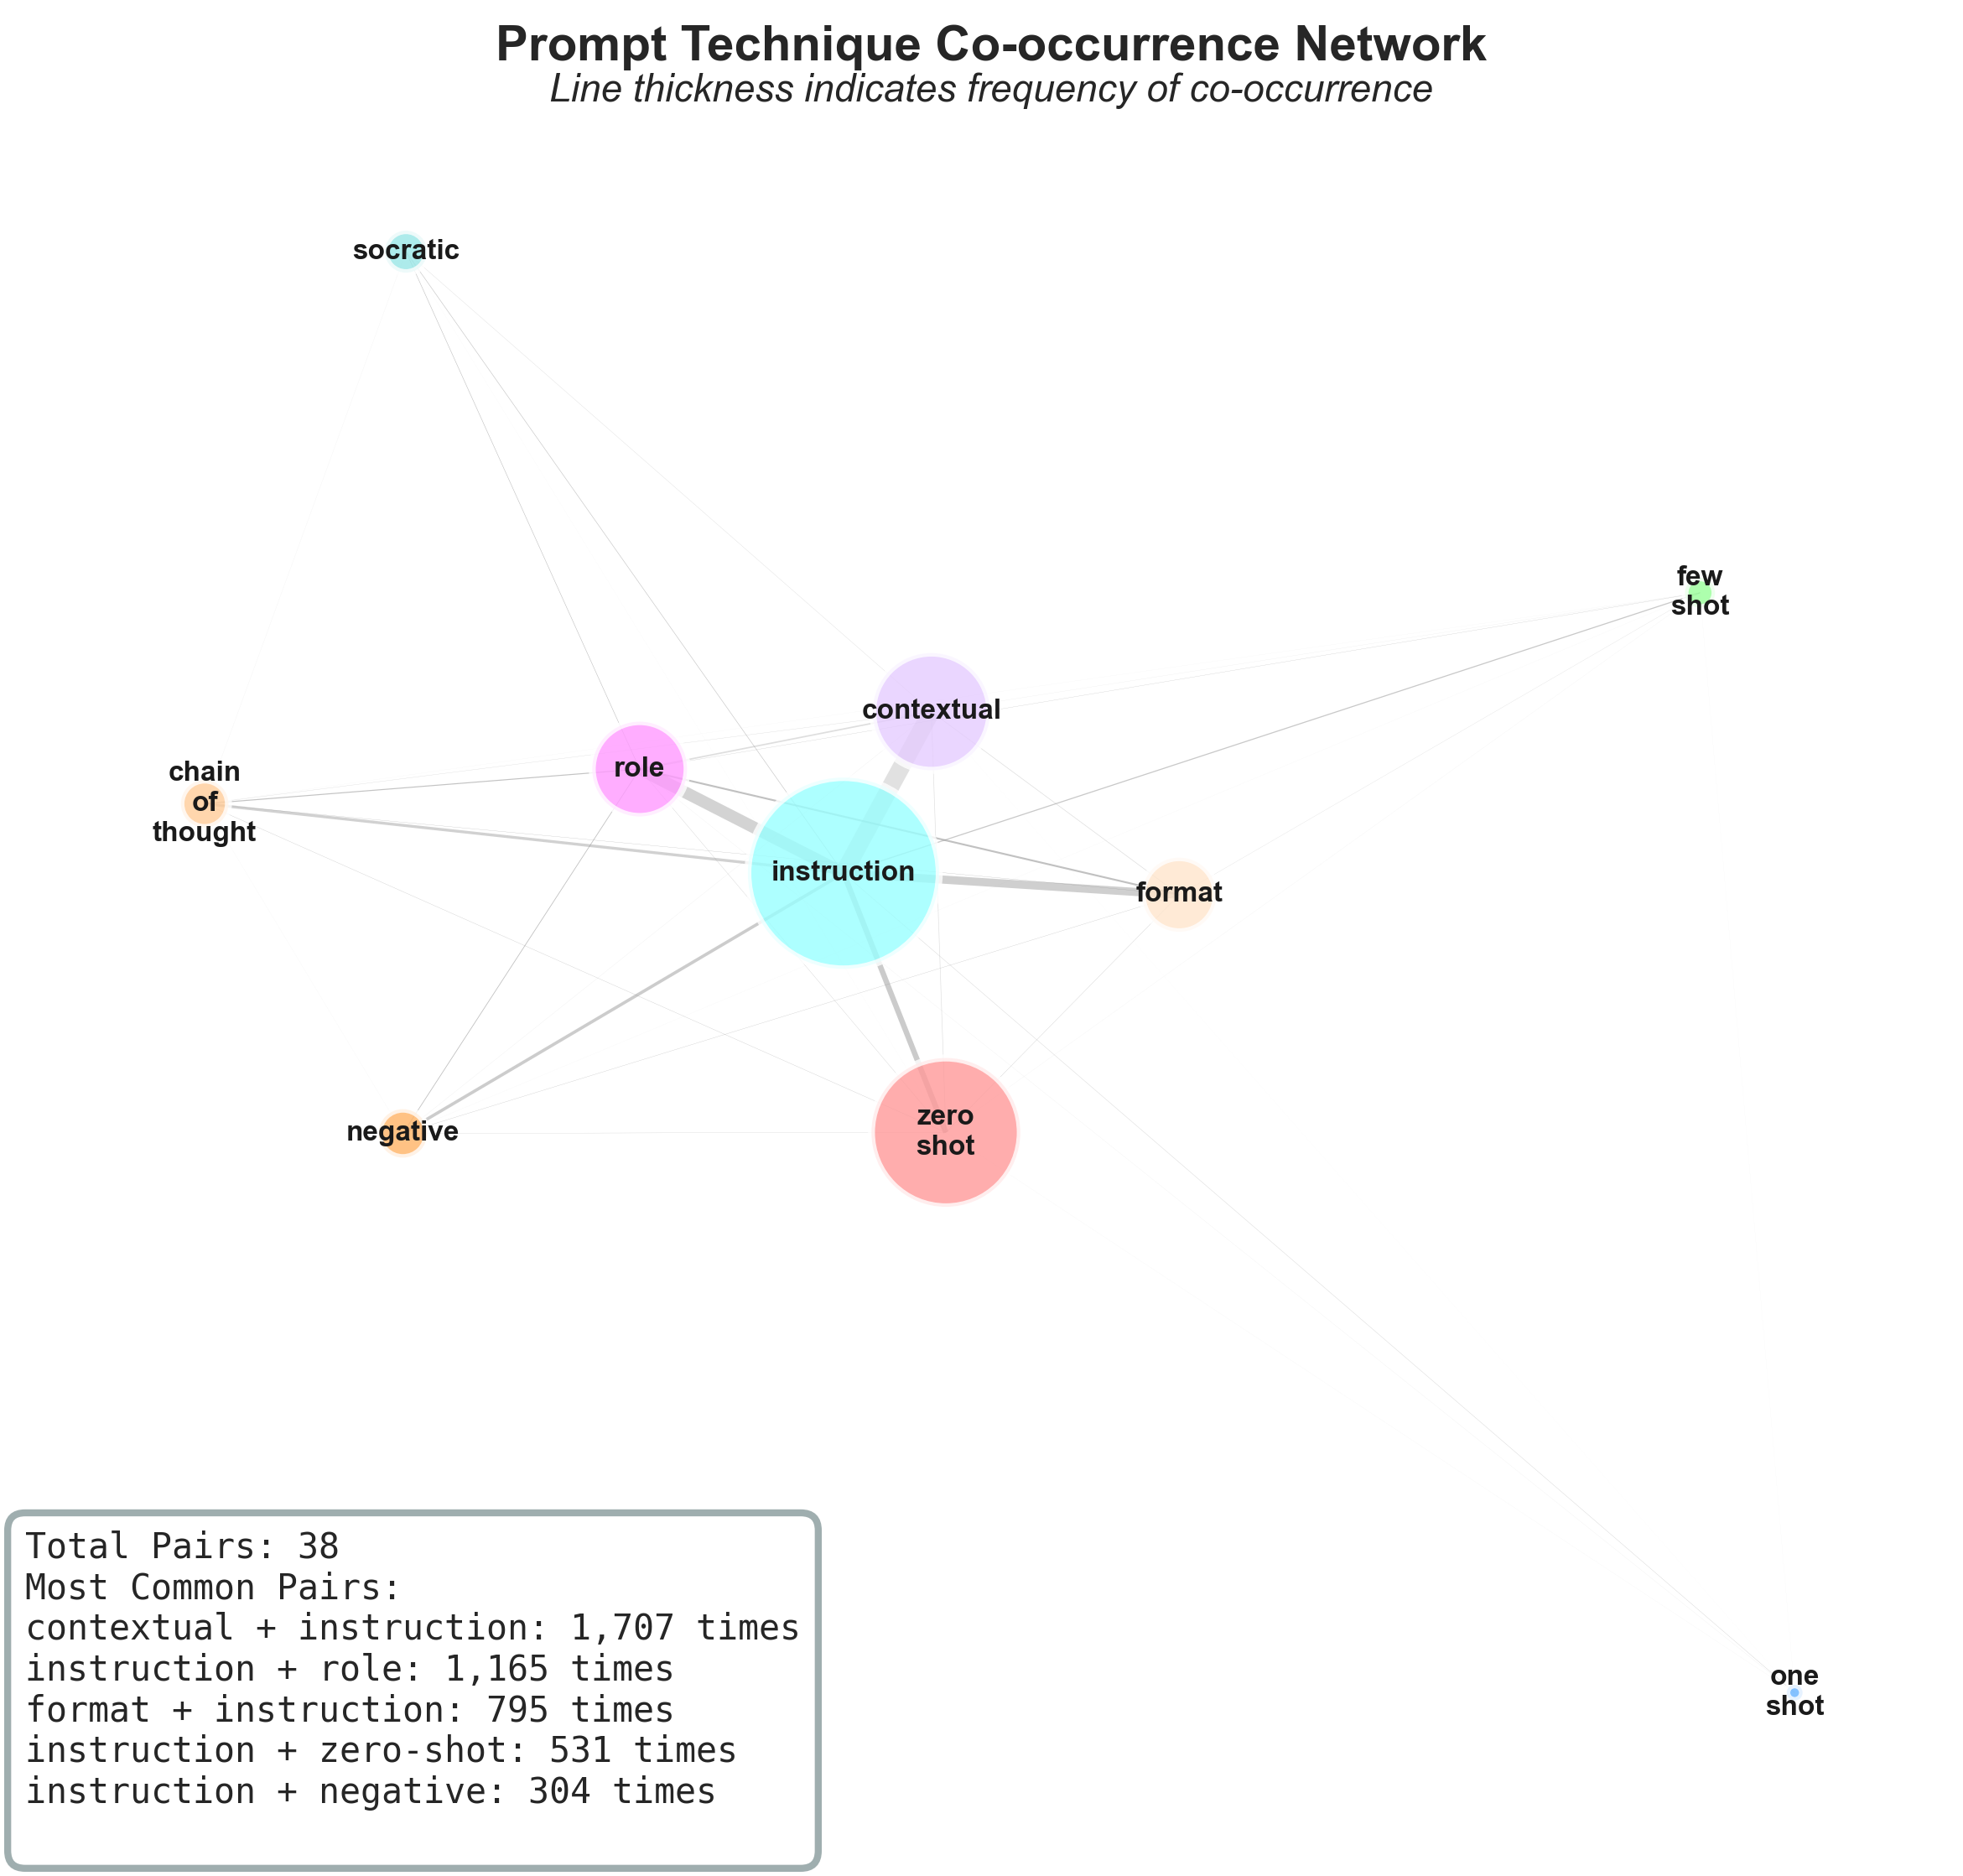

In [384]:
import networkx as nx


def plot_technique_network(techniques_df, valid_techniques_color_mapping):
    G = nx.Graph()
    co_occurrences = {}

    for techniques in techniques_df["techniques"]:
        if not isinstance(techniques, list) or len(techniques) < 2:
            continue
        techniques = [tech for tech in techniques if tech in valid_techniques]
        for i in range(len(techniques)):
            for j in range(i + 1, len(techniques)):
                pair = tuple(sorted([techniques[i], techniques[j]]))
                co_occurrences[pair] = co_occurrences.get(pair, 0) + 1

    if not co_occurrences:
        print("No valid technique pairs found.")
        return

    max_weight = max(co_occurrences.values())
    for (tech1, tech2), weight in co_occurrences.items():
        normalized_weight = (weight / max_weight) * 10
        G.add_edge(tech1, tech2, weight=normalized_weight)

    node_sizes = {}
    for techniques in techniques_df["techniques"]:
        if not isinstance(techniques, list):
            continue
        for tech in techniques:
            if tech in valid_techniques:
                node_sizes[tech] = node_sizes.get(tech, 0) + 1

    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)

    pos = nx.spring_layout(G, k=0.5, iterations=200)

    edges = G.edges(data=True)
    edge_colors = plt.cm.Greys(np.linspace(0.3, 0.7, len(edges)))

    for (u, v, d), color in zip(edges, edge_colors):
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=[(u, v)],
            width=d["weight"] * 0.5,
            alpha=0.6,
            edge_color=[color],
            connectionstyle="arc3,rad=0.1",
        )

    max_size = max(node_sizes.values())
    node_list = list(G.nodes())
    node_sizes_normalized = [
        node_sizes.get(node, 0) / max_size * 3000 for node in node_list
    ]
    node_colors = [valid_techniques_color_mapping[node] for node in node_list]

    nodes = nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_sizes_normalized,
        node_color=node_colors,
        alpha=0.8,
        edgecolors="white",
        linewidths=2,
    )

    labels = {node: node.replace("-", "\n") for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_weight="bold")

    plt.title(
        "Prompt Technique Co-occurrence Network", fontsize=14, pad=20, weight="bold"
    )
    plt.suptitle(
        "Line thickness indicates frequency of co-occurrence",
        fontsize=11,
        y=0.9,
        style="italic",
    )

    stats_text = f"Total Pairs: {len(co_occurrences):,}\n" f"Most Common Pairs:\n"
    top_pairs = sorted(co_occurrences.items(), key=lambda x: x[1], reverse=True)[:5]
    for (tech1, tech2), count in top_pairs:
        stats_text += f"{tech1} + {tech2}: {count:,} times\n"
    plt.figtext(
        0.02,
        0.02,
        stats_text,
        bbox=dict(
            boxstyle="round,pad=0.5",
            facecolor="white",
            alpha=0.9,
            edgecolor="#95a5a6",
            linewidth=2,
        ),
        fontsize=10,
        family="monospace",
    )

    plt.axis("off")
    plt.tight_layout()
    plt.show()


plot_technique_network(techniques_df, valid_techniques_color_mapping)

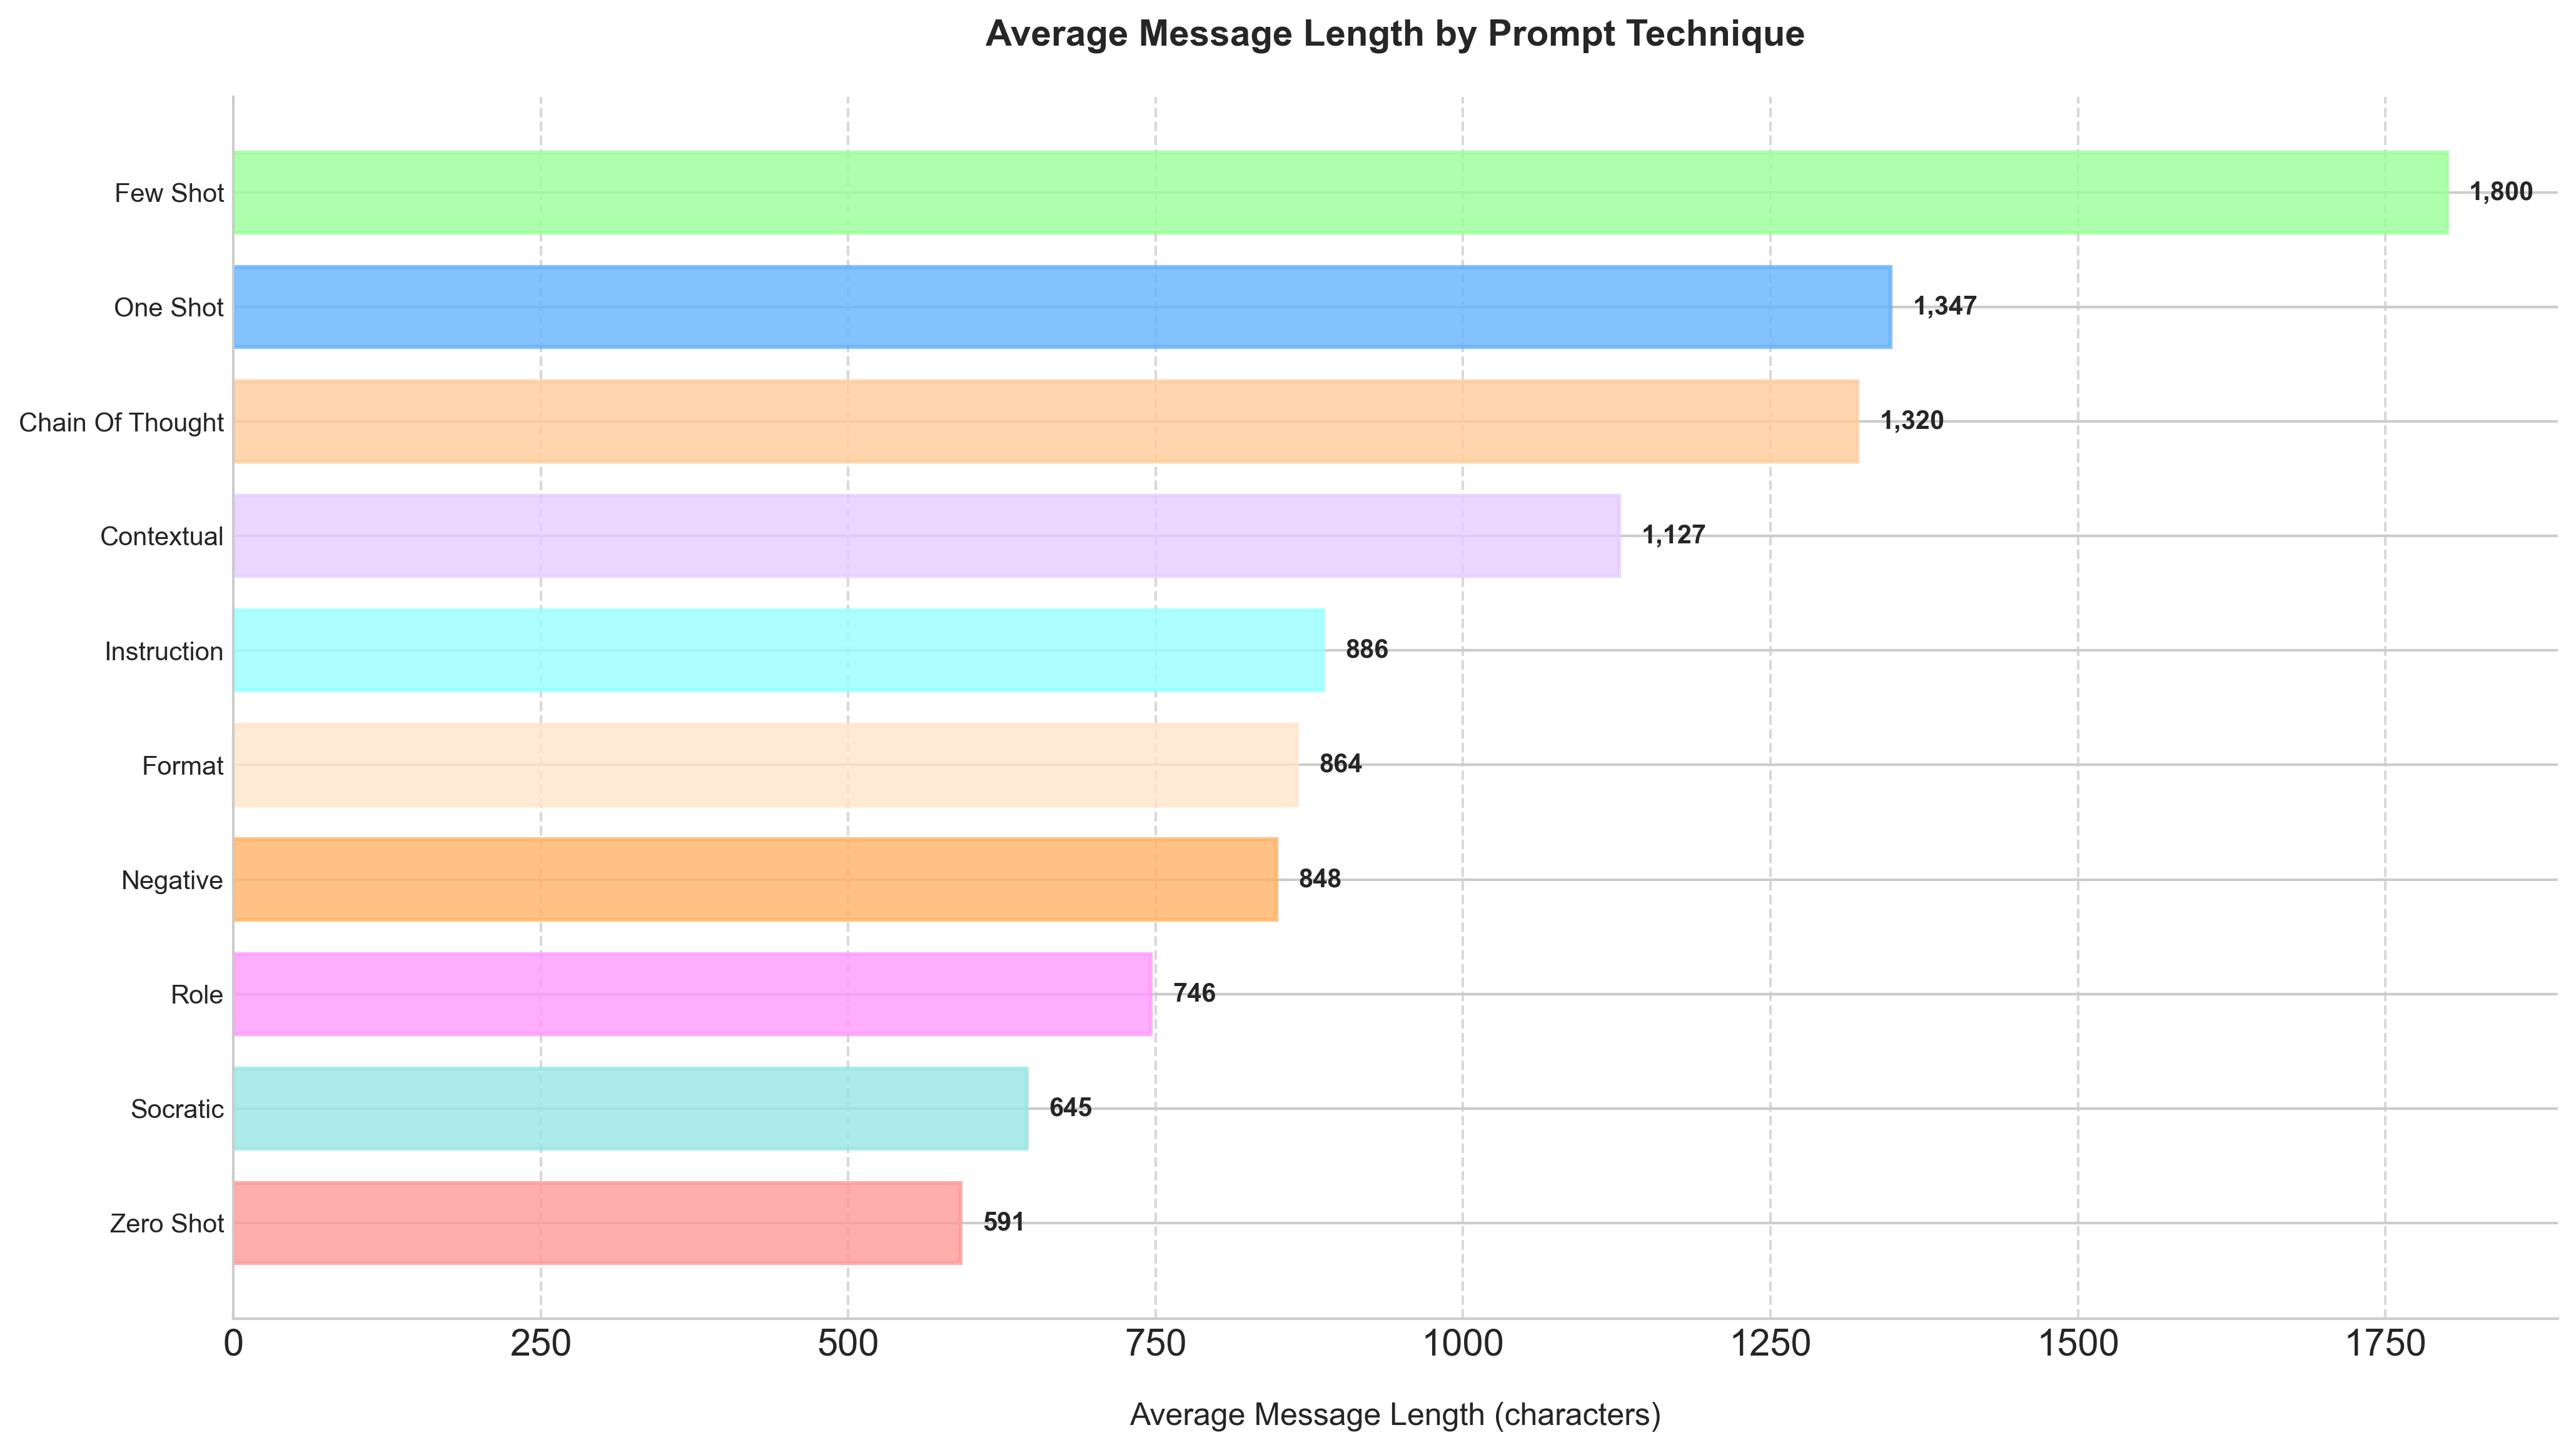

In [49]:
def plot_technique_message_lengths(df_expanded, techniques_df, valid_techniques):
    technique_lengths = {}

    for technique in valid_techniques:
        technique_lengths[technique] = {"lengths": [], "count": 0}

    for _, row in techniques_df.iterrows():
        if isinstance(row["techniques"], list) and row["techniques"]:
            conv_messages = df_expanded[
                df_expanded["post_number"] == row["post_number"]
            ]["message"]
            avg_msg_length = np.mean([len(str(msg)) for msg in conv_messages])

            for technique in row["techniques"]:
                if technique in valid_techniques:
                    technique_lengths[technique]["lengths"].append(avg_msg_length)
                    technique_lengths[technique]["count"] += 1

    plot_data = pd.DataFrame(
        [
            {
                "technique": technique,
                "avg_length": np.mean(stats["lengths"]) if stats["lengths"] else 0,
                "count": stats["count"],
            }
            for technique, stats in technique_lengths.items()
        ]
    )

    plot_data = plot_data.sort_values("avg_length", ascending=True)

    fig, ax = plt.subplots(figsize=(14, 8), dpi=300)

    bars = ax.barh(
        range(len(plot_data)),
        plot_data["avg_length"],
        height=0.7,
        alpha=0.8,
        edgecolor="white",
        linewidth=1.5,
    )

    max_width = plot_data["avg_length"].max()
    for i, bar in enumerate(bars):
        bar.set_color(
            valid_techniques_color_mapping.get(
                plot_data.iloc[i]["technique"], "#CCCCCC"
            )
        )
        width = bar.get_width()
        ax.text(
            width + (max_width * 0.01),
            bar.get_y() + bar.get_height() / 2,
            f"{int(width):,}",
            va="center",
            ha="left",
            fontsize=10,
            weight="bold",
        )

    ax.set_xlabel("Average Message Length (characters)", fontsize=12, labelpad=15)

    ax.set_title(
        "Average Message Length by Prompt Technique", fontsize=14, pad=20, weight="bold"
    )

    ax.set_yticks(range(len(plot_data)))
    labels = [
        technique.replace("-", " ").title() for technique in plot_data["technique"]
    ]
    ax.set_yticklabels(labels, fontsize=10)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.grid(axis="x", linestyle="--", alpha=0.3, color="gray")
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()


plot_technique_message_lengths(df_expanded, techniques_df, valid_techniques)

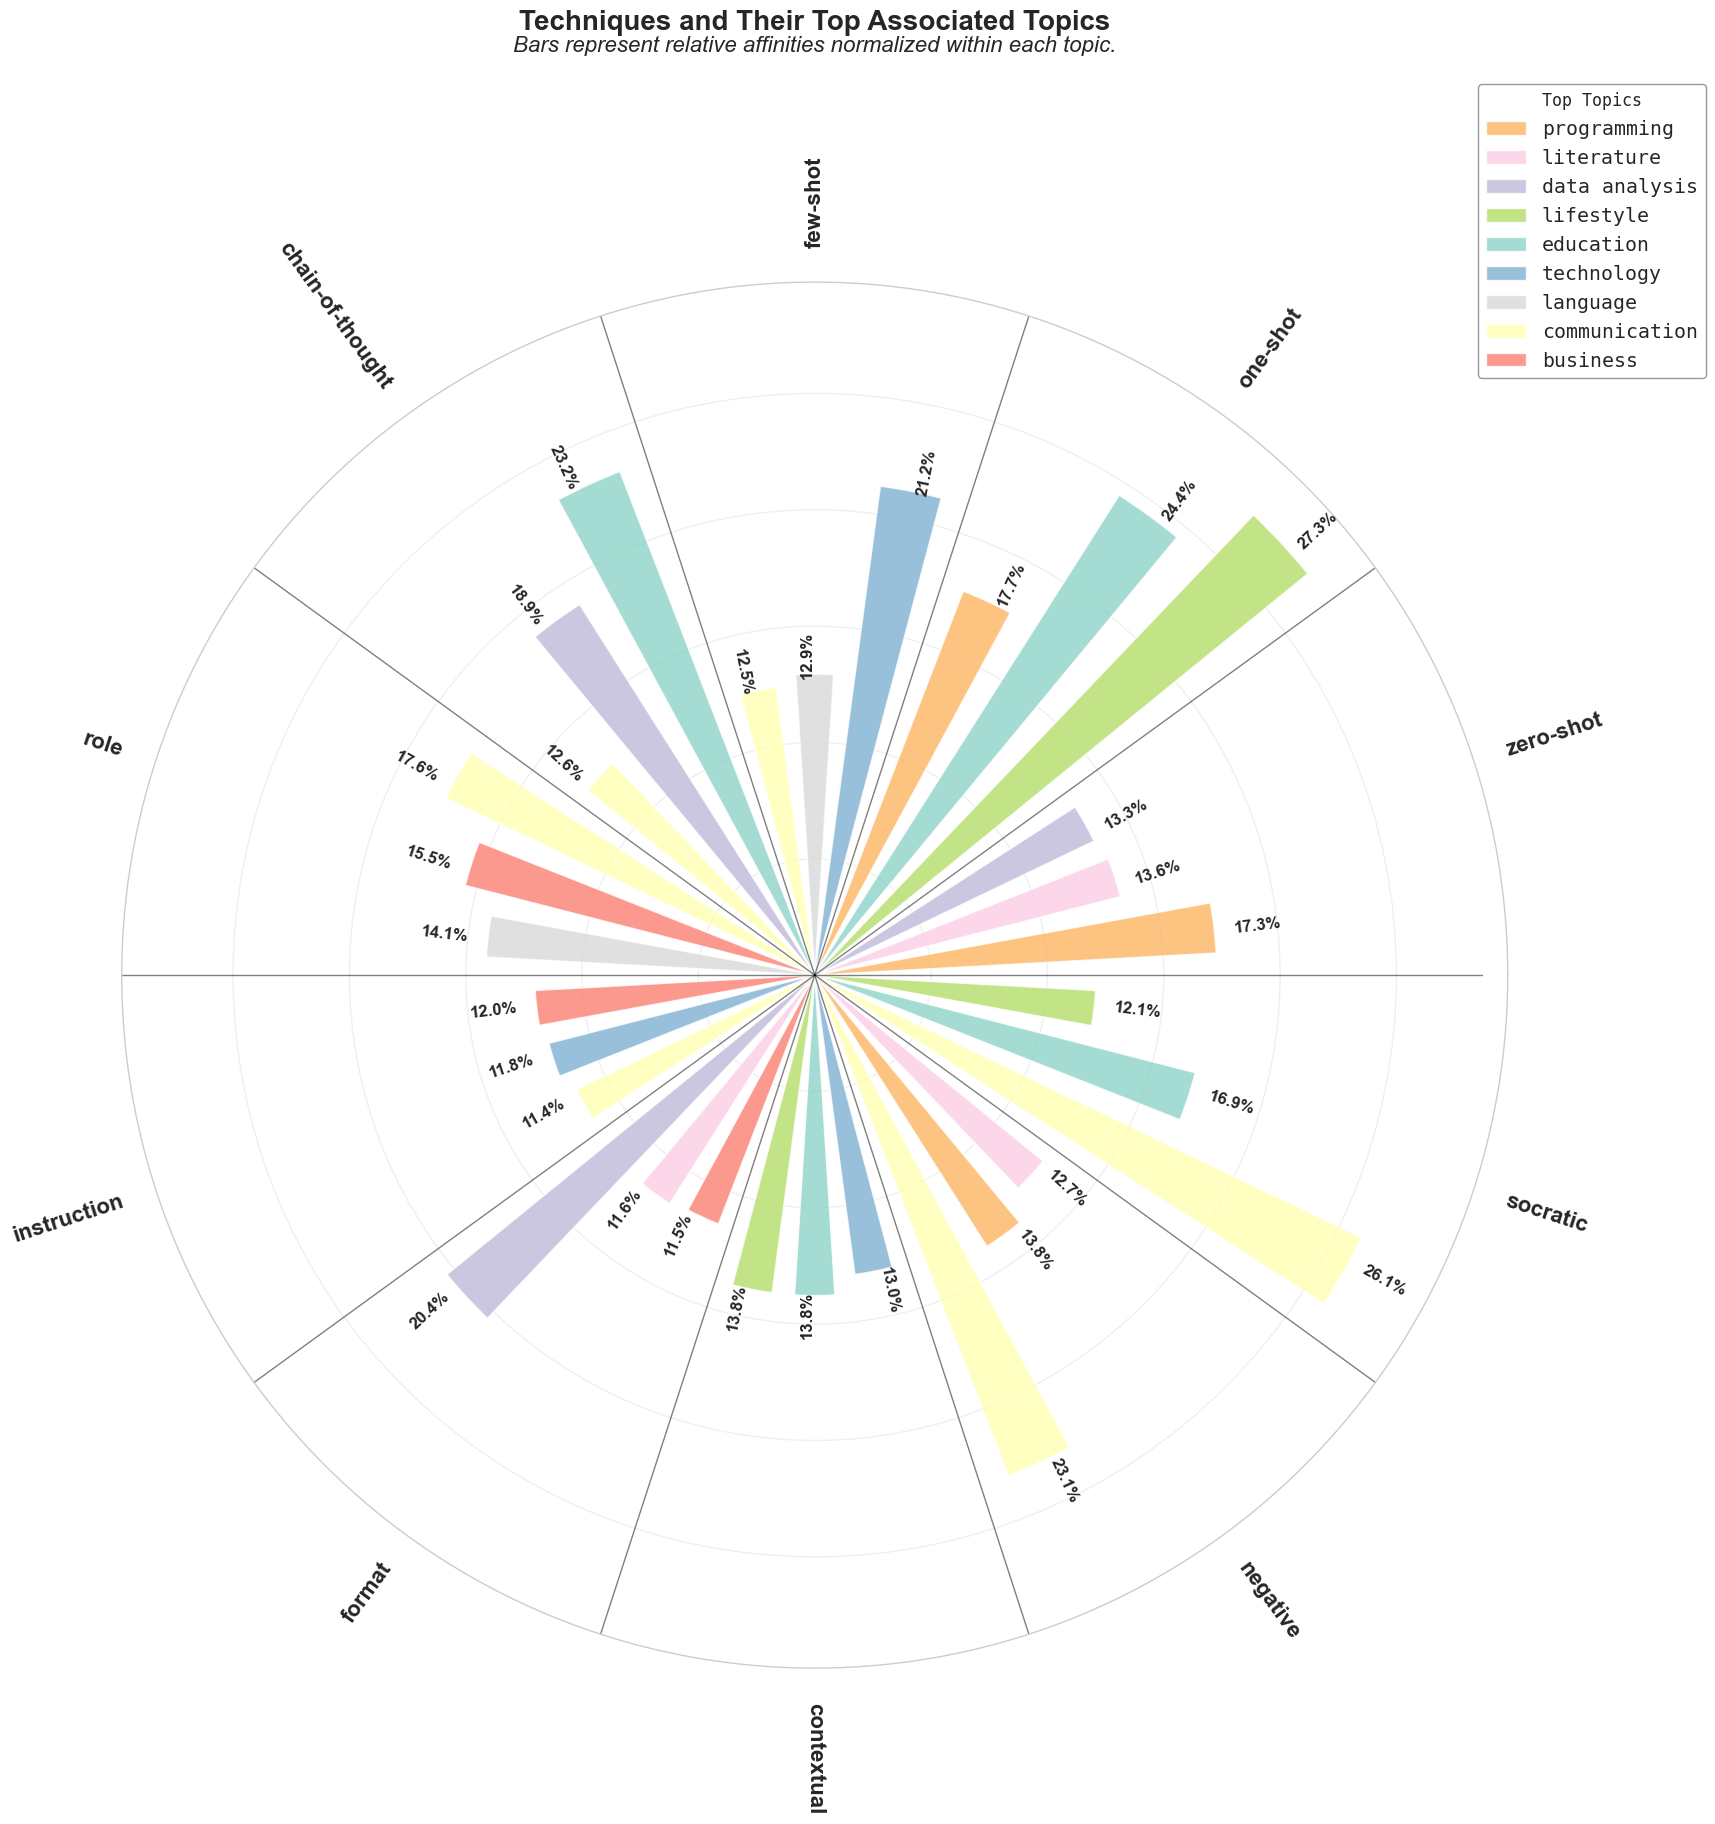

In [58]:
def calculate_technique_topic_stats(
    techniques_df, fast_topic_df, topic_info_labeled, valid_techniques
):
    techniques_with_topics = techniques_df.merge(
        fast_topic_df[["post_number", "topic"]], on="post_number", how="left"
    ).merge(topic_info_labeled[["topic", "label"]], on="topic", how="left")

    all_topics = techniques_with_topics["label"].unique()

    technique_topic_stats = {}
    num_topics_per_technique = 3

    topic_technique_counts = {}
    for topic in all_topics:
        topic_technique_counts[topic] = {technique: 0 for technique in valid_techniques}
        topic_posts = techniques_with_topics[techniques_with_topics["label"] == topic]

        for technique in valid_techniques:
            count = topic_posts[
                topic_posts["techniques"].apply(
                    lambda x: technique in x if isinstance(x, list) else False
                )
            ].shape[0]
            topic_technique_counts[topic][technique] = count

    for technique in valid_techniques:
        technique_topic_stats[technique] = {
            "topics": [],
            "normalized_pcts": [],
            "total_posts": 0,
            "all_topics": {},
        }

        topic_normalized = {}
        for topic in all_topics:
            topic_total = sum(topic_technique_counts[topic].values())
            if topic_total > 0:
                topic_normalized[topic] = (
                    topic_technique_counts[topic][technique] / topic_total
                )
            else:
                topic_normalized[topic] = 0

        total_proportions = sum(topic_normalized.values())
        if total_proportions > 0:
            for topic in all_topics:
                percentage = (topic_normalized[topic] / total_proportions) * 100
                technique_topic_stats[technique]["all_topics"][topic] = percentage
        else:
            for topic in all_topics:
                technique_topic_stats[technique]["all_topics"][topic] = 0

        technique_topic_stats[technique]["total_posts"] = sum(
            topic_technique_counts[topic][technique] for topic in all_topics
        )
        sorted_topics = sorted(
            technique_topic_stats[technique]["all_topics"].items(),
            key=lambda x: x[1],
            reverse=True,
        )

        technique_topic_stats[technique]["topics"] = [
            topic for topic, _ in sorted_topics[:num_topics_per_technique]
        ]
        technique_topic_stats[technique]["normalized_pcts"] = [
            pct for _, pct in sorted_topics[:num_topics_per_technique]
        ]

    return technique_topic_stats, num_topics_per_technique


def create_circular_plot(technique_topic_stats, num_topics_per_technique):
    fig = plt.figure(figsize=(18, 18))
    ax = fig.add_subplot(111, projection="polar")

    num_techniques = len(technique_topic_stats)
    width = 2 * np.pi / num_techniques
    start_angle = 0
    bar_width = width / (num_topics_per_technique + 1)

    max_normalized_pct = max(
        [max(d["normalized_pcts"]) for d in technique_topic_stats.values()]
    )
    dynamic_radius = max_normalized_pct * 1.09

    plot_bars_and_labels(
        ax,
        technique_topic_stats,
        width,
        bar_width,
        num_topics_per_technique,
        start_angle,
    )
    techniques = list(technique_topic_stats.keys())
    plot_technique_labels(ax, techniques, width, start_angle, dynamic_radius)
    format_plot(ax, num_techniques, width, start_angle)
    ax.set_rmax(dynamic_radius)
    plt.show()


def plot_bars_and_labels(
    ax, technique_topic_stats, width, bar_width, num_topics_per_technique, start_angle
):
    max_normalized_pct = max(
        [max(d["normalized_pcts"]) for d in technique_topic_stats.values()]
    )

    for i, (technique, data) in enumerate(technique_topic_stats.items()):
        section_start = start_angle + (i * width)

        total_bars_width = bar_width * num_topics_per_technique
        padding_space = width - total_bars_width
        padding = padding_space / (num_topics_per_technique + 1)

        for j, (topic, value) in enumerate(
            zip(data["topics"], data["normalized_pcts"])
        ):
            bar_angle = (
                section_start + padding + (j * (bar_width + padding)) + bar_width / 2
            )
            bar_angle = bar_angle % (2 * np.pi)

            plot_bar(ax, bar_angle, value, bar_width, topic)
            plot_value_label(ax, bar_angle, value, max_normalized_pct)


def plot_bar(ax, bar_angle, value, bar_width, topic):
    ax.bar(
        bar_angle,
        value,
        width=bar_width * 0.8,
        bottom=0.0,
        color=topic_colors.get(topic, "gray"),
        alpha=0.8,
        label=topic if topic not in ax.get_legend_handles_labels()[1] else "",
        edgecolor="white",
        linewidth=1,
        zorder=2,
    )


def plot_value_label(ax, bar_angle, value, max_normalized_pct):
    label_radius = value + (max_normalized_pct * 0.03)
    rotation_deg, alignment = calculate_label_orientation(bar_angle)

    ax.text(
        bar_angle,
        label_radius,
        f"{value:.1f}%",
        ha=alignment,
        va="center",
        rotation=rotation_deg,
        fontsize=12,
        fontweight="bold",
        zorder=3,
    )


def plot_technique_labels(ax, techniques, width, start_angle, dynamic_radius):
    fixed_label_radius = dynamic_radius * 1.05

    for index, technique in enumerate(techniques):
        angle = start_angle + index * width + (width / 2)

        if np.pi / 2 < angle < 3 * np.pi / 2:
            alignment = "right"
            rotation_deg = np.degrees(angle) + 180
        else:
            alignment = "left"
            rotation_deg = np.degrees(angle)

        ax.text(
            angle,
            fixed_label_radius,
            technique,
            ha=alignment,
            va="center",
            fontsize=16,
            fontweight="bold",
            rotation=rotation_deg if alignment == "left" else rotation_deg,
            rotation_mode="anchor",
            zorder=3,
        )


def calculate_label_orientation(angle):
    if np.pi / 2 <= angle < 3 * np.pi / 2:
        alignment = "right"
        rotation_deg = np.degrees(angle) + 180
    else:
        alignment = "left"
        rotation_deg = np.degrees(angle)

    if rotation_deg >= 90 and rotation_deg <= 270:
        rotation_deg += 180
        alignment = "right"

    return rotation_deg, alignment


def format_plot(ax, num_techniques, width, start_angle):
    title = "Techniques and Their Top Associated Topics\n"
    subtitle = "Bars represent relative affinities normalized within each topic.\n\n"

    ax.set_title(title, va="bottom", fontsize=20, fontweight="bold", y=1.15)
    ax.text(
        0.5,
        1.13,
        subtitle,
        ha="center",
        va="bottom",
        fontsize=16,
        fontstyle="italic",
        transform=ax.transAxes,
    )

    ax.grid(True, alpha=0.3)

    ax.set_xticks([])
    ax.set_yticklabels([])

    for i in range(num_techniques):
        angle = start_angle + i * width
        ax.plot(
            [angle, angle], [0, ax.get_rmax()], color="black", linewidth=1, alpha=0.5
        )

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(
        by_label.values(),
        by_label.keys(),
        bbox_to_anchor=(1.15, 1.15),
        loc="upper right",
        title="Top Topics",
        fontsize=10,
        frameon=True,
        facecolor="white",
        edgecolor="gray",
        prop={"family": "monospace"},
        title_fontproperties={"family": "monospace", "size": 12},
    )


def show_circular_category_distribution(
    techniques_df, fast_topic_df, topic_info_labeled, valid_techniques
):
    stats, num_topics = calculate_technique_topic_stats(
        techniques_df, fast_topic_df, topic_info_labeled, valid_techniques
    )
    create_circular_plot(stats, num_topics)


show_circular_category_distribution(
    techniques_df,
    fast_topic_df,
    topic_info_labeled,
    valid_techniques,
)

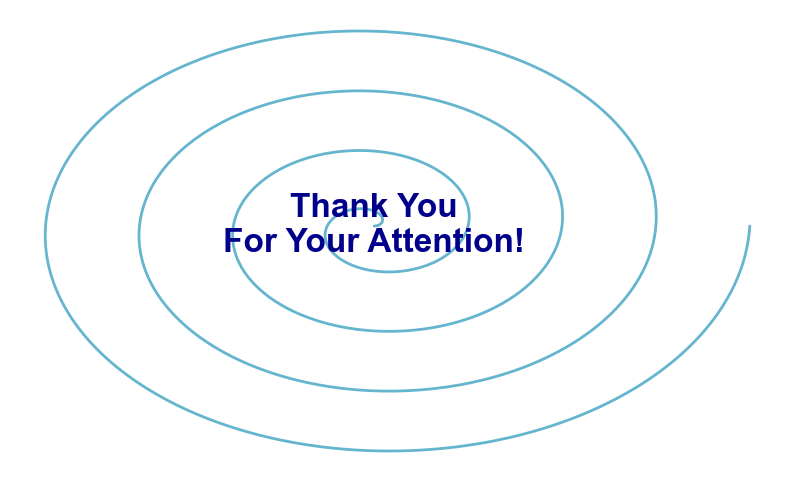

In [691]:
theta = np.linspace(0, 8 * np.pi, 1000)
r = np.linspace(0, 1, 1000)
x = r * np.cos(theta)
y = r * np.sin(theta)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y, color="c", linewidth=2)

ax.text(
    0,
    0,
    "Thank You\nFor Your Attention!",
    fontsize=24,
    color="darkblue",
    fontweight="bold",
    ha="center",
    va="center",
)

ax.set_facecolor("lavender")
ax.axis("off")

plt.show()